<a href="https://colab.research.google.com/github/Sriramlingavel/MultiModal_Fashion_LLM/blob/main/GenAI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# necessary dependencies

In [ ]:
!pip install tiktoken tensorflow bitsandbytes sympy==1.12.0 fire

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

# importing drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# extracting existing base model weights and config from drive

In [ ]:
import zipfile

# Replace 'your_file.zip' with the name of the uploaded zip file
with zipfile.ZipFile('/content/drive/MyDrive/gpt2_model.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Files')

# Replace 'your_file.zip' with the name of the uploaded zip file
with zipfile.ZipFile('/content/drive/MyDrive/paligemma_model.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Files')

# custom LLM architecture implementation

In [ ]:
import os
import torch
import torch.nn as nn
import tiktoken
import numpy as np
import json
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# ------------------------------
# Custom Model Architecture
# ------------------------------

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=True):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

# ------------------------------
# Data Loading and Preprocessing
# ------------------------------

class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader(txt, batch_size=4, max_length=1024,
                      stride=512, shuffle=True, drop_last=True,
                      num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader

# ------------------------------
# GPT-2 Model Setup
# ------------------------------

# Configuration for GPT-2 large (774M)
GPT_CONFIG_774M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1280,
    "n_heads": 20,
    "n_layers": 36,
    "drop_rate": 0.1,
    "qkv_bias": True
}

# ------------------------------
# GPT-2 Model Weight Loading (from local path)
# ------------------------------

def load_gpt2_params_from_local_path(model_path, model_size="774M"):
    """Load parameters from local GPT-2 model path."""
    try:
        import tensorflow as tf
    except ImportError:
        raise ImportError("TensorFlow is required to load GPT-2 weights.")

    # Define the checkpoint path
    model_dir = os.path.join(model_path, model_size)
    ckpt_path = os.path.join(model_dir, "model.ckpt")
    hparams_path = os.path.join(model_dir, "hparams.json")

    # Check if files exist
    if not os.path.exists(hparams_path):
        raise FileNotFoundError(f"hparams.json not found at {hparams_path}")

    # Load settings
    with open(hparams_path, 'r') as f:
        settings = json.load(f)

    # Initialize params dict
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Load each variable from the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Map TensorFlow variables to our PyTorch model structure
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Build nested dictionary structure
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Store variable in dictionary
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    # Add wte (word token embeddings) and wpe (position embeddings) at top level for convenience
    for name in ["wte", "wpe"]:
        if name in params:
            continue  # Skip if already at top level
        for block in params["blocks"]:
            if name in block:
                params[name] = block[name]
                break

    return settings, params

def load_weights_into_gpt(gpt, params):
    """Load GPT-2 weights from params dict into PyTorch model."""
    # Load embeddings
    gpt.pos_emb.weight = nn.Parameter(torch.tensor(params['wpe']))
    gpt.tok_emb.weight = nn.Parameter(torch.tensor(params['wte']))

    # Load transformer blocks
    for b in range(len(params["blocks"])):
        # Split QKV weights and biases
        block = params["blocks"][b]

        # Handle attention layers
        if "attn" in block:
            # QKV weights
            q_w, k_w, v_w = np.split(block["attn"]["c_attn"]["w"], 3, axis=-1)
            gpt.trf_blocks[b].att.W_query.weight = nn.Parameter(torch.tensor(q_w.T))
            gpt.trf_blocks[b].att.W_key.weight = nn.Parameter(torch.tensor(k_w.T))
            gpt.trf_blocks[b].att.W_value.weight = nn.Parameter(torch.tensor(v_w.T))

            # QKV biases
            q_b, k_b, v_b = np.split(block["attn"]["c_attn"]["b"], 3, axis=-1)
            gpt.trf_blocks[b].att.W_query.bias = nn.Parameter(torch.tensor(q_b))
            gpt.trf_blocks[b].att.W_key.bias = nn.Parameter(torch.tensor(k_b))
            gpt.trf_blocks[b].att.W_value.bias = nn.Parameter(torch.tensor(v_b))

            # Output projection
            gpt.trf_blocks[b].att.out_proj.weight = nn.Parameter(torch.tensor(block["attn"]["c_proj"]["w"].T))
            gpt.trf_blocks[b].att.out_proj.bias = nn.Parameter(torch.tensor(block["attn"]["c_proj"]["b"]))

        # Handle feed-forward layers
        if "mlp" in block:
            # First linear layer
            gpt.trf_blocks[b].ff.layers[0].weight = nn.Parameter(torch.tensor(block["mlp"]["c_fc"]["w"].T))
            gpt.trf_blocks[b].ff.layers[0].bias = nn.Parameter(torch.tensor(block["mlp"]["c_fc"]["b"]))

            # Second linear layer (after activation)
            gpt.trf_blocks[b].ff.layers[2].weight = nn.Parameter(torch.tensor(block["mlp"]["c_proj"]["w"].T))
            gpt.trf_blocks[b].ff.layers[2].bias = nn.Parameter(torch.tensor(block["mlp"]["c_proj"]["b"]))

        # Handle layer norms
        if "ln_1" in block:
            gpt.trf_blocks[b].norm1.scale = nn.Parameter(torch.tensor(block["ln_1"]["g"]))
            gpt.trf_blocks[b].norm1.shift = nn.Parameter(torch.tensor(block["ln_1"]["b"]))

        if "ln_2" in block:
            gpt.trf_blocks[b].norm2.scale = nn.Parameter(torch.tensor(block["ln_2"]["g"]))
            gpt.trf_blocks[b].norm2.shift = nn.Parameter(torch.tensor(block["ln_2"]["b"]))

    # Load final layer norm
    if "ln_f" in params:
        gpt.final_norm.scale = nn.Parameter(torch.tensor(params["ln_f"]["g"]))
        gpt.final_norm.shift = nn.Parameter(torch.tensor(params["ln_f"]["b"]))
    elif "g" in params and "b" in params:
        gpt.final_norm.scale = nn.Parameter(torch.tensor(params["g"]))
        gpt.final_norm.shift = nn.Parameter(torch.tensor(params["b"]))

    # Output head (reuse token embedding weights)
    gpt.out_head.weight = nn.Parameter(torch.tensor(params["wte"]))

# ------------------------------
# Text Generation Functions
# ------------------------------

def generate(model, idx, max_new_tokens, context_size, temperature=0.7, top_k=40, eos_id=None):
    """Generate text with temperature and top-k sampling."""
    model.eval()

    for _ in range(max_new_tokens):
        # Get context for current generation step
        idx_cond = idx[:, -context_size:]

        # Forward pass
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus on the last token
        logits = logits[:, -1, :]

        # Apply top-k filtering
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = float('-inf')

        # Apply temperature
        if temperature > 0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            # Greedy sampling
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        # Stop if EOS token is generated
        if eos_id is not None and (idx_next == eos_id).any():
            stop_indices = (idx_next == eos_id).nonzero(as_tuple=True)[0]
            if len(stop_indices) > 0:
                break

        # Append new token to sequence
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def text_to_token_ids(text, tokenizer=None):
    """Convert text to token IDs."""
    if tokenizer is None:
        tokenizer = tiktoken.get_encoding("gpt2")
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    return torch.tensor(encoded).unsqueeze(0)

def token_ids_to_text(token_ids, tokenizer=None):
    """Convert token IDs to text."""
    if tokenizer is None:
        tokenizer = tiktoken.get_encoding("gpt2")
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

# ------------------------------
# Training Functions
# ------------------------------

def train_step(model, optimizer, batch, device, criterion=nn.CrossEntropyLoss()):
    """Perform one training step."""
    inputs, targets = batch
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    logits = model(inputs)

    # Reshape for loss calculation
    b, t, c = logits.shape
    logits = logits.view(b * t, c)
    targets = targets.view(b * t)

    # Calculate loss
    loss = criterion(logits, targets)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def evaluate(model, val_loader, device, criterion=nn.CrossEntropyLoss()):
    """Evaluate model on validation data."""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)

            # Reshape for loss calculation
            b, t, c = logits.shape
            logits = logits.view(b * t, c)
            targets = targets.view(b * t)

            # Calculate loss
            loss = criterion(logits, targets)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    model.train()
    return avg_loss

def train_model(model, train_loader, val_loader, optimizer, device,
                num_epochs=3, save_path="gpt2_774m_model.pt"):
    """Train the model."""
    model.to(device)
    model.train()

    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in progress_bar:
            loss = train_step(model, optimizer, batch, device, criterion)
            train_losses.append(loss)
            progress_bar.set_postfix({"train_loss": f"{loss:.4f}"})

        # Validation phase
        val_loss = evaluate(model, val_loader, device, criterion)

        # Print epoch results
        avg_train_loss = sum(train_losses) / len(train_losses)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss
            }, save_path)
            print(f"Saved best model to {save_path}")

    return model

# ------------------------------
# Main Functions
# ------------------------------

def load_pretrained_model_from_path(model_path, model_size="774M", device=None):
    """Load the GPT-2 model from a local path."""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    # Load GPT-2 weights from local path
    print(f"Loading GPT-2 {model_size} model weights from {model_path}...")
    settings, params = load_gpt2_params_from_local_path(model_path, model_size)

    # Initialize our model
    print("Initializing model...")
    model = GPTModel(GPT_CONFIG_774M)

    # Load weights into our model
    print("Loading weights into model...")
    load_weights_into_gpt(model, params)

    # Move model to device
    model.to(device)
    print("Model loaded successfully!")

    return model

def fine_tune_on_text(model, text_file_path, batch_size=2, num_epochs=3, learning_rate=1e-5):
    """Fine-tune the model on a text file."""
    device = next(model.parameters()).device

    # Load text data
    print(f"Loading text data from {text_file_path}...")
    with open(text_file_path, 'r', encoding='utf-8') as f:
        text_data = f.read()

    # Split into train/val
    train_ratio = 0.9
    split_idx = int(train_ratio * len(text_data))
    train_data = text_data[:split_idx]
    val_data = text_data[split_idx:]

    # Create dataloaders
    print("Creating dataloaders...")
    train_loader = create_dataloader(
        train_data,
        batch_size=batch_size,
        max_length=GPT_CONFIG_774M["context_length"],
        stride=512,
        shuffle=True
    )

    val_loader = create_dataloader(
        val_data,
        batch_size=batch_size,
        max_length=GPT_CONFIG_774M["context_length"],
        stride=512,
        shuffle=False
    )

    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)

    # Train the model
    print(f"Starting training for {num_epochs} epochs...")
    model = train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        device,
        num_epochs=num_epochs
    )

    return model

def generate_text(model, prompt, max_length=50, temperature=0.7, top_k=40):
    """Generate text from a prompt."""
    device = next(model.parameters()).device
    tokenizer = tiktoken.get_encoding("gpt2")

    # Convert prompt to token ids
    input_ids = text_to_token_ids(prompt, tokenizer).to(device)

    # Generate text
    output_ids = generate(
        model,
        input_ids,
        max_new_tokens=max_length,
        context_size=GPT_CONFIG_774M["context_length"],
        temperature=temperature,
        top_k=top_k
    )

    # Convert back to text
    generated_text = token_ids_to_text(output_ids, tokenizer)

    return generated_text

def save_model(model, path="gpt2_774m_model.pt"):
    """Save the model to disk."""
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": GPT_CONFIG_774M
    }, path)
    print(f"Model saved to {path}")

def load_model(path="gpt2_774m_model.pt", device=None):
    """Load a saved model from disk."""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    checkpoint = torch.load(path, map_location=device)
    model = GPTModel(GPT_CONFIG_774M)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)

    return model

# ------------------------------
# Example Usage in Google Colab with Drive
# ------------------------------

if __name__ == "__main__":
    # Example usage in Google Colab
    import sys
    is_colab = 'google.colab' in sys.modules

    if is_colab:
        #from google.colab import drive
        #print("Running in Google Colab environment")

        # Mount Google Drive
        #print("Mounting Google Drive...")
        #drive.mount('/content/drive')

        # Specify the path to your uploaded model
        model_path = '/content/Files/gpt2_model'  # Adjust path as needed

        # Check if model exists in the specified path
        if not os.path.exists(os.path.join(model_path, '774M')):
            print(f"GPT-2 model not found at {model_path}/774M")
            print("Please make sure you've uploaded the model to this location")
            exit()
    else:
        # Running locally
        print("Running in local environment")
        model_path = './gpt2_model'  # Default local path

    # Load model from the specified path
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load model
    model = load_pretrained_model_from_path(model_path, device=device)

    # Generate sample text
    sample_text = generate_text(model, "The dress which suits you is")
    print("\nGenerated Text:")
    print(sample_text)

Using device: cpu
Using device: cpu
Loading GPT-2 774M model weights from /content/Files/gpt2_model...
Initializing model...
Loading weights into model...
Model loaded successfully!

Generated Text:
The dress which suits you is also the one which you wear. In fact, every woman needs to dress for herself. If you look like a dress, you're going to look like a dress, so dress for yourself.

The dress you choose cannot be the one that


# custom VLM architecture Implementation

In [ ]:
# === modeling_siglip.py ===
from typing import Optional, Tuple
import torch
import torch.nn as nn

class SiglipVisionConfig:

    def __init__(
        self,
        hidden_size=768,
        intermediate_size=3072,
        num_hidden_layers=12,
        num_attention_heads=12,
        num_channels=3,
        image_size=224,
        patch_size=16,
        layer_norm_eps=1e-6,
        attention_dropout=0.0,
        num_image_tokens: int = None,
        **kwargs
    ):
        super().__init__()

        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.num_channels = num_channels
        self.patch_size = patch_size
        self.image_size = image_size
        self.attention_dropout = attention_dropout
        self.layer_norm_eps = layer_norm_eps
        self.num_image_tokens = num_image_tokens


class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.patch_embedding = nn.Conv2d(
            in_channels=config.num_channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding="valid", # This indicates no padding is added
        )

        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand((1, -1)),
            persistent=False,
        )

    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        _, _, height, width = pixel_values.shape # [Batch_Size, Channels, Height, Width]
        # Convolve the `patch_size` kernel over the image, with no overlapping patches since the stride is equal to the kernel size
        # The output of the convolution will have shape [Batch_Size, Embed_Dim, Num_Patches_H, Num_Patches_W]
        # where Num_Patches_H = height // patch_size and Num_Patches_W = width // patch_size
        patch_embeds = self.patch_embedding(pixel_values)
        # [Batch_Size, Embed_Dim, Num_Patches_H, Num_Patches_W] -> [Batch_Size, Embed_Dim, Num_Patches]
        # where Num_Patches = Num_Patches_H * Num_Patches_W
        embeddings = patch_embeds.flatten(2)
        # [Batch_Size, Embed_Dim, Num_Patches] -> [Batch_Size, Num_Patches, Embed_Dim]
        embeddings = embeddings.transpose(1, 2)
        # Add position embeddings to each patch. Each positional encoding is a vector of size [Embed_Dim]
        embeddings = embeddings + self.position_embedding(self.position_ids)
        # [Batch_Size, Num_Patches, Embed_Dim]
        return embeddings


class SiglipAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.scale = self.head_dim**-0.5 # Equivalent to 1 / sqrt(self.head_dim)
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:

        # hidden_states: [Batch_Size, Num_Patches, Embed_Dim]
        batch_size, seq_len, _ = hidden_states.size()
        # query_states: [Batch_Size, Num_Patches, Embed_Dim]
        query_states = self.q_proj(hidden_states)
        # key_states: [Batch_Size, Num_Patches, Embed_Dim]
        key_states = self.k_proj(hidden_states)
        # value_states: [Batch_Size, Num_Patches, Embed_Dim]
        value_states = self.v_proj(hidden_states)
        # query_states: [Batch_Size, Num_Heads, Num_Patches, Head_Dim]
        query_states = query_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        key_states = key_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        value_states = value_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # Calculate the attention using the formula Q * K^T / sqrt(d_k). attn_weights: [Batch_Size, Num_Heads, Num_Patches, Num_Patches]
        attn_weights = (torch.matmul(query_states, key_states.transpose(2, 3)) * self.scale)

        if attn_weights.size() != (batch_size, self.num_heads, seq_len, seq_len):
            raise ValueError(
                f"Attention weights should be of size {(batch_size, self.num_heads, seq_len, seq_len)}, but is"
                f" {attn_weights.size()}"
            )

        # Apply the softmax row-wise. attn_weights: [Batch_Size, Num_Heads, Num_Patches, Num_Patches]
        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
        # Apply dropout only during training
        attn_weights = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)
        # Multiply the attention weights by the value states. attn_output: [Batch_Size, Num_Heads, Num_Patches, Head_Dim]
        attn_output = torch.matmul(attn_weights, value_states)

        if attn_output.size() != (batch_size, self.num_heads, seq_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(batch_size, self.num_heads, seq_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )
        # [Batch_Size, Num_Heads, Num_Patches, Head_Dim] -> [Batch_Size, Num_Patches, Num_Heads, Head_Dim]
        attn_output = attn_output.transpose(1, 2).contiguous()
        # [Batch_Size, Num_Patches, Num_Heads, Head_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        attn_output = attn_output.reshape(batch_size, seq_len, self.embed_dim)
        # [Batch_Size, Num_Patches, Embed_Dim]
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights


class SiglipMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Intermediate_Size]
        hidden_states = self.fc1(hidden_states)
        # hidden_states: [Batch_Size, Num_Patches, Intermediate_Size]
        hidden_states = nn.functional.gelu(hidden_states, approximate="tanh")
        # [Batch_Size, Num_Patches, Intermediate_Size] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.fc2(hidden_states)

        return hidden_states


class SiglipEncoderLayer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = SiglipAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = SiglipMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)

    # Ignore copy
    def forward(
        self,
        hidden_states: torch.Tensor
    ) -> torch.Tensor:
        # residual: [Batch_Size, Num_Patches, Embed_Dim]
        residual = hidden_states
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.layer_norm1(hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states, _ = self.self_attn(hidden_states=hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = residual + hidden_states
        # residual: [Batch_Size, Num_Patches, Embed_Dim]
        residual = hidden_states
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.layer_norm2(hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.mlp(hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = residual + hidden_states

        return hidden_states


class SiglipEncoder(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList(
            [SiglipEncoderLayer(config) for _ in range(config.num_hidden_layers)]
        )

    # Ignore copy
    def forward(
        self,
        inputs_embeds: torch.Tensor
    ) -> torch.Tensor:
        # inputs_embeds: [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = inputs_embeds

        for encoder_layer in self.layers:
            # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
            hidden_states = encoder_layer(hidden_states)

        return hidden_states


class SiglipVisionTransformer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size

        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipEncoder(config)
        self.post_layernorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        # pixel_values: [Batch_Size, Channels, Height, Width] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.embeddings(pixel_values)

        last_hidden_state = self.encoder(inputs_embeds=hidden_states)

        last_hidden_state = self.post_layernorm(last_hidden_state)

        return last_hidden_state


class SiglipVisionModel(nn.Module):

    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.vision_model = SiglipVisionTransformer(config)

    def forward(self, pixel_values) -> Tuple:
        # [Batch_Size, Channels, Height, Width] -> [Batch_Size, Num_Patches, Embed_Dim]
        return self.vision_model(pixel_values=pixel_values)


# === modeling_gemma.py ===
import torch
from torch import nn
from typing import Optional, Tuple, List
from torch.nn import CrossEntropyLoss
import math


class KVCache():

    def __init__(self) -> None:
        self.key_cache: List[torch.Tensor] = []
        self.value_cache: List[torch.Tensor] = []

    def num_items(self) -> int:
        if len(self.key_cache) == 0:
            return 0
        else:
            # The shape of the key_cache is [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
            return self.key_cache[0].shape[-2]

    def update(
        self,
        key_states: torch.Tensor,
        value_states: torch.Tensor,
        layer_idx: int,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        if len(self.key_cache) <= layer_idx:
            # If we never added anything to the KV-Cache of this layer, let's create it.
            self.key_cache.append(key_states)
            self.value_cache.append(value_states)
        else:
            # ... otherwise we concatenate the new keys with the existing ones.
            # each tensor has shape: [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
            self.key_cache[layer_idx] = torch.cat([self.key_cache[layer_idx], key_states], dim=-2)
            self.value_cache[layer_idx] = torch.cat([self.value_cache[layer_idx], value_states], dim=-2)

        # ... and then we return all the existing keys + the new ones.
        return self.key_cache[layer_idx], self.value_cache[layer_idx]

class GemmaConfig():

    def __init__(
        self,
        vocab_size,
        hidden_size,
        intermediate_size,
        num_hidden_layers,
        num_attention_heads,
        num_key_value_heads,
        head_dim=256,
        max_position_embeddings=8192,
        rms_norm_eps=1e-6,
        rope_theta=10000.0,
        attention_bias=False,
        attention_dropout=0.0,
        pad_token_id=None,
        **kwargs,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_position_embeddings = max_position_embeddings
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.head_dim = head_dim
        self.num_key_value_heads = num_key_value_heads
        self.rms_norm_eps = rms_norm_eps
        self.rope_theta = rope_theta
        self.attention_bias = attention_bias
        self.attention_dropout = attention_dropout
        self.pad_token_id = pad_token_id

class PaliGemmaConfig():

    def __init__(
        self,
        vision_config=None,
        text_config=None,
        ignore_index=-100,
        image_token_index=256000,
        vocab_size=257152,
        projection_dim=2048,
        hidden_size=2048,
        pad_token_id=None,
        **kwargs,
    ):
        super().__init__()
        self.ignore_index = ignore_index
        self.image_token_index = image_token_index
        self.vocab_size = vocab_size
        self.projection_dim = projection_dim
        self.hidden_size = hidden_size
        self.vision_config = vision_config
        self.is_encoder_decoder = False
        self.pad_token_id = pad_token_id

        self.vision_config = SiglipVisionConfig(**vision_config)
        self.text_config = text_config

        self.text_config = GemmaConfig(**text_config, pad_token_id=pad_token_id)
        self.vocab_size = self.text_config.vocab_size

        self.text_config.num_image_tokens = (self.vision_config.image_size // self.vision_config.patch_size) ** 2
        self.vision_config.projection_dim = projection_dim


class GemmaRMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.zeros(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float())
        # Llama does x.to(float16) * w whilst Gemma is (x * w).to(float16)
        # See https://github.com/huggingface/transformers/pull/29402
        output = output * (1.0 + self.weight.float())
        return output.type_as(x)

class GemmaRotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim # it is set to the head_dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base

        # Calculate the theta according to the formula theta_i = base^(-2i/dim) where i = 0, 1, 2, ..., dim // 2
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float() / self.dim))
        self.register_buffer("inv_freq", tensor=inv_freq, persistent=False)

    @torch.no_grad()
    def forward(self, x, position_ids, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        self.inv_freq.to(x.device)
        # Copy the inv_freq tensor for batch in the sequence
        # inv_freq_expanded: [Batch_Size, Head_Dim // 2, 1]
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        # position_ids_expanded: [Batch_Size, 1, Seq_Len]
        position_ids_expanded = position_ids[:, None, :].float()
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            # Multiply each theta by the position (which is the argument of the sin and cos functions)
            # freqs: [Batch_Size, Head_Dim // 2, 1] @ [Batch_Size, 1, Seq_Len] --> [Batch_Size, Seq_Len, Head_Dim // 2]
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            # emb: [Batch_Size, Seq_Len, Head_Dim]
            emb = torch.cat((freqs, freqs), dim=-1)
            # cos, sin: [Batch_Size, Seq_Len, Head_Dim]
            cos = emb.cos()
            sin = emb.sin()
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)


def rotate_half(x):
    # Build the [-x2, x1, -x4, x3, ...] tensor for the sin part of the positional encoding.
    x1 = x[..., : x.shape[-1] // 2] # Takes the first half of the last dimension
    x2 = x[..., x.shape[-1] // 2 :] # Takes the second half of the last dimension
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim) # Add the head dimension
    sin = sin.unsqueeze(unsqueeze_dim) # Add the head dimension
    # Apply the formula (34) of the Rotary Positional Encoding paper.
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


class GemmaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)

    def forward(self, x):
        # Equivalent to:
        # y = self.gate_proj(x) # [Batch_Size, Seq_Len, Hidden_Size] -> [Batch_Size, Seq_Len, Intermediate_Size]
        # y = torch.gelu(y, approximate="tanh") # [Batch_Size, Seq_Len, Intermediate_Size]
        # j = self.up_proj(x) # [Batch_Size, Seq_Len, Hidden_Size] -> [Batch_Size, Seq_Len, Intermediate_Size]
        # z = y * j # [Batch_Size, Seq_Len, Intermediate_Size]
        # z = self.down_proj(z) # [Batch_Size, Seq_Len, Intermediate_Size] -> [Batch_Size, Seq_Len, Hidden_Size]
        return self.down_proj(nn.functional.gelu(self.gate_proj(x), approximate="tanh") * self.up_proj(x))

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

class GemmaAttention(nn.Module):

    def __init__(self, config: GemmaConfig, layer_idx: Optional[int] = None):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx

        self.attention_dropout = config.attention_dropout
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = config.head_dim
        self.num_key_value_heads = config.num_key_value_heads
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads
        self.max_position_embeddings = config.max_position_embeddings
        self.rope_theta = config.rope_theta
        self.is_causal = True

        assert self.hidden_size % self.num_heads == 0

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=config.attention_bias)
        self.k_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=config.attention_bias)
        self.v_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=config.attention_bias)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias=config.attention_bias)
        self.rotary_emb = GemmaRotaryEmbedding(
            self.head_dim,
            max_position_embeddings=self.max_position_embeddings,
            base=self.rope_theta,
        )

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        kv_cache: Optional[KVCache] = None,
        **kwargs,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        bsz, q_len, _ = hidden_states.size() # [Batch_Size, Seq_Len, Hidden_Size]
        # [Batch_Size, Seq_Len, Num_Heads_Q * Head_Dim]
        query_states = self.q_proj(hidden_states)
        # [Batch_Size, Seq_Len, Num_Heads_KV * Head_Dim]
        key_states = self.k_proj(hidden_states)
        # [Batch_Size, Seq_Len, Num_Heads_KV * Head_Dim]
        value_states = self.v_proj(hidden_states)
        # [Batch_Size, Num_Heads_Q, Seq_Len, Head_Dim]
        query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        # [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
        key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
        # [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
        value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

        # [Batch_Size, Seq_Len, Head_Dim], [Batch_Size, Seq_Len, Head_Dim]
        cos, sin = self.rotary_emb(value_states, position_ids, seq_len=None)
        # [Batch_Size, Num_Heads_Q, Seq_Len, Head_Dim], [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if kv_cache is not None:
            key_states, value_states = kv_cache.update(key_states, value_states, self.layer_idx)

        # Repeat the key and values to match the number of heads of the query
        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)
        # Perform the calculation as usual, Q * K^T / sqrt(head_dim). Shape: [Batch_Size, Num_Heads_Q, Seq_Len_Q, Seq_Len_KV]
        attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(self.head_dim)

        assert attention_mask is not None
        attn_weights = attn_weights + attention_mask

        # Apply the softmax
        # [Batch_Size, Num_Heads_Q, Seq_Len_Q, Seq_Len_KV]
        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
        # Apply the dropout
        attn_weights = nn.functional.dropout(attn_weights, p=self.attention_dropout, training=self.training)
        # Multiply by the values. [Batch_Size, Num_Heads_Q, Seq_Len_Q, Seq_Len_KV] x [Batch_Size, Num_Heads_KV, Seq_Len_KV, Head_Dim] -> [Batch_Size, Num_Heads_Q, Seq_Len_Q, Head_Dim]
        attn_output = torch.matmul(attn_weights, value_states)

        if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )
        # Make sure the sequence length is the second dimension. # [Batch_Size, Num_Heads_Q, Seq_Len_Q, Head_Dim] -> [Batch_Size, Seq_Len_Q, Num_Heads_Q, Head_Dim]
        attn_output = attn_output.transpose(1, 2).contiguous()
        # Concatenate all the heads together. [Batch_Size, Seq_Len_Q, Num_Heads_Q, Head_Dim] -> [Batch_Size, Seq_Len_Q, Num_Heads_Q * Head_Dim]
        attn_output = attn_output.view(bsz, q_len, -1)
        # Multiply by W_o. [Batch_Size, Seq_Len_Q, Hidden_Size]
        attn_output = self.o_proj(attn_output)

        return attn_output, attn_weights

class GemmaDecoderLayer(nn.Module):

    def __init__(self, config: GemmaConfig, layer_idx: int):
        super().__init__()
        self.hidden_size = config.hidden_size

        self.self_attn = GemmaAttention(config=config, layer_idx=layer_idx)

        self.mlp = GemmaMLP(config)
        self.input_layernorm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.post_attention_layernorm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
        residual = hidden_states
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = self.input_layernorm(hidden_states)

        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states, _, = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            kv_cache=kv_cache,
        )
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = residual + hidden_states

        # [Batch_Size, Seq_Len, Hidden_Size]
        residual = hidden_states
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = self.post_attention_layernorm(hidden_states)
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = self.mlp(hidden_states)
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = residual + hidden_states

        return hidden_states

class GemmaModel(nn.Module):

    def __init__(self, config: GemmaConfig):
        super().__init__()
        self.config = config
        self.padding_idx = config.pad_token_id
        self.vocab_size = config.vocab_size

        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size, self.padding_idx)
        self.layers = nn.ModuleList(
            [GemmaDecoderLayer(config, layer_idx) for layer_idx in range(config.num_hidden_layers)]
        )
        self.norm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def get_input_embeddings(self):
        return self.embed_tokens

    # Ignore copy
    def forward(
        self,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> torch.FloatTensor:
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = inputs_embeds
        # [Batch_Size, Seq_Len, Hidden_Size]
        normalizer = torch.tensor(self.config.hidden_size**0.5, dtype=hidden_states.dtype)
        hidden_states = hidden_states * normalizer

        for decoder_layer in self.layers:
            # [Batch_Size, Seq_Len, Hidden_Size]
            hidden_states = decoder_layer(
                hidden_states,
                attention_mask=attention_mask,
                position_ids=position_ids,
                kv_cache=kv_cache,
            )

        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = self.norm(hidden_states)

        # [Batch_Size, Seq_Len, Hidden_Size]
        return hidden_states

class GemmaForCausalLM(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = GemmaModel(config)
        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

    def get_input_embeddings(self):
        return self.model.embed_tokens

    def tie_weights(self):
        self.lm_head.weight = self.model.embed_tokens.weight

    def forward(
        self,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> Tuple:

        # input_embeds: [Batch_Size, Seq_Len, Hidden_Size]
        # outputs: [Batch_Size, Seq_Len, Hidden_Size]
        outputs = self.model(
            attention_mask=attention_mask,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            kv_cache=kv_cache,
        )

        hidden_states = outputs
        logits = self.lm_head(hidden_states)
        logits = logits.float()

        return_data = {
            "logits": logits,
        }

        if kv_cache is not None:
            # Return the updated cache
            return_data["kv_cache"] = kv_cache

        return return_data

class PaliGemmaMultiModalProjector(nn.Module):
    def __init__(self, config: PaliGemmaConfig):
        super().__init__()
        self.linear = nn.Linear(config.vision_config.hidden_size, config.vision_config.projection_dim, bias=True)

    def forward(self, image_features):
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Projection_Dim]
        hidden_states = self.linear(image_features)
        return hidden_states

class PaliGemmaForConditionalGeneration(nn.Module):
    def __init__(self, config: PaliGemmaConfig):
        super().__init__()
        self.config = config
        self.vision_tower = SiglipVisionModel(config.vision_config)
        self.multi_modal_projector = PaliGemmaMultiModalProjector(config)
        self.vocab_size = config.vocab_size

        language_model = GemmaForCausalLM(config.text_config)
        self.language_model = language_model

        self.pad_token_id = self.config.pad_token_id if self.config.pad_token_id is not None else -1

    def tie_weights(self):
        return self.language_model.tie_weights()

    def _merge_input_ids_with_image_features(self, image_features: torch.Tensor, inputs_embeds: torch.Tensor, input_ids: torch.Tensor, attention_mask: torch.Tensor, kv_cache: Optional[KVCache] = None):
        batch_size, num_patches, embed_dim = image_features.shape
        batch_size_input, sequence_length = input_ids.shape
        dtype, device = inputs_embeds.dtype, inputs_embeds.device

        # Shape: [Batch_Size, Seq_Len, Hidden_Size]
        scaled_image_features = image_features / (self.config.hidden_size**0.5)

        # Combine the embeddings of the image tokens, the text tokens and mask out all the padding tokens.
        final_embedding = torch.zeros(batch_size, sequence_length, embed_dim, dtype=inputs_embeds.dtype, device=inputs_embeds.device)

        # Shape: [Batch_Size, Seq_Len]. True for text tokens
        text_mask = (input_ids != self.config.image_token_index) & (input_ids != self.pad_token_id)

        # Shape: [Batch_Size, Seq_Len]. True for image tokens
        image_mask = input_ids == self.config.image_token_index

        # Shape: [Batch_Size, Seq_Len]. True for padding tokens
        pad_mask = input_ids == self.pad_token_id

        # We need to expand the masks to the embedding dimension otherwise we can't use them in torch.where
        text_mask_expanded = text_mask.unsqueeze(-1).expand(-1, -1, embed_dim)
        pad_mask_expanded = pad_mask.unsqueeze(-1).expand(-1, -1, embed_dim)
        image_mask_expanded = image_mask.unsqueeze(-1).expand(-1, -1, embed_dim)

        # Add the text embeddings
        final_embedding = torch.where(text_mask_expanded, inputs_embeds, final_embedding)

        # FIX: Count the number of image tokens per batch item and ensure we have enough features
        for batch_idx in range(batch_size):
            image_token_positions = torch.where(image_mask[batch_idx])[0]
            num_image_tokens = len(image_token_positions)

            # Make sure we don't try to insert more features than we have
            if num_image_tokens > 0:
                # If we have more image tokens than features, we need to repeat the features
                # or use a subset of the tokens depending on requirements
                features_to_use = scaled_image_features[batch_idx, :num_image_tokens]

                # Insert image embeddings for each image token position
                for token_idx, pos in enumerate(image_token_positions):
                    if token_idx < len(features_to_use):
                        final_embedding[batch_idx, pos] = features_to_use[token_idx]

        # Zero out padding tokens
        final_embedding = torch.where(pad_mask_expanded, torch.zeros_like(final_embedding), final_embedding)

        #### CREATE THE ATTENTION MASK ####

        dtype, device = inputs_embeds.dtype, inputs_embeds.device
        min_dtype = torch.finfo(dtype).min
        q_len = inputs_embeds.shape[1]

        if kv_cache is None or kv_cache.num_items() == 0:
            # Do not mask any token, because we're in the prefill phase
            # This only works when we have no padding
            causal_mask = torch.full(
                (batch_size, q_len, q_len), fill_value=0, dtype=dtype, device=device
            )
        else:
            # Since we are generating tokens, the query must be one single token
            assert q_len == 1
            kv_len = kv_cache.num_items() + q_len
            # Also in this case we don't need to mask anything, since each query should be able to attend all previous tokens.
            # This only works when we have no padding
            causal_mask = torch.full(
                (batch_size, q_len, kv_len), fill_value=0, dtype=dtype, device=device
            )

        # Add the head dimension
        # [Batch_Size, Q_Len, KV_Len] -> [Batch_Size, Num_Heads_Q, Q_Len, KV_Len]
        causal_mask = causal_mask.unsqueeze(1)

        if kv_cache is not None and kv_cache.num_items() > 0:
            # The position of the query is just the last position
            position_ids = attention_mask.cumsum(-1)[:, -1]
            if position_ids.dim() == 1:
                position_ids = position_ids.unsqueeze(0)
        else:
            # Create a position_ids based on the size of the attention_mask
            # For masked tokens, use the number 1 as position.
            position_ids = (attention_mask.cumsum(-1)).masked_fill_((attention_mask == 0), 1).to(device)

        return final_embedding, causal_mask, position_ids

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        pixel_values: torch.FloatTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> Tuple:

        # Make sure the input is right-padded
        #assert torch.all(attention_mask == 1), "The input cannot be padded"

        # 1. Extra the input embeddings
        # shape: (Batch_Size, Seq_Len, Hidden_Size)
        inputs_embeds = self.language_model.get_input_embeddings()(input_ids)

        # 2. Merge text and images
        # [Batch_Size, Channels, Height, Width] -> [Batch_Size, Num_Patches, Embed_Dim]
        selected_image_feature = self.vision_tower(pixel_values.to(inputs_embeds.dtype))
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Hidden_Size]
        image_features = self.multi_modal_projector(selected_image_feature)

        # Merge the embeddings of the text tokens and the image tokens
        inputs_embeds, attention_mask, position_ids = self._merge_input_ids_with_image_features(image_features, inputs_embeds, input_ids, attention_mask, kv_cache)

        outputs = self.language_model(
            attention_mask=attention_mask,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            kv_cache=kv_cache,
        )

        return outputs


# === utils.py ===
from transformers import AutoTokenizer
import json
import glob
from safetensors import safe_open
from typing import Tuple
import os

def load_hf_model(model_path: str, device: str) -> Tuple[PaliGemmaForConditionalGeneration, AutoTokenizer]:
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side="right")
    assert tokenizer.padding_side == "right"

    # Find all the *.safetensors files
    safetensors_files = glob.glob(os.path.join(model_path, "*.safetensors"))

    # ... and load them one by one in the tensors dictionary
    tensors = {}
    for safetensors_file in safetensors_files:
        with safe_open(safetensors_file, framework="pt", device="cpu") as f:
            for key in f.keys():
                tensors[key] = f.get_tensor(key)

    # Load the model's config
    with open(os.path.join(model_path, "config.json"), "r") as f:
        model_config_file = json.load(f)
        config = PaliGemmaConfig(**model_config_file)

    # Create the model using the configuration
    model = PaliGemmaForConditionalGeneration(config).to(device)

    # Load the state dict of the model
    model.load_state_dict(tensors, strict=False)

    # Tie weights
    model.tie_weights()

    return (model, tokenizer)

# === processing_paligemma.py ===
from typing import Dict, List, Optional, Union, Tuple, Iterable
import numpy as np
from PIL import Image
import torch

IMAGENET_STANDARD_MEAN = [0.5, 0.5, 0.5]
IMAGENET_STANDARD_STD = [0.5, 0.5, 0.5]


def add_image_tokens_to_prompt(prefix_prompt, bos_token, image_seq_len, image_token):
    # Quoting from the blog (https://huggingface.co/blog/paligemma#detailed-inference-process):
    #   The input text is tokenized normally.
    #   A <bos> token is added at the beginning, and an additional newline token (\n) is appended.
    #   This newline token is an essential part of the input prompt the model was trained with, so adding it explicitly ensures it's always there.
    #   The tokenized text is also prefixed with a fixed number of <image> tokens.
    # NOTE: from the paper it looks like the `\n` should be tokenized separately, but in the HF implementation this is not done.
    #       ref to HF implementation: https://github.com/huggingface/transformers/blob/7f79a97399bb52aad8460e1da2f36577d5dccfed/src/transformers/models/paligemma/processing_paligemma.py#L55-L73
    return f"{image_token * image_seq_len}{bos_token}{prefix_prompt}\n"


def rescale(
    image: np.ndarray, scale: float, dtype: np.dtype = np.float32
) -> np.ndarray:
    rescaled_image = image * scale
    rescaled_image = rescaled_image.astype(dtype)
    return rescaled_image


def resize(
    image: Image,
    size: Tuple[int, int],
    resample: Image.Resampling = None,
    reducing_gap: Optional[int] = None,
) -> np.ndarray:
    height, width = size
    resized_image = image.resize(
        (width, height), resample=resample, reducing_gap=reducing_gap
    )
    return resized_image


def normalize(
    image: np.ndarray,
    mean: Union[float, Iterable[float]],
    std: Union[float, Iterable[float]],
) -> np.ndarray:
    mean = np.array(mean, dtype=image.dtype)
    std = np.array(std, dtype=image.dtype)
    image = (image - mean) / std
    return image


def process_images(
    images: List[Image.Image],
    size: Dict[str, int] = None,
    resample: Image.Resampling = None,
    rescale_factor: float = None,
    image_mean: Optional[Union[float, List[float]]] = None,
    image_std: Optional[Union[float, List[float]]] = None,
) -> List[np.ndarray]:
    height, width = size[0], size[1]
    images = [
        resize(image=image, size=(height, width), resample=resample) for image in images
    ]
    # Convert each image to a numpy array
    images = [np.array(image) for image in images]
    # Rescale the pixel values to be in the range [0, 1]
    images = [rescale(image, scale=rescale_factor) for image in images]
    # Normalize the images to have mean 0 and standard deviation 1
    images = [normalize(image, mean=image_mean, std=image_std) for image in images]
    # Move the channel dimension to the first dimension. The model expects images in the format [Channel, Height, Width]
    images = [image.transpose(2, 0, 1) for image in images]
    return images


class PaliGemmaProcessor:
    IMAGE_TOKEN = "<image>"

    def __init__(self, tokenizer, num_image_tokens: int, image_size: int):
        super().__init__()

        self.image_seq_length = num_image_tokens
        self.image_size = image_size

        # Tokenizer described here: https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md#tokenizer
        tokens_to_add = {"additional_special_tokens": [self.IMAGE_TOKEN]}
        tokenizer.add_special_tokens(tokens_to_add)
        EXTRA_TOKENS = [
            f"<loc{i:04d}>" for i in range(1024)
        ]  # These tokens are used for object detection (bounding boxes)
        EXTRA_TOKENS += [
            f"<seg{i:03d}>" for i in range(128)
        ]  # These tokens are used for object segmentation
        tokenizer.add_tokens(EXTRA_TOKENS)
        self.image_token_id = tokenizer.convert_tokens_to_ids(self.IMAGE_TOKEN)
        # We will add the BOS and EOS tokens ourselves
        tokenizer.add_bos_token = False
        tokenizer.add_eos_token = False

        self.tokenizer = tokenizer

    def __call__(
        self,
        text: List[str],
        images: List[Image.Image],
        suffix: Optional[List[str]] = None,
        padding: str = "longest",
        truncation: bool = True,
        return_tensors: str = "pt",
    ) -> dict:
        assert len(images) == 1 and len(text) == 1, f"Received {len(images)} images for {len(text)} prompts."

        # Process images
        pixel_values = process_images(
            images,
            size=(self.image_size, self.image_size),
            resample=Image.Resampling.BICUBIC,
            rescale_factor=1 / 255.0,
            image_mean=IMAGENET_STANDARD_MEAN,
            image_std=IMAGENET_STANDARD_STD,
        )
        # Convert the list of numpy arrays to a single numpy array with shape [Batch_Size, Channel, Height, Width]
        pixel_values = np.stack(pixel_values, axis=0)
        # Convert the numpy array to a PyTorch tensor
        pixel_values = torch.tensor(pixel_values)

        # Prepend a `self.image_seq_length` number of image tokens to the prompt
        input_strings = [
            add_image_tokens_to_prompt(
                prefix_prompt=prompt,
                bos_token=self.tokenizer.bos_token,
                image_seq_len=self.image_seq_length,
                image_token=self.IMAGE_TOKEN,
            )
            for prompt in text
        ]

        # Process inputs based on whether suffix is provided
        if suffix is not None:
            assert len(suffix) == len(text), "Number of suffixes must match number of prompts"

            # Tokenize the input prompts
            inputs = self.tokenizer(
                input_strings,
                return_tensors=return_tensors,
                padding=padding,
                truncation=truncation,
            )

            # Tokenize the suffixes
            suffix_encodings = self.tokenizer(
                suffix,
                return_tensors=return_tensors,
                padding=padding,
                truncation=truncation,
            )

            # Create token_type_ids: 0 for prompt, 1 for suffix
            batch_size, seq_len = inputs["input_ids"].shape
            token_type_ids = torch.zeros_like(inputs["input_ids"])

            # Create labels for training
            # Start with -100 (ignored in loss calculation)
            labels = torch.full_like(inputs["input_ids"], fill_value=-100)

            # Concatenate suffix tokens to input_ids for the complete sequence
            full_input_ids = []
            full_attention_mask = []
            full_token_type_ids = []

            for i in range(batch_size):
                prompt_len = inputs["attention_mask"][i].sum().item()
                suffix_len = suffix_encodings["attention_mask"][i].sum().item()

                # Combine input_ids
                combined_input_ids = torch.cat([
                    inputs["input_ids"][i, :prompt_len],
                    suffix_encodings["input_ids"][i, 1:suffix_len]  # Skip BOS token
                ])

                # Create attention mask
                combined_attention_mask = torch.ones(combined_input_ids.shape[0])

                # Create token_type_ids (0 for prompt, 1 for suffix)
                combined_token_type_ids = torch.cat([
                    torch.zeros(prompt_len),
                    torch.ones(suffix_len - 1)  # Skip BOS token
                ])

                # Create labels (only for suffix part)
                combined_labels = torch.cat([
                    torch.full((prompt_len,), fill_value=-100),
                    suffix_encodings["input_ids"][i, 1:suffix_len]  # Skip BOS token
                ])

                # Pad to max length if needed
                max_len = max(seq_len, prompt_len + suffix_len - 1)

                padded_input_ids = torch.full((max_len,), fill_value=self.tokenizer.pad_token_id)
                padded_attention_mask = torch.zeros(max_len)
                padded_token_type_ids = torch.zeros(max_len)
                padded_labels = torch.full((max_len,), fill_value=-100)

                combined_len = combined_input_ids.shape[0]
                padded_input_ids[:combined_len] = combined_input_ids
                padded_attention_mask[:combined_len] = combined_attention_mask
                padded_token_type_ids[:combined_len] = combined_token_type_ids
                padded_labels[:combined_len] = combined_labels

                full_input_ids.append(padded_input_ids)
                full_attention_mask.append(padded_attention_mask)
                full_token_type_ids.append(padded_token_type_ids)

            # Stack tensors
            inputs["input_ids"] = torch.stack(full_input_ids)
            inputs["attention_mask"] = torch.stack(full_attention_mask)
            inputs["token_type_ids"] = torch.stack(full_token_type_ids)
            inputs["labels"] = torch.stack(full_input_ids)  # Use input_ids as labels

            # Replace padding token ids with -100 in labels
            inputs["labels"][inputs["labels"] == self.tokenizer.pad_token_id] = -100

        else:
            # Standard processing without suffix
            inputs = self.tokenizer(
                input_strings,
                return_tensors=return_tensors,
                padding=padding,
                truncation=truncation,
            )

        return_data = {"pixel_values": pixel_values, **inputs}
        return return_data



# === inference.py ===
from PIL import Image
import torch
import fire

def move_inputs_to_device(model_inputs: dict, device: str):
    model_inputs = {k: v.to(device) for k, v in model_inputs.items()}
    return model_inputs


def get_model_inputs(
    processor: PaliGemmaProcessor, prompt: str, image_file_path: str, device: str
):
    image = Image.open(image_file_path)
    images = [image]
    prompts = [prompt]
    model_inputs = processor(text=prompts, images=images)
    model_inputs = move_inputs_to_device(model_inputs, device)
    return model_inputs


def test_inference(
    model: PaliGemmaForConditionalGeneration,
    processor: PaliGemmaProcessor,
    device: str,
    prompt: str,
    image_file_path: str,
    max_tokens_to_generate: int,
    temperature: float,
    top_p: float,
    do_sample: bool,
):
    model_inputs = get_model_inputs(processor, prompt, image_file_path, device)
    input_ids = model_inputs["input_ids"]
    attention_mask = model_inputs["attention_mask"]
    pixel_values = model_inputs["pixel_values"]

    kv_cache = KVCache()

    # Generate tokens until you see the stop token
    stop_token = processor.tokenizer.eos_token_id
    generated_tokens = []

    for _ in range(max_tokens_to_generate):
        # Get the model outputs
        # TODO: remove the labels
        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
            kv_cache=kv_cache,
        )
        kv_cache = outputs["kv_cache"]
        next_token_logits = outputs["logits"][:, -1, :]
        # Sample the next token
        if do_sample:
            # Apply temperature
            next_token_logits = torch.softmax(next_token_logits / temperature, dim=-1)
            next_token = _sample_top_p(next_token_logits, top_p)
        else:
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
        assert next_token.size() == (1, 1)
        next_token = next_token.squeeze(0)  # Remove batch dimension
        generated_tokens.append(next_token)
        # Stop if the stop token has been generated
        if next_token.item() == stop_token:
            break
        # Append the next token to the input
        input_ids = next_token.unsqueeze(-1)
        attention_mask = torch.cat(
            [attention_mask, torch.ones((1, 1), device=input_ids.device)], dim=-1
        )

    generated_tokens = torch.cat(generated_tokens, dim=-1)
    # Decode the generated tokens
    decoded = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    print(prompt + decoded)


def _sample_top_p(probs: torch.Tensor, p: float):
    # (B, vocab_size)
    probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
    # (B, vocab_size)
    probs_sum = torch.cumsum(probs_sort, dim=-1)
    # (B, vocab_size)
    # (Substracting "probs_sort" shifts the cumulative sum by 1 position to the right before masking)
    mask = probs_sum - probs_sort > p
    # Zero out all the probabilities of tokens that are not selected by the Top P
    probs_sort[mask] = 0.0
    # Redistribute the probabilities so that they sum up to 1.
    probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
    # Sample a token (its index) from the top p distribution
    next_token = torch.multinomial(probs_sort, num_samples=1)
    # Get the token position in the vocabulary corresponding to the sampled index
    next_token = torch.gather(probs_idx, -1, next_token)
    return next_token

def main(
    model_path: str = "/content/Files",
    prompts: list = None,  # Change this to accept a list of prompts
    image_file_path: str = "/content/2341.jpg",
    max_tokens_to_generate: int = 100,
    temperature: float = 0.8,
    top_p: float = 0.9,
    do_sample: bool = False,
    only_cpu: bool = False,
):
    device = "cpu"

    if not only_cpu:
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"

    print("Device in use: ", device)

    print(f"Loading model")
    model, tokenizer = load_hf_model(model_path, device)
    model = model.to(device).eval()

    num_image_tokens = model.config.vision_config.num_image_tokens
    image_size = model.config.vision_config.image_size
    processor = PaliGemmaProcessor(tokenizer, num_image_tokens, image_size)

    print("Running inference for multiple prompts:")
    with torch.no_grad():
        # Iterate over all prompts and run inference
        for prompt in prompts:
            print(f"Processing prompt: {prompt}")
            test_inference(
                model,
                processor,
                device,
                prompt,
                image_file_path,
                max_tokens_to_generate,
                temperature,
                top_p,
                do_sample,
            )

if __name__ == "__main__":
    # Check if we are in a Colab environment and bypass `fire` if it's a notebook
    try:
        import google.colab
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False

    if IN_COLAB:
       # Example usage with multiple prompts
        prompts = [
          "What is the subcategory of this fashion item?",
          "What type of article is this fashion item?",
          "What is the base color of this fashion item?",
          "What season is this fashion item designed for?",
          "What is the intended usage of this fashion item?"
        ]
        model_path = "/content/Files"  # Or any path you use
        image_file_path = "/content/drive/MyDrive/2341.jpg"  # Update this with the correct path
        max_tokens_to_generate = 100
        temperature = 0.9
        top_p = 0.4
        do_sample = False
        only_cpu = False

        main(
            model_path=model_path,
            prompts=prompts,  # Pass the list of prompts here
            image_file_path=image_file_path,
            max_tokens_to_generate=max_tokens_to_generate,
            temperature=temperature,
            top_p=top_p,
            do_sample=do_sample,
            only_cpu=only_cpu,
        )
    else:
        # For other environments (like terminal), use fire
        import fire
        fire.Fire(main)

Device in use:  cpu
Loading model
Running inference for multiple prompts:
Processing prompt: What is the subcategory of this fashion item?


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


What is the subcategory of this fashion item?clothing
Processing prompt: What type of article is this fashion item?
What type of article is this fashion item?all
Processing prompt: What is the base color of this fashion item?
What is the base color of this fashion item?black
Processing prompt: What season is this fashion item designed for?
What season is this fashion item designed for?summer
Processing prompt: What is the intended usage of this fashion item?
What is the intended usage of this fashion item?main


# combinational inference of both VLM and LLM

Using device: cpu

===== Loading Models =====


Extracting files: 100%|██████████| 1/1 [01:11<00:00, 71.97s/it]


Extraction complete to /content/extracted_model/
Loaded user profile from /content/drive/MyDrive/fashion_files/user.txt
User profile loaded. Would you like to update it? (y/n)
n
Loading LLM model from /content/extracted_model/best_model.pt


<ipython-input-8-b19821494473>:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


LLM model loaded successfully! Validation loss: 1.2289036760727565

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendation
2. Get fashion advice without image
3. Update user profile
4. Exit
Choose an option (1-4): 1
Do you want to (1) use webcam or (2) upload an image file? 1
Loading base VLM model from /content/Files
Loading fine-tuned VLM weights from /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt


<ipython-input-8-b19821494473>:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(trained_model_path, map_location=device)


Successfully loaded fine-tuned VLM weights
Click 'Capture' to take a photo for fashion analysis


<IPython.core.display.Javascript object>

Photo saved as photo.jpg


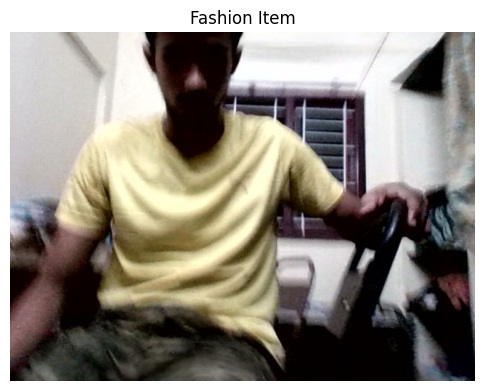

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Running VLM analysis on image...

VLM Analysis Results:
What is the subcategory of this fashion item? Top
What type of article is this fashion item? garment
What is the base color of this fashion item? Yellow
What season is this fashion item designed for? winter
What is the intended usage of this fashion item? Casual

Concise description: given image:     for 

What would you like to know about this fashion item? yes
Loaded configuration from /content/drive/MyDrive/fashion_files/generation_config.json

Would you like to adjust generation parameters? (y/n)
y

===== Generation Configuration =====
Current settings:
  max_new_tokens: 200
  temperature: 0.7
  top_k: 40
  instruction: name: sriram
age: 21
gender: male
location: indi
style: minimalist
occupation: student
preferences: minimalistic, stylish, classy
favorite_colors: navy, beige, white, black
size: m
wardrobe: white button-up shirt, navy trousers, black coat, beige cashmere sweater, white sneakers, black ankle boots, denim jeans

Generating tokens: 100%|██████████| 150/150 [04:14<00:00,  1.70s/it]



=== Fashion Advice ===

Okay, so let's build a versatile and stylish men's outfit around your navy and beige preferences.  We can incorporate your love for white and beige seamlessly, incorporating your love for a "day in" vibe.

Let's start with the white button-up shirt.  It's a timeless piece that can be dressed up or down. Since it’s a "day in" style, it’s perfect for transitioning from work to a casual outing.  Instead of a traditional tie, consider a white linen shirt. Linen breathes well and is perfect for warmer weather.  Look for one with a subtle textured weave to add visual interest. 

Now, let's work with the navy

=== Generation Stats ===
Generated 150 tokens
Personalization: Wardrobe = yes, User Details = no

Press Enter to continue...


===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendation
2. Get fashion advice without image
3. Update user profile
4. Exit
Choose an option (1-4): 4
Thank you for using the Fashion Recommenda

In [ ]:
import os
import zipfile
import torch
import tiktoken
import json
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import drive

# Define paths
MODEL_PATH = "/content/Files"  # Base VLM model path
TRAINED_VLM_PATH = "/content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt"  # Fine-tuned VLM path
LLM_ZIP_PATH = '/content/drive/MyDrive/fashion_files/best_model.zip'  # LLM model zip path
LLM_UNZIP_DESTINATION = '/content/extracted_model/'  # Where to extract LLM model
USER_TEXT_PATH = '/content/drive/MyDrive/fashion_files/user.txt'  # User profile path
CONFIG_PATH = '/content/drive/MyDrive/fashion_files/generation_config.json'  # Generation config path
OUTPUT_DIR = "/content/drive/MyDrive/finetuned_paligemma"  # Output directory

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Default generation parameters (will be overridden by config file if present)
DEFAULT_CONFIG = {
    "max_new_tokens": 150,
    "temperature": 0.7,
    "top_k": 40,
    "instruction": "",
    "input_text": "",
    "consider_wardrobe": "no",  # For personalization
    "consider_user_details": "no"  # For personalization
}

# Ensure directories exist
os.makedirs(LLM_UNZIP_DESTINATION, exist_ok=True)
os.makedirs(os.path.dirname(USER_TEXT_PATH), exist_ok=True)

# PART 1: VLM FUNCTIONS
# -------------------------------------

# Function to capture images from webcam in Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          await new Promise((resolve) => {
            capture.onclick = resolve;
          });

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def load_finetuned_vlm(base_model_path, trained_model_path, device):
    print(f"Loading base VLM model from {base_model_path}")

    # Import model architecture and processor
    # Note: These would need to be properly imported in a real implementation
    # from paligemma import load_hf_model, PaliGemmaProcessor, KVCache

    model, tokenizer = load_hf_model(base_model_path, device)
    if os.path.exists(trained_model_path):
        print(f"Loading fine-tuned VLM weights from {trained_model_path}")
        state_dict = torch.load(trained_model_path, map_location=device)
        model.load_state_dict(state_dict, strict=False)
        print("Successfully loaded fine-tuned VLM weights")
    else:
        print(f"Warning: Fine-tuned VLM model not found at {trained_model_path}. Using base model.")
    model.eval()
    return model, tokenizer

def move_inputs_to_device(model_inputs: dict, device: str):
    return {k: v.to(device) for k, v in model_inputs.items()}

def get_model_inputs(processor, prompt, image, device):
    """Process image (as numpy array or PIL Image) with the processor"""
    if isinstance(image, np.ndarray):
        # Convert OpenCV BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image_rgb)
    else:
        pil_image = image

    model_inputs = processor(text=[prompt], images=[pil_image])
    model_inputs = move_inputs_to_device(model_inputs, device)
    return model_inputs

def generate_vlm_prediction(model, processor, image, prompt, max_tokens=50):
    """Generate prediction for an image (can be PIL Image or numpy array)"""
    model_inputs = get_model_inputs(processor, prompt, image, device)
    input_ids = model_inputs["input_ids"]
    attention_mask = model_inputs["attention_mask"]
    pixel_values = model_inputs["pixel_values"]
    kv_cache = KVCache()
    stop_token = processor.tokenizer.eos_token_id
    generated_tokens = []

    with torch.no_grad():
        for _ in range(max_tokens):
            # Always pass pixel_values for this architecture
            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask,
                kv_cache=kv_cache,
            )
            kv_cache = outputs["kv_cache"]
            next_token_logits = outputs["logits"][:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
            token_id = next_token.item()
            generated_tokens.append(token_id)
            if token_id == stop_token:
                break
            input_ids = next_token
            attention_mask = torch.cat([attention_mask, torch.ones((1, 1), device=device)], dim=-1)

    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
    return generated_text

def process_image_with_vlm(vlm_model, processor, image_path=None, use_webcam=False):
    """Process an image with the VLM and return formatted results"""
    # Define the prompts for the VLM
    prompts = [
        "What is the subcategory of this fashion item?",
        "What type of article is this fashion item?",
        "What is the base color of this fashion item?",
        "What season is this fashion item designed for?",
        "What is the intended usage of this fashion item?"
    ]

    # Get image from webcam or file
    if use_webcam:
        print("Click 'Capture' to take a photo for fashion analysis")
        filename = take_photo()
        print(f"Photo saved as {filename}")
        img = Image.open(filename)
    else:
        # Use provided image path
        if not os.path.exists(image_path):
            print(f"Image not found at {image_path}")
            return None
        img = Image.open(image_path)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Fashion Item")
    plt.show()

    # Process the image with VLM
    print("\nRunning VLM analysis on image...")
    results = {}
    for prompt in prompts:
        prediction = generate_vlm_prediction(vlm_model, processor, img, prompt)
        # Store the result
        key = prompt.replace("What is the ", "").replace("?", "").strip()
        results[key] = prediction

    # Create a concise description
    concise_desc = f"given image: {results.get('intended usage', '').lower()} " \
                  f"{results.get('base color', '').lower()} " \
                  f"{results.get('type of article', '').lower()} " \
                  f"{results.get('subcategory', '').lower()} " \
                  f"for {results.get('season', '').lower()}"

    # Display detailed results
    print("\nVLM Analysis Results:")
    for prompt, result in zip(prompts, results.values()):
        print(f"{prompt} {result}")

    print(f"\nConcise description: {concise_desc}")

    return concise_desc


# PART 2: LLM FUNCTIONS
# -------------------------------------

# Class for parsing and handling user profile data
class UserProfileManager:
    def __init__(self, user_text_path):
        self.user_text_path = user_text_path
        self.user_data = {}
        self.user_wardrobe = []
        self.load_user_data()

    def load_user_data(self):
        """Load and parse user data from user.txt"""
        if not os.path.exists(self.user_text_path):
            print(f"User profile not found at {self.user_text_path}")
            return False

        try:
            with open(self.user_text_path, 'r') as f:
                content = f.read().strip()
                # Parse the user data
                self._parse_user_data(content)
                print(f"Loaded user profile from {self.user_text_path}")
                return True
        except Exception as e:
            print(f"Error loading user profile: {e}")
            return False

    def _parse_user_data(self, content):
        """Parse user data content into structured data"""
        lines = content.split('\n')
        for line in lines:
            # Skip empty lines and lines without a proper key:value format
            if not line.strip() or ':' not in line:
                continue

            parts = line.split(':', 1)
            key = parts[0].strip().lower()
            value = parts[1].strip()

            # Special handling for wardrobe items
            if key == 'wardrobe':
                self.user_wardrobe = [item.strip() for item in value.split(',')]
                self.user_data[key] = self.user_wardrobe
            else:
                self.user_data[key] = value

    def get_user_profile_summary(self):
        """Get a formatted summary of the user profile for the model"""
        if not self.user_data:
            return "No user profile data available."

        summary = []
        # Add basic user information
        for key, value in self.user_data.items():
            if key != 'wardrobe':  # Handle wardrobe separately
                summary.append(f"{key}: {value}")

        return "\n".join(summary)

    def get_wardrobe_summary(self):
        """Get a formatted summary of the user's wardrobe"""
        if not self.user_wardrobe:
            return "No wardrobe information available."

        return "Wardrobe items: " + ", ".join(self.user_wardrobe)

# Function to extract zip with progress tracking
def extract_with_progress(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get file info
        file_info_list = zip_ref.infolist()

        # Set up tqdm progress bar
        with tqdm(total=len(file_info_list), desc="Extracting files") as pbar:
            for file_info in file_info_list:
                zip_ref.extract(file_info, extract_to)
                pbar.update(1)

    print(f"Extraction complete to {extract_to}")
    return os.path.join(extract_to, os.path.basename(zip_path).replace('.zip', '.pt'))

def format_input(instruction, input_text="", consider_wardrobe="no", consider_user_details="no", user_profile=None):
    """Format the instruction and input according to the training format, including personalization options."""
    # Base instruction
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request. "
        f"Do not generate additional inputs or profile information."
        f"\n\n### Instruction:\n{instruction}"
    )

    # Add personalization details if requested
    if user_profile and consider_user_details.lower() == "yes":
        instruction_text += f"\n\nConsider the following user details for personalization:\n{user_profile.get_user_profile_summary()}"

    # Add wardrobe information if requested
    if user_profile and consider_wardrobe.lower() == "yes":
        instruction_text += f"\n\nConsider these items from the user's wardrobe for your suggestions:\n{user_profile.get_wardrobe_summary()}"

    # Add input text if provided
    input_part = f"\n\n### Input:\n{input_text}" if input_text else ""

    return instruction_text + input_part + "\n\n### Response:"

def load_finetuned_llm(checkpoint_path, device):
    """Load the fine-tuned LLM from a checkpoint."""
    print(f"Loading LLM model from {checkpoint_path}")

    # Import your model definitions here
    # from gpt_model import GPTModel, GPT_CONFIG_774M

    # Initialize model with configuration
    model = GPTModel(GPT_CONFIG_774M)

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])

    # Move model to device
    model.to(device)
    model.eval()

    print(f"LLM model loaded successfully! Validation loss: {checkpoint.get('val_loss', 'N/A')}")
    return model

def generate_llm_text(model, tokenizer, prompt, device, max_new_tokens=150, temperature=0.7, top_k=40):
    """Generate text based on a prompt using the fine-tuned LLM."""
    # Tokenize the prompt
    encoded = torch.tensor(tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})).unsqueeze(0).to(device)
    context_size = model.pos_emb.weight.shape[0]

    # Generate response
    model.eval()

    print(f"Generation parameters: max_tokens={max_new_tokens}, temp={temperature}, top_k={top_k}")
    generated_tokens = []

    with torch.no_grad():
        for _ in tqdm(range(max_new_tokens), desc="Generating tokens"):
            # Get context for the current step
            idx_cond = encoded[:, -context_size:]

            # Forward pass
            logits = model(idx_cond)

            # Get logits for the last token
            logits = logits[:, -1, :]

            # Apply temperature and top-k filtering
            if temperature > 0:
                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = float('-inf')

                probs = torch.softmax(logits / temperature, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                # Greedy sampling
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

            # Append new token
            encoded = torch.cat((encoded, idx_next), dim=1)
            generated_tokens.append(idx_next.item())

            # Stop if EOS token is generated (50256 is <|endoftext|>)
            if idx_next.item() == 50256:
                break

            # Also stop if we see "### Input:" - this is a sign the model is hallucinating additional input
            current_text = tokenizer.decode(encoded.squeeze().tolist()[len(tokenizer.encode(prompt)):])
            if "### Input:" in current_text:
                break

    # Decode the generated text
    generated_text = tokenizer.decode(encoded.squeeze().tolist())

    # Return only the response part (after the prompt)
    response = generated_text[len(prompt):]

    # Remove any hallucinated input sections
    if "### Input:" in response:
        response = response.split("### Input:")[0].strip()

    # Remove any hallucinated response markers
    if "### Response:" in response:
        response = response.replace("### Response:", "").strip()

    return response, generated_tokens

def load_user_config():
    """Load user configuration from config file if it exists, otherwise use defaults."""
    config = DEFAULT_CONFIG.copy()

    # Check if config file exists
    if os.path.exists(CONFIG_PATH):
        try:
            with open(CONFIG_PATH, 'r') as f:
                user_config = json.load(f)
                config.update(user_config)
                print(f"Loaded configuration from {CONFIG_PATH}")
        except Exception as e:
            print(f"Error loading config file: {e}")
            print("Using default configuration")
    else:
        print(f"Config file not found at {CONFIG_PATH}. Using default configuration.")
        # Create a template config file for future use
        try:
            with open(CONFIG_PATH, 'w') as f:
                json.dump(DEFAULT_CONFIG, f, indent=4)
                print(f"Created template config file at {CONFIG_PATH}")
        except Exception as e:
            print(f"Failed to create template config file: {e}")

    return config

def update_config_interactive(config):
    """Allow user to interactively update configuration parameters."""
    print("\n===== Generation Configuration =====")
    print("Current settings:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    print("\nEnter new values (press Enter to keep current value):")

    # Update numerical parameters
    for param in ["max_new_tokens", "temperature", "top_k"]:
        new_value = input(f"{param} [{config[param]}]: ")
        if new_value.strip():
            try:
                if param == "max_new_tokens" or param == "top_k":
                    config[param] = int(new_value)
                else:
                    config[param] = float(new_value)
            except ValueError:
                print(f"Invalid value for {param}, keeping current value.")

    # Update personalization parameters
    for param in ["consider_wardrobe", "consider_user_details"]:
        new_value = input(f"{param} [{config[param]}] (yes/no): ")
        if new_value.strip().lower() in ['yes', 'no']:
            config[param] = new_value.lower()

    # Save updated config
    try:
        with open(CONFIG_PATH, 'w') as f:
            json.dump(config, f, indent=4)
            print(f"Configuration saved to {CONFIG_PATH}")
    except Exception as e:
        print(f"Failed to save configuration: {e}")

    return config

# PART 3: USER PROFILE MANAGEMENT
# -------------------------------------

def update_user_profile(user_profile):
    """Interactive function to update user profile data"""
    print("\n===== Update User Profile =====")

    if user_profile.user_data:
        print("Current profile:")
        for key, value in user_profile.user_data.items():
            if key != 'wardrobe':  # Display wardrobe separately
                print(f"  {key}: {value}")

        # Display wardrobe items separately
        if user_profile.user_wardrobe:
            print("Wardrobe items:")
            for i, item in enumerate(user_profile.user_wardrobe, 1):
                print(f"  {i}. {item}")
    else:
        print("No profile data found. Creating new profile.")

    print("\nOptions:")
    print("1. Edit basic profile information")
    print("2. Edit wardrobe items")
    print("3. Cancel")

    choice = input("Choose an option (1-3): ")

    if choice == '1':
        # Edit basic profile info
        print("\nEnter profile information (press Enter to keep current values, 'delete' to remove):")
        fields = ['name', 'age', 'gender', 'location', 'style', 'occupation', 'preferences', 'favorite_colors', 'size']

        updated_data = {}
        for field in fields:
            current = user_profile.user_data.get(field, '')
            new_value = input(f"{field} [{current}]: ")

            if new_value.lower() == 'delete':
                # Don't include this field
                pass
            elif new_value.strip():
                # Update with new value
                updated_data[field] = new_value
            elif field in user_profile.user_data:
                # Keep current value
                updated_data[field] = current

        # Preserve wardrobe data
        if 'wardrobe' in user_profile.user_data:
            updated_data['wardrobe'] = user_profile.user_data['wardrobe']

        # Update user data
        user_profile.user_data = updated_data

        # Save to file
        save_updated_profile(user_profile)

    elif choice == '2':
        # Edit wardrobe items
        print("\nOptions for wardrobe:")
        print("1. Add items")
        print("2. Remove items")
        print("3. Replace all items")
        print("4. Cancel")

        wardrobe_choice = input("Choose an option (1-4): ")

        if wardrobe_choice == '1':
            # Add items
            new_items = input("Enter items to add (comma separated): ")
            items_to_add = [item.strip() for item in new_items.split(',') if item.strip()]

            if 'wardrobe' not in user_profile.user_data:
                user_profile.user_data['wardrobe'] = []
                user_profile.user_wardrobe = []

            user_profile.user_wardrobe.extend(items_to_add)
            user_profile.user_data['wardrobe'] = user_profile.user_wardrobe

            save_updated_profile(user_profile)

        elif wardrobe_choice == '2':
            # Remove items
            if not user_profile.user_wardrobe:
                print("No wardrobe items to remove.")
                return

            print("Current items:")
            for i, item in enumerate(user_profile.user_wardrobe, 1):
                print(f"  {i}. {item}")

            to_remove = input("Enter numbers of items to remove (comma separated): ")
            try:
                indices = [int(idx.strip()) for idx in to_remove.split(',') if idx.strip()]
                # Sort in reverse to avoid index shifting during removal
                indices.sort(reverse=True)

                for idx in indices:
                    if 1 <= idx <= len(user_profile.user_wardrobe):
                        del user_profile.user_wardrobe[idx-1]

                user_profile.user_data['wardrobe'] = user_profile.user_wardrobe
                save_updated_profile(user_profile)

            except ValueError:
                print("Invalid input. Please enter numbers separated by commas.")

        elif wardrobe_choice == '3':
            # Replace all
            new_wardrobe = input("Enter new wardrobe items (comma separated): ")
            new_items = [item.strip() for item in new_wardrobe.split(',') if item.strip()]

            user_profile.user_wardrobe = new_items
            user_profile.user_data['wardrobe'] = new_items

            save_updated_profile(user_profile)

def save_updated_profile(user_profile):
    """Save updated profile to user.txt file"""
    try:
        # Format profile data for saving
        lines = []

        # Add basic profile fields first
        for key, value in user_profile.user_data.items():
            if key != 'wardrobe':  # Handle wardrobe separately
                lines.append(f"{key}: {value}")

        # Add wardrobe at the end
        if user_profile.user_wardrobe:
            lines.append(f"wardrobe: {', '.join(user_profile.user_wardrobe)}")

        # Write to file
        with open(user_profile.user_text_path, 'w') as f:
            f.write('\n'.join(lines))

        print(f"Profile updated and saved to {user_profile.user_text_path}")
        # Reload the profile to ensure everything is up to date
        user_profile.load_user_data()
        return True

    except Exception as e:
        print(f"Error saving profile: {e}")
        return False

# PART 4: INTEGRATED SYSTEM
# -------------------------------------

def run_integrated_fashion_system():
    """Main function to run the integrated fashion recommendation system"""
    # Mount Google Drive if needed
    if not os.path.exists("/content/drive"):
        drive.mount('/content/drive')

    # Step 1: Extract LLM model
    print("\n===== Loading Models =====")
    llm_model_path = extract_with_progress(LLM_ZIP_PATH, LLM_UNZIP_DESTINATION)

    # Step 2: Load tokenizer for LLM
    tokenizer = tiktoken.get_encoding("gpt2")

    # Step 3: Load user profile
    user_profile = UserProfileManager(USER_TEXT_PATH)

    # Check if user profile needs to be created or updated
    if not user_profile.user_data:
        print("No user profile found. Would you like to create one? (y/n)")
        if input().lower() == 'y':
            update_user_profile(user_profile)
    else:
        print("User profile loaded. Would you like to update it? (y/n)")
        if input().lower() == 'y':
            update_user_profile(user_profile)

    # Step 4: Load models
    llm_model = load_finetuned_llm(llm_model_path, device)

    # Main loop
    while True:
        print("\n===== Integrated Fashion Recommendation System =====")
        print("Options:")
        print("1. Use fashion image for recommendation")
        print("2. Get fashion advice without image")
        print("3. Update user profile")
        print("4. Exit")

        option = input("Choose an option (1-4): ")

        if option == '1':
            # Use fashion image
            image_input_type = input("Do you want to (1) use webcam or (2) upload an image file? ")

            image_description = None
            if image_input_type == '1':
                # Load VLM only when needed (since it might be large)
                vlm_model, vlm_tokenizer = load_finetuned_vlm(MODEL_PATH, TRAINED_VLM_PATH, device)
                num_image_tokens = vlm_model.config.vision_config.num_image_tokens
                image_size = vlm_model.config.vision_config.image_size
                processor = PaliGemmaProcessor(vlm_tokenizer, num_image_tokens, image_size)

                # Use webcam
                image_description = process_image_with_vlm(vlm_model, processor, use_webcam=True)
            elif image_input_type == '2':
                # Upload file
                image_path = input("Enter the path to the image file: ")

                # Load VLM only when needed
                vlm_model, vlm_tokenizer = load_finetuned_vlm(MODEL_PATH, TRAINED_VLM_PATH, device)
                num_image_tokens = vlm_model.config.vision_config.num_image_tokens
                image_size = vlm_model.config.vision_config.image_size
                processor = PaliGemmaProcessor(vlm_tokenizer, num_image_tokens, image_size)

                image_description = process_image_with_vlm(vlm_model, processor, image_path=image_path)
            else:
                print("Invalid option. Please try again.")
                continue

            if not image_description:
                print("Failed to analyze image. Please try again.")
                continue

            # Now get instruction from user
            instruction = input("\nWhat would you like to know about this fashion item? ")

            # Load config for LLM generation
            config = load_user_config()

            # Allow user to adjust generation parameters
            print("\nWould you like to adjust generation parameters? (y/n)")
            if input().lower() == 'y':
                config = update_config_interactive(config)

            # Format the instruction with the image description
            combined_input = f"{image_description}\n\n{instruction}"

            # Format the prompt with personalization options
            prompt = format_input(
                instruction,
                combined_input,
                config["consider_wardrobe"],
                config["consider_user_details"],
                user_profile
            )

            # Generate response
            print("\nGenerating fashion advice...")
            response, tokens = generate_llm_text(
                llm_model, tokenizer, prompt, device,
                max_new_tokens=config["max_new_tokens"],
                temperature=config["temperature"],
                top_k=config["top_k"]
            )

            # Display results
            print("\n=== Fashion Advice ===")
            print(response)
            print("\n=== Generation Stats ===")
            print(f"Generated {len(tokens)} tokens")
            print(f"Personalization: Wardrobe = {config['consider_wardrobe']}, User Details = {config['consider_user_details']}")

        elif option == '2':
            # Get fashion advice without image
            # Get fashion advice without image
            instruction = input("\nWhat fashion advice would you like? ")

            # Load config
            config = load_user_config()

            # Allow user to adjust generation parameters
            print("\nWould you like to adjust generation parameters? (y/n)")
            if input().lower() == 'y':
                config = update_config_interactive(config)

            # Optional input text
            input_text = ""  # No additional input for text-only mode

            # Format the prompt with personalization options
            prompt = format_input(
                instruction,
                input_text,
                config["consider_wardrobe"],
                config["consider_user_details"],
                user_profile
            )

            # Generate response
            print("\nGenerating fashion advice...")
            response, tokens = generate_llm_text(
                llm_model, tokenizer, prompt, device,
                max_new_tokens=config["max_new_tokens"],
                temperature=config["temperature"],
                top_k=config["top_k"]
            )

            # Display results
            print("\n=== Fashion Advice ===")
            print(response)
            print("\n=== Generation Stats ===")
            print(f"Generated {len(tokens)} tokens")
            print(f"Personalization: Wardrobe = {config['consider_wardrobe']}, User Details = {config['consider_user_details']}")

        elif option == '3':
            # Update user profile
            update_user_profile(user_profile)

        elif option == '4':
            # Exit
            print("Thank you for using the Fashion Recommendation System. Goodbye!")
            break

        else:
            print("Invalid option. Please try again.")

        # Ask if user wants to continue
        print("\nPress Enter to continue...")
        input()


if __name__ == "__main__":
    run_integrated_fashion_system()

Using device: cpu

===== Initializing Fashion Recommendation System =====
Model already extracted at /content/extracted_model/best_model.pt, skipping extraction
Loading LLM model from /content/extracted_model/best_model.pt


<ipython-input-13-e8bfbf300bb9>:420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


LLM model loaded successfully! Validation loss: 1.2289036760727565
Loaded user profile from /content/drive/MyDrive/fashion_files/user.txt
System initialization complete!
LLM model status: Loaded
User profile status: Loaded

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choose an option (1-5): 1

--- Image-based Fashion Recommendation ---
Select image source:
1. Use webcam
2. Use image file
3. Back to main menu
Choose image source (1-3): 1
Loading base VLM model from /content/Files
Loading fine-tuned VLM weights from /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt


<ipython-input-13-e8bfbf300bb9>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(trained_model_path, map_location=device)


Successfully loaded fine-tuned VLM weights
Click 'Capture' to take a photo for fashion analysis


<IPython.core.display.Javascript object>

Photo saved as photo.jpg


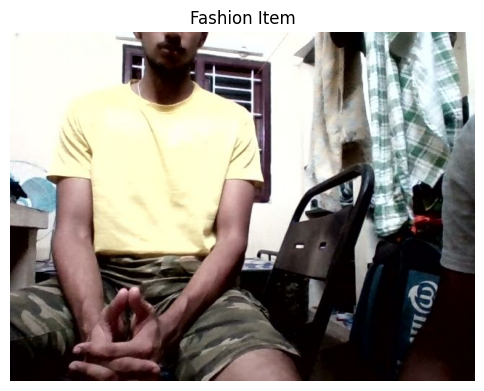

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Running VLM analysis on image...

VLM Analysis Results:
What is the subcategory of this fashion item? Bottom
What type of article is this fashion item? garment
What is the base color of this fashion item? yellow
What season is this fashion item designed for? summer
What is the intended usage of this fashion item? sports

Concise description: given image:     for 

What would you like to know about this fashion item?
Examples:
- How can I style this item?
- What accessories would go well with this?
- Is this appropriate for a business casual setting?
Your query: how can i style this item
Loaded configuration from /content/drive/MyDrive/fashion_files/generation_config.json

Generating recommendation...
Generation parameters: max_tokens=150, temp=0.7, top_k=40


Generating tokens: 100%|██████████| 150/150 [04:53<00:00,  1.96s/it]



--- Fashion Recommendation ---

Given your profile, wardrobe, and the item's style, here’s an idea:  Instead of just shopping, try creating a few outfits incorporating your preferences and building from there.  White button-up shirts, navy trousers, and beige cashmere sweaters are a good starting point.  The darker tones of the items will create a sophisticated look, and the white provides a neutral backdrop.  You can incorporate accessories like a black watch and brown leather ankle boots, but keep the overall look simple with no embellishments.

For your tan skin and olive skin tones,  white is a great base.  Olive skin tones can tan easily, but olive skin tones often look more striking in darker neutrals. 

Press Enter to continue...

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choose an option (1-5): 2

--- Fashion Questio

Generating tokens: 100%|██████████| 150/150 [04:42<00:00,  1.88s/it]



--- Fashion Advice ---

Hey there!  A fashion expert, I see you're a fan of white button-up shirts and navy trousers.  While your current wardrobe doesn't have many of those, I can definitely help you put together some recommendations for a more refined look.  While a full white t-shirt might feel overwhelming, we can build a refined and flattering outfit around it.

For the top, I recommend building a foundation of well-fitting navy trousers.  The contrast between the navy and the beige will create a visually interesting look.  Look for a slim-fit, straight-leg or slightly tapered fit to flatter your build.  A slightly longer, slightly fitted t-shirt is ideal for balancing the proportions. 

Press Enter to continue...

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choose an option (1-5): 2

--- Fashion Question (Text Only) ---


Generating tokens: 100%|██████████| 150/150 [04:27<00:00,  1.79s/it]



--- Fashion Advice ---

Given your preference for a white button-up shirt, navy trousers, and beige cashmere sweaters, and the need for a balanced outfit, here are a few options:

**Option 1:  Classic Navy & Beige**

* **Base:** Start with a navy white button-down shirt.  Leave the top two buttons undone, leaving it slightly open.  Roll the sleeves slightly to show off your handbag.  Since it’s a casual day,  a black or dark grey bandana tied around your neck or neckline adds a touch of personality.
* **Pants:**  Go for well-fitting navy trousers.  A slim fit will showcase your build without being restrictive

Press Enter to continue...

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choose an option (1-5): 2

--- Fashion Question (Text Only) ---
Examples:
- What are the fashion trends for summer 2024?
- How should I build a caps

Generating tokens: 100%|██████████| 150/150 [04:25<00:00,  1.77s/it]



--- Fashion Advice ---

Okay, let's get you looking sharp for the beach!  Your existing wardrobe looks great, but it's a bit too formal for the occasion.  Let's create a beach-appropriate look using your love for white and navy and your love for beige and white sneakers.  Since you mentioned ankle boots, we can definitely work with that.  Ankle boots are a great way to elevate your look and add a bit of height.  A white linen shirt (medium weight linen for breathability and comfort) will provide a classic and summery vibe.  Pair it with navy pants and a beige linen blazer for a cool, summery vibe.  Since you're 5'2" and a size medium, it will

Press Enter to continue...

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choose an option (1-5): 4
Loaded configuration from /content/drive/MyDrive/fashion_files/generation_config.json

=

Generating tokens: 100%|██████████| 150/150 [03:05<00:00,  1.23s/it]



--- Fashion Advice ---

Given your request for summer clothing to complement your coloring and warm skin tone, we'll need to create some interesting and stylish outfits.  We can incorporate your preferences with confidence.

I recommend starting with a lightweight, breathable linen shirt in shades of yellow and orange. Linen is perfect for summer as it's naturally temperature-regulating and naturally renewable.  A light yellow linen shirt will complement your coloring beautifully.  Since you love orange and yellow, let's work with that.  A light orange linen blazer would look fantastic.  While a full orange one might be too bold for summer, we can incorporate orange accents subtly.  Instead of a full orange blazer, consider a light yellow shirt with a subtle orange pa

Press Enter to continue...

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation param

In [ ]:
import os
import zipfile
import torch
import tiktoken
import json
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import drive

# Define paths
MODEL_PATH = "/content/Files"  # Base VLM model path
TRAINED_VLM_PATH = "/content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt"  # Fine-tuned VLM path
LLM_ZIP_PATH = '/content/drive/MyDrive/fashion_files/best_model.zip'  # LLM model zip path
LLM_UNZIP_DESTINATION = '/content/extracted_model/'  # Where to extract LLM model
USER_TEXT_PATH = '/content/drive/MyDrive/fashion_files/user.txt'  # User profile path
CONFIG_PATH = '/content/drive/MyDrive/fashion_files/generation_config.json'  # Generation config path
OUTPUT_DIR = "/content/drive/MyDrive/finetuned_paligemma"  # Output directory

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Global variables for model caching
vlm_model = None
processor = None
llm_model = None
tokenizer = None
user_profile = None

# Default generation parameters (will be overridden by config file if present)
DEFAULT_CONFIG = {
    "max_new_tokens": 150,
    "temperature": 0.7,
    "top_k": 40,
    "instruction": "",
    "input_text": "",
    "consider_wardrobe": "no",  # For personalization
    "consider_user_details": "no"  # For personalization
}

# Ensure directories exist
os.makedirs(LLM_UNZIP_DESTINATION, exist_ok=True)
os.makedirs(os.path.dirname(USER_TEXT_PATH), exist_ok=True)

# PART 1: VLM FUNCTIONS
# -------------------------------------

# Function to capture images from webcam in Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          await new Promise((resolve) => {
            capture.onclick = resolve;
          });

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def load_finetuned_vlm(base_model_path, trained_model_path, device):
    global vlm_model, processor

    # Check if model is already loaded
    if vlm_model is not None and processor is not None:
        print("VLM model already loaded, reusing...")
        return vlm_model, processor

    print(f"Loading base VLM model from {base_model_path}")

    try:
        # Import model architecture and processor
        # Note: These would need to be properly imported in a real implementation


        model, tokenizer = load_hf_model(base_model_path, device)

        # Check if fine-tuned weights exist
        if os.path.exists(trained_model_path):
            print(f"Loading fine-tuned VLM weights from {trained_model_path}")
            state_dict = torch.load(trained_model_path, map_location=device)
            model.load_state_dict(state_dict, strict=False)
            print("Successfully loaded fine-tuned VLM weights")
        else:
            print(f"Warning: Fine-tuned VLM model not found at {trained_model_path}. Using base model.")

        model.eval()

        # Initialize processor
        num_image_tokens = model.config.vision_config.num_image_tokens
        image_size = model.config.vision_config.image_size
        processor = PaliGemmaProcessor(tokenizer, num_image_tokens, image_size)

        # Cache for future use
        vlm_model = model
        return model, processor

    except ImportError as e:
        print(f"Error importing required modules: {e}")
        print("Please ensure you have the required packages installed.")
        return None, None
    except Exception as e:
        print(f"Error loading VLM model: {e}")
        return None, None

def move_inputs_to_device(model_inputs: dict, device: str):
    return {k: v.to(device) for k, v in model_inputs.items()}

def get_model_inputs(processor, prompt, image, device):
    """Process image (as numpy array or PIL Image) with the processor"""
    if isinstance(image, np.ndarray):
        # Convert OpenCV BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image_rgb)
    else:
        pil_image = image

    model_inputs = processor(text=[prompt], images=[pil_image])
    model_inputs = move_inputs_to_device(model_inputs, device)
    return model_inputs

def generate_vlm_prediction(model, processor, image, prompt, max_tokens=50):
    """Generate prediction for an image (can be PIL Image or numpy array)"""
    try:
        # Import KVCache if not already available

        model_inputs = get_model_inputs(processor, prompt, image, device)
        input_ids = model_inputs["input_ids"]
        attention_mask = model_inputs["attention_mask"]
        pixel_values = model_inputs["pixel_values"]
        kv_cache = KVCache()
        stop_token = processor.tokenizer.eos_token_id
        generated_tokens = []

        with torch.no_grad():
            for _ in range(max_tokens):
                # Always pass pixel_values for this architecture
                outputs = model(
                    input_ids=input_ids,
                    pixel_values=pixel_values,
                    attention_mask=attention_mask,
                    kv_cache=kv_cache,
                )
                kv_cache = outputs["kv_cache"]
                next_token_logits = outputs["logits"][:, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
                token_id = next_token.item()
                generated_tokens.append(token_id)
                if token_id == stop_token:
                    break
                input_ids = next_token
                attention_mask = torch.cat([attention_mask, torch.ones((1, 1), device=device)], dim=-1)

        generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
        return generated_text
    except Exception as e:
        print(f"Error in VLM prediction: {e}")
        return "Error analyzing image"

def process_image_with_vlm(image_path=None, use_webcam=False):
    """Process an image with the VLM and return formatted results"""
    global vlm_model, processor

    # Check if model is loaded
    if vlm_model is None or processor is None:
        vlm_model, processor = load_finetuned_vlm(MODEL_PATH, TRAINED_VLM_PATH, device)
        if vlm_model is None or processor is None:
            return None, None

    # Define the prompts for the VLM
    prompts = [
        "What is the subcategory of this fashion item?",
        "What type of article is this fashion item?",
        "What is the base color of this fashion item?",
        "What season is this fashion item designed for?",
        "What is the intended usage of this fashion item?"
    ]

    # Get image from webcam or file
    if use_webcam:
        print("Click 'Capture' to take a photo for fashion analysis")
        filename = take_photo()
        print(f"Photo saved as {filename}")
        img = Image.open(filename)
    else:
        # Use provided image path
        if not os.path.exists(image_path):
            print(f"Image not found at {image_path}")
            return None, None
        img = Image.open(image_path)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Fashion Item")
    plt.show()

    # Process the image with VLM
    print("\nRunning VLM analysis on image...")
    results = {}
    raw_img = img  # Keep a copy of the raw image for potential future use

    for prompt in prompts:
        prediction = generate_vlm_prediction(vlm_model, processor, img, prompt)
        # Store the result
        key = prompt.replace("What is the ", "").replace("?", "").strip()
        results[key] = prediction

    # Create a concise description
    concise_desc = f"given image: {results.get('intended usage', '').lower()} " \
                  f"{results.get('base color', '').lower()} " \
                  f"{results.get('type of article', '').lower()} " \
                  f"{results.get('subcategory', '').lower()} " \
                  f"for {results.get('season', '').lower()}"

    # Display detailed results
    print("\nVLM Analysis Results:")
    for prompt, result in zip(prompts, results.values()):
        print(f"{prompt} {result}")

    print(f"\nConcise description: {concise_desc}")

    # Return both the concise description and the detailed results dictionary
    return concise_desc, results


# PART 2: LLM FUNCTIONS
# -------------------------------------

# Class for parsing and handling user profile data
class UserProfileManager:
    def __init__(self, user_text_path):
        self.user_text_path = user_text_path
        self.user_data = {}
        self.user_wardrobe = []
        self.load_user_data()

    def load_user_data(self):
        """Load and parse user data from user.txt"""
        if not os.path.exists(self.user_text_path):
            print(f"User profile not found at {self.user_text_path}")
            return False

        try:
            with open(self.user_text_path, 'r') as f:
                content = f.read().strip()
                # Parse the user data
                self._parse_user_data(content)
                print(f"Loaded user profile from {self.user_text_path}")
                return True
        except Exception as e:
            print(f"Error loading user profile: {e}")
            return False

    def _parse_user_data(self, content):
        """Parse user data content into structured data"""
        lines = content.split('\n')
        for line in lines:
            # Skip empty lines and lines without a proper key:value format
            if not line.strip() or ':' not in line:
                continue

            parts = line.split(':', 1)
            key = parts[0].strip().lower()
            value = parts[1].strip()

            # Special handling for wardrobe items
            if key == 'wardrobe':
                self.user_wardrobe = [item.strip() for item in value.split(',')]
                self.user_data[key] = self.user_wardrobe
            else:
                self.user_data[key] = value

    def get_user_profile_summary(self):
        """Get a formatted summary of the user profile for the model"""
        if not self.user_data:
            return "No user profile data available."

        summary = []
        # Add basic user information
        for key, value in self.user_data.items():
            if key != 'wardrobe':  # Handle wardrobe separately
                summary.append(f"{key}: {value}")

        return "\n".join(summary)

    def get_wardrobe_summary(self):
        """Get a formatted summary of the user's wardrobe"""
        if not self.user_wardrobe:
            return "No wardrobe information available."

        return "Wardrobe items: " + ", ".join(self.user_wardrobe)

# Function to extract zip with progress tracking
def extract_with_progress(zip_path, extract_to):
    # Check if model is already extracted
    expected_model_path = os.path.join(extract_to, os.path.basename(zip_path).replace('.zip', '.pt'))
    if os.path.exists(expected_model_path):
        print(f"Model already extracted at {expected_model_path}, skipping extraction")
        return expected_model_path

    if not os.path.exists(zip_path):
        print(f"Error: Model zip file not found at {zip_path}")
        return None

    print(f"Extracting model from {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get file info
        file_info_list = zip_ref.infolist()

        # Set up tqdm progress bar
        with tqdm(total=len(file_info_list), desc="Extracting files") as pbar:
            for file_info in file_info_list:
                zip_ref.extract(file_info, extract_to)
                pbar.update(1)

    print(f"Extraction complete to {extract_to}")
    return expected_model_path

def format_input(instruction, input_text="", consider_wardrobe="no", consider_user_details="no", user_profile=None, image_features=None):
    """Format the instruction and input according to the training format, including personalization options and image features."""
    # Base instruction
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request. "
        f"Do not generate additional inputs or profile information."
        f"\n\n### Instruction:\n{instruction}"
    )

    # Add personalization details if requested
    if user_profile and consider_user_details.lower() == "yes":
        instruction_text += f"\n\nConsider the following user details for personalization:\n{user_profile.get_user_profile_summary()}"

    # Add wardrobe information if requested
    if user_profile and consider_wardrobe.lower() == "yes":
        instruction_text += f"\n\nConsider these items from the user's wardrobe for your suggestions:\n{user_profile.get_wardrobe_summary()}"

    # Add input text if provided
    if input_text:
        # Format with image features if available
        if image_features:
            # Create detailed description from image features
            details = []
            if "subcategory" in image_features:
                details.append(f"Subcategory: {image_features['subcategory']}")
            if "type of article" in image_features:
                details.append(f"Type: {image_features['type of article']}")
            if "base color" in image_features:
                details.append(f"Color: {image_features['base color']}")
            if "season" in image_features:
                details.append(f"Season: {image_features['season']}")
            if "intended usage" in image_features:
                details.append(f"Usage: {image_features['intended usage']}")

            feature_details = "\n".join(details)
            input_text = f"Image Analysis:\n{feature_details}\n\nUser Query: {input_text}"

    input_part = f"\n\n### Input:\n{input_text}" if input_text else ""

    return instruction_text + input_part + "\n\n### Response:"

def load_finetuned_llm(checkpoint_path, device):
    """Load the fine-tuned LLM from a checkpoint."""
    global llm_model

    # Check if model is already loaded
    if llm_model is not None:
        print("LLM model already loaded, reusing...")
        return llm_model

    if not os.path.exists(checkpoint_path):
        print(f"Error: LLM checkpoint not found at {checkpoint_path}")
        return None

    print(f"Loading LLM model from {checkpoint_path}")

    try:
        # Import your model definitions here
        # Initialize model with configuration
        model = GPTModel(GPT_CONFIG_774M)

        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])

        # Move model to device
        model.to(device)
        model.eval()

        print(f"LLM model loaded successfully! Validation loss: {checkpoint.get('val_loss', 'N/A')}")

        # Cache for future use
        llm_model = model
        return model
    except ImportError as e:
        print(f"Error importing required modules: {e}")
        print("Please ensure you have the required packages installed.")
        return None
    except Exception as e:
        print(f"Error loading LLM model: {e}")
        return None

def generate_llm_text(model, tokenizer, prompt, device, max_new_tokens=150, temperature=0.7, top_k=40):
    """Generate text based on a prompt using the fine-tuned LLM."""
    if model is None:
        print("Error: LLM model not loaded properly")
        return "Model not available. Please check the console for errors.", []

    # Tokenize the prompt
    encoded = torch.tensor(tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})).unsqueeze(0).to(device)
    context_size = model.pos_emb.weight.shape[0]

    # Generate response
    model.eval()

    print(f"Generation parameters: max_tokens={max_new_tokens}, temp={temperature}, top_k={top_k}")
    generated_tokens = []

    with torch.no_grad():
        for _ in tqdm(range(max_new_tokens), desc="Generating tokens"):
            # Get context for the current step
            idx_cond = encoded[:, -context_size:]

            # Forward pass
            logits = model(idx_cond)

            # Get logits for the last token
            logits = logits[:, -1, :]

            # Apply temperature and top-k filtering
            if temperature > 0:
                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = float('-inf')

                probs = torch.softmax(logits / temperature, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                # Greedy sampling
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

            # Append new token
            encoded = torch.cat((encoded, idx_next), dim=1)
            generated_tokens.append(idx_next.item())

            # Stop if EOS token is generated (50256 is <|endoftext|>)
            if idx_next.item() == 50256:
                break

            # Also stop if we see "### Input:" - this is a sign the model is hallucinating additional input
            current_text = tokenizer.decode(encoded.squeeze().tolist()[len(tokenizer.encode(prompt)):])
            if "### Input:" in current_text:
                break

    # Decode the generated text
    generated_text = tokenizer.decode(encoded.squeeze().tolist())

    # Return only the response part (after the prompt)
    response = generated_text[len(prompt):]

    # Remove any hallucinated input sections
    if "### Input:" in response:
        response = response.split("### Input:")[0].strip()

    # Remove any hallucinated response markers
    if "### Response:" in response:
        response = response.replace("### Response:", "").strip()

    return response, generated_tokens

def load_user_config():
    """Load user configuration from config file if it exists, otherwise use defaults."""
    config = DEFAULT_CONFIG.copy()

    # Check if config file exists
    if os.path.exists(CONFIG_PATH):
        try:
            with open(CONFIG_PATH, 'r') as f:
                user_config = json.load(f)
                config.update(user_config)
                print(f"Loaded configuration from {CONFIG_PATH}")
        except Exception as e:
            print(f"Error loading config file: {e}")
            print("Using default configuration")
    else:
        print(f"Config file not found at {CONFIG_PATH}. Using default configuration.")
        # Create a template config file for future use
        try:
            with open(CONFIG_PATH, 'w') as f:
                json.dump(DEFAULT_CONFIG, f, indent=4)
                print(f"Created template config file at {CONFIG_PATH}")
        except Exception as e:
            print(f"Failed to create template config file: {e}")

    return config

def update_config_interactive(config):
    """Allow user to interactively update configuration parameters."""
    print("\n===== Generation Configuration =====")
    print("Current settings:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    print("\nEnter new values (press Enter to keep current value):")

    # Update numerical parameters
    for param in ["max_new_tokens", "temperature", "top_k"]:
        new_value = input(f"{param} [{config[param]}]: ")
        if new_value.strip():
            try:
                if param == "max_new_tokens" or param == "top_k":
                    config[param] = int(new_value)
                else:
                    config[param] = float(new_value)
            except ValueError:
                print(f"Invalid value for {param}, keeping current value.")

    # Update personalization parameters
    for param in ["consider_wardrobe", "consider_user_details"]:
        new_value = input(f"{param} [{config[param]}] (yes/no): ")
        if new_value.strip().lower() in ['yes', 'no']:
            config[param] = new_value.lower()

    # Save updated config
    try:
        with open(CONFIG_PATH, 'w') as f:
            json.dump(config, f, indent=4)
            print(f"Configuration saved to {CONFIG_PATH}")
    except Exception as e:
        print(f"Failed to save configuration: {e}")

    return config

# PART 3: USER PROFILE MANAGEMENT
# -------------------------------------

def update_user_profile(user_profile):
    """Interactive function to update user profile data"""
    print("\n===== Update User Profile =====")

    if user_profile.user_data:
        print("Current profile:")
        for key, value in user_profile.user_data.items():
            if key != 'wardrobe':  # Display wardrobe separately
                print(f"  {key}: {value}")

        # Display wardrobe items separately
        if user_profile.user_wardrobe:
            print("Wardrobe items:")
            for i, item in enumerate(user_profile.user_wardrobe, 1):
                print(f"  {i}. {item}")
    else:
        print("No profile data found. Creating new profile.")

    print("\nOptions:")
    print("1. Edit basic profile information")
    print("2. Edit wardrobe items")
    print("3. Cancel")

    choice = input("Choose an option (1-3): ")

    if choice == '1':
        # Edit basic profile info
        print("\nEnter profile information (press Enter to keep current values, 'delete' to remove):")
        fields = ['name', 'age', 'gender', 'location', 'style', 'occupation', 'preferences', 'favorite_colors', 'size']

        updated_data = {}
        for field in fields:
            current = user_profile.user_data.get(field, '')
            new_value = input(f"{field} [{current}]: ")

            if new_value.lower() == 'delete':
                # Don't include this field
                pass
            elif new_value.strip():
                # Update with new value
                updated_data[field] = new_value
            elif field in user_profile.user_data:
                # Keep current value
                updated_data[field] = current

        # Preserve wardrobe data
        if 'wardrobe' in user_profile.user_data:
            updated_data['wardrobe'] = user_profile.user_data['wardrobe']

        # Update user data
        user_profile.user_data = updated_data

        # Save to file
        save_updated_profile(user_profile)

    elif choice == '2':
        # Edit wardrobe items
        print("\nOptions for wardrobe:")
        print("1. Add items")
        print("2. Remove items")
        print("3. Replace all items")
        print("4. Cancel")

        wardrobe_choice = input("Choose an option (1-4): ")

        if wardrobe_choice == '1':
            # Add items
            new_items = input("Enter items to add (comma separated): ")
            items_to_add = [item.strip() for item in new_items.split(',') if item.strip()]

            if 'wardrobe' not in user_profile.user_data:
                user_profile.user_data['wardrobe'] = []
                user_profile.user_wardrobe = []

            user_profile.user_wardrobe.extend(items_to_add)
            user_profile.user_data['wardrobe'] = user_profile.user_wardrobe

            save_updated_profile(user_profile)

        elif wardrobe_choice == '2':
            # Remove items
            if not user_profile.user_wardrobe:
                print("No wardrobe items to remove.")
                return

            print("Current items:")
            for i, item in enumerate(user_profile.user_wardrobe, 1):
                print(f"  {i}. {item}")

            to_remove = input("Enter numbers of items to remove (comma separated): ")
            try:
                indices = [int(idx.strip()) for idx in to_remove.split(',') if idx.strip()]
                # Sort in reverse to avoid index shifting during removal
                indices.sort(reverse=True)

                for idx in indices:
                    if 1 <= idx <= len(user_profile.user_wardrobe):
                        del user_profile.user_wardrobe[idx-1]

                user_profile.user_data['wardrobe'] = user_profile.user_wardrobe
                save_updated_profile(user_profile)

            except ValueError:
                print("Invalid input. Please enter numbers separated by commas.")

        elif wardrobe_choice == '3':
            # Replace all
            new_wardrobe = input("Enter new wardrobe items (comma separated): ")
            new_items = [item.strip() for item in new_wardrobe.split(',') if item.strip()]

            user_profile.user_wardrobe = new_items
            user_profile.user_data['wardrobe'] = new_items

            save_updated_profile(user_profile)

def save_updated_profile(user_profile):
    """Save updated profile to user.txt file"""
    try:
        # Format profile data for saving
        lines = []

        # Add basic profile fields first
        for key, value in user_profile.user_data.items():
            if key != 'wardrobe':  # Handle wardrobe separately
                lines.append(f"{key}: {value}")

        # Add wardrobe at the end
        if user_profile.user_wardrobe:
            lines.append(f"wardrobe: {', '.join(user_profile.user_wardrobe)}")

        # Write to file
        with open(user_profile.user_text_path, 'w') as f:
            f.write('\n'.join(lines))

        print(f"Profile updated and saved to {user_profile.user_text_path}")
        # Reload the profile to ensure everything is up to date
        user_profile.load_user_data()
        return True

    except Exception as e:
        print(f"Error saving profile: {e}")
        return False

# PART 4: INITIALIZATION AND SYSTEM STARTUP
# -------------------------------------

def initialize_system():
    """Initialize the system - load models and user profile"""
    global llm_model, tokenizer, user_profile

    print("\n===== Initializing Fashion Recommendation System =====")

    # Mount Google Drive if needed
    if not os.path.exists("/content/drive"):
        print("Mounting Google Drive...")
        drive.mount('/content/drive')

    # Extract and load LLM model
    llm_model_path = extract_with_progress(LLM_ZIP_PATH, LLM_UNZIP_DESTINATION)
    if llm_model_path:
        llm_model = load_finetuned_llm(llm_model_path, device)

    # Load tokenizer for LLM
    tokenizer = tiktoken.get_encoding("gpt2")

    # Load user profile
    user_profile = UserProfileManager(USER_TEXT_PATH)

    # Check if user profile needs to be created
    if not user_profile.user_data:
        print("No user profile found. Would you like to create one? (y/n)")
        if input().lower() == 'y':
            update_user_profile(user_profile)

    print("System initialization complete!")
    print(f"LLM model status: {'Loaded' if llm_model else 'Not loaded'}")
    print(f"User profile status: {'Loaded' if user_profile.user_data else 'Not loaded'}")

    return llm_model is not None

# PART 5: INTEGRATED SYSTEM
# -------------------------------------

def run_integrated_fashion_system():
    """Main function to run the integrated fashion recommendation system"""
    # Initialize system first
    if not initialize_system():
        print("Error initializing system. Please check the error messages above.")
        return

    # Main loop
    while True:
        print("\n===== Integrated Fashion Recommendation System =====")
        print("Options:")
        print("1. Use fashion image for recommendations")
        print("2. Ask fashion question (text only)")
        print("3. Update user profile")
        print("4. Configure generation parameters")
        print("5. Exit")

        choice = input("Choose an option (1-5): ")

        if choice == '1':
            # Image-based fashion recommendation
            print("\n--- Image-based Fashion Recommendation ---")
            print("Select image source:")
            print("1. Use webcam")
            print("2. Use image file")
            print("3. Back to main menu")

            img_choice = input("Choose image source (1-3): ")

            if img_choice == '1':
                # Use webcam
                image_desc, image_features = process_image_with_vlm(use_webcam=True)
            elif img_choice == '2':
                # Use image file
                image_path = input("Enter path to image file: ")
                image_desc, image_features = process_image_with_vlm(image_path=image_path)
            else:
                continue

            if not image_desc or not image_features:
                print("Failed to analyze image. Please try again.")
                continue

            # Ask for specific query about the fashion item
            print("\nWhat would you like to know about this fashion item?")
            print("Examples:")
            print("- How can I style this item?")
            print("- What accessories would go well with this?")
            print("- Is this appropriate for a business casual setting?")

            query = input("Your query: ")

            # Load user config
            config = load_user_config()

            # Format instruction for LLM
            instruction = "You are a fashion expert. Provide detailed and helpful advice about the fashion item shown in the image based on the user's query."
            input_text = f"{image_desc}. {query}"

            # Generate formatted input
            formatted_input = format_input(
                instruction,
                input_text,
                config['consider_wardrobe'],
                config['consider_user_details'],
                user_profile,
                image_features
            )

            # Generate response
            print("\nGenerating recommendation...")

            response, _ = generate_llm_text(
                llm_model,
                tokenizer,
                formatted_input,
                device,
                max_new_tokens=config['max_new_tokens'],
                temperature=config['temperature'],
                top_k=config['top_k']
            )

            print("\n--- Fashion Recommendation ---")
            print(response)

            input("\nPress Enter to continue...")

        elif choice == '2':
            # Text-only fashion question
            print("\n--- Fashion Question (Text Only) ---")
            print("Examples:")
            print("- What are the fashion trends for summer 2024?")
            print("- How should I build a capsule wardrobe?")
            print("- What colors work well with navy blue?")

            query = input("Your fashion question: ")

            # Load user config
            config = load_user_config()

            # Format instruction for LLM
            instruction = "You are a fashion expert. Provide detailed and helpful advice about fashion based on the user's query."

            # Generate formatted input
            formatted_input = format_input(
                instruction,
                query,
                config['consider_wardrobe'],
                config['consider_user_details'],
                user_profile
            )

            # Generate response
            print("\nGenerating response...")

            response, _ = generate_llm_text(
                llm_model,
                tokenizer,
                formatted_input,
                device,
                max_new_tokens=config['max_new_tokens'],
                temperature=config['temperature'],
                top_k=config['top_k']
            )

            print("\n--- Fashion Advice ---")
            print(response)

            input("\nPress Enter to continue...")

        elif choice == '3':
            # Update user profile
            update_user_profile(user_profile)
            input("\nPress Enter to continue...")

        elif choice == '4':
            # Configure generation parameters
            config = load_user_config()
            config = update_config_interactive(config)
            input("\nPress Enter to continue...")

        elif choice == '5':
            # Exit
            print("Thank you for using the Fashion Recommendation System!")
            break

        else:
            print("Invalid choice. Please try again.")

# PART 6: MAIN PROGRAM
# -------------------------------------

if __name__ == "__main__":
    run_integrated_fashion_system()

Using device: cpu

===== Initializing Fashion Recommendation System =====
Model already extracted at /content/extracted_model/best_model.pt, skipping extraction
Loading LLM model from /content/extracted_model/best_model.pt


<ipython-input-7-fd90e767728d>:420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


LLM model loaded successfully! Validation loss: 1.2289036760727565
Loaded user profile from /content/drive/MyDrive/fashion_files/user.txt
System initialization complete!
LLM model status: Loaded
User profile status: Loaded

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choose an option (1-5): 1

--- Image-based Fashion Recommendation ---
Select image source:
1. Use webcam
2. Use image file
3. Back to main menu
Choose image source (1-3): 1
Loading base VLM model from /content/Files
Loading fine-tuned VLM weights from /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt


<ipython-input-7-fd90e767728d>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(trained_model_path, map_location=device)


Successfully loaded fine-tuned VLM weights
Click 'Capture' to take a photo for fashion analysis


<IPython.core.display.Javascript object>

Photo saved as photo.jpg


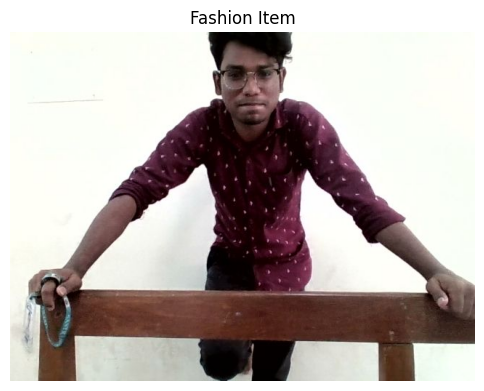

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Running VLM analysis on image...

VLM Analysis Results:
What is the subcategory of this fashion item? shirts
What type of article is this fashion item? garment
What is the base color of this fashion item? maroon
What season is this fashion item designed for? summer
What is the intended usage of this fashion item? casual

Concise description: given image:     for 

What would you like to know about this fashion item?
Examples:
- How can I style this item?
- What accessories would go well with this?
- Is this appropriate for a business casual setting?
Your query: Im going for a date, suggest me a pants for this fashion item
Loaded configuration from /content/drive/MyDrive/fashion_files/generation_config.json

Generating recommendation...
Generation parameters: max_tokens=150, temp=0.7, top_k=40


Generating tokens: 100%|██████████| 150/150 [05:37<00:00,  2.25s/it]



--- Fashion Recommendation ---

Given your request for pants for a date, I'm assuming you like the look and want to wear them.  While a specific garment like a skirt is not quite right for this occasion, we can build an understanding of what to look for and how to incorporate it.

Since you're a fashion expert, I can definitely guide you toward a look that makes you feel confident and comfortable.

For a date, a flowy, flowy skirt in a neutral color like black or grey would look fantastic.  The flowiness will complement your figure beautifully, while the neutral color keeps it sophisticated.  Look for a skirt with a slightly flared or A-line cut, which will emphasize your waist and create a flattering silhouette. The

Press Enter to continue...

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choose an option (1-5): 5
Thank you fo

In [ ]:
import os
import zipfile
import torch
import tiktoken
import json
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import drive

# Define paths
MODEL_PATH = "/content/Files"  # Base VLM model path
TRAINED_VLM_PATH = "/content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt"  # Fine-tuned VLM path
LLM_ZIP_PATH = '/content/drive/MyDrive/fashion_files/best_model.zip'  # LLM model zip path
LLM_UNZIP_DESTINATION = '/content/extracted_model/'  # Where to extract LLM model
USER_TEXT_PATH = '/content/drive/MyDrive/fashion_files/user.txt'  # User profile path
CONFIG_PATH = '/content/drive/MyDrive/fashion_files/generation_config.json'  # Generation config path
OUTPUT_DIR = "/content/drive/MyDrive/finetuned_paligemma"  # Output directory

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Global variables for model caching
vlm_model = None
processor = None
llm_model = None
tokenizer = None
user_profile = None

# Default generation parameters (will be overridden by config file if present)
DEFAULT_CONFIG = {
    "max_new_tokens": 150,
    "temperature": 0.7,
    "top_k": 40,
    "instruction": "",
    "input_text": "",
    "consider_wardrobe": "no",  # For personalization
    "consider_user_details": "no"  # For personalization
}

# Ensure directories exist
os.makedirs(LLM_UNZIP_DESTINATION, exist_ok=True)
os.makedirs(os.path.dirname(USER_TEXT_PATH), exist_ok=True)

# PART 1: VLM FUNCTIONS
# -------------------------------------

# Function to capture images from webcam in Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          await new Promise((resolve) => {
            capture.onclick = resolve;
          });

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def load_finetuned_vlm(base_model_path, trained_model_path, device):
    global vlm_model, processor

    # Check if model is already loaded
    if vlm_model is not None and processor is not None:
        print("VLM model already loaded, reusing...")
        return vlm_model, processor

    print(f"Loading base VLM model from {base_model_path}")

    try:
        # Import model architecture and processor
        # Note: These would need to be properly imported in a real implementation


        model, tokenizer = load_hf_model(base_model_path, device)

        # Check if fine-tuned weights exist
        if os.path.exists(trained_model_path):
            print(f"Loading fine-tuned VLM weights from {trained_model_path}")
            state_dict = torch.load(trained_model_path, map_location=device)
            model.load_state_dict(state_dict, strict=False)
            print("Successfully loaded fine-tuned VLM weights")
        else:
            print(f"Warning: Fine-tuned VLM model not found at {trained_model_path}. Using base model.")

        model.eval()

        # Initialize processor
        num_image_tokens = model.config.vision_config.num_image_tokens
        image_size = model.config.vision_config.image_size
        processor = PaliGemmaProcessor(tokenizer, num_image_tokens, image_size)

        # Cache for future use
        vlm_model = model
        return model, processor

    except ImportError as e:
        print(f"Error importing required modules: {e}")
        print("Please ensure you have the required packages installed.")
        return None, None
    except Exception as e:
        print(f"Error loading VLM model: {e}")
        return None, None

def move_inputs_to_device(model_inputs: dict, device: str):
    return {k: v.to(device) for k, v in model_inputs.items()}

def get_model_inputs(processor, prompt, image, device):
    """Process image (as numpy array or PIL Image) with the processor"""
    if isinstance(image, np.ndarray):
        # Convert OpenCV BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image_rgb)
    else:
        pil_image = image

    model_inputs = processor(text=[prompt], images=[pil_image])
    model_inputs = move_inputs_to_device(model_inputs, device)
    return model_inputs

def generate_vlm_prediction(model, processor, image, prompt, max_tokens=50):
    """Generate prediction for an image (can be PIL Image or numpy array)"""
    try:
        # Import KVCache if not already available

        model_inputs = get_model_inputs(processor, prompt, image, device)
        input_ids = model_inputs["input_ids"]
        attention_mask = model_inputs["attention_mask"]
        pixel_values = model_inputs["pixel_values"]
        kv_cache = KVCache()
        stop_token = processor.tokenizer.eos_token_id
        generated_tokens = []

        with torch.no_grad():
            for _ in range(max_tokens):
                # Always pass pixel_values for this architecture
                outputs = model(
                    input_ids=input_ids,
                    pixel_values=pixel_values,
                    attention_mask=attention_mask,
                    kv_cache=kv_cache,
                )
                kv_cache = outputs["kv_cache"]
                next_token_logits = outputs["logits"][:, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
                token_id = next_token.item()
                generated_tokens.append(token_id)
                if token_id == stop_token:
                    break
                input_ids = next_token
                attention_mask = torch.cat([attention_mask, torch.ones((1, 1), device=device)], dim=-1)

        generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
        return generated_text
    except Exception as e:
        print(f"Error in VLM prediction: {e}")
        return "Error analyzing image"

def process_image_with_vlm(image_path=None, use_webcam=False):
    """Process an image with the VLM and return formatted results"""
    global vlm_model, processor

    # Check if model is loaded
    if vlm_model is None or processor is None:
        vlm_model, processor = load_finetuned_vlm(MODEL_PATH, TRAINED_VLM_PATH, device)
        if vlm_model is None or processor is None:
            return None, None

    # Define the prompts for the VLM
    prompts = [
        "What is the subcategory of this fashion item?",
        "What type of article is this fashion item?",
        "What is the base color of this fashion item?",
        "What season is this fashion item designed for?",
        "What is the intended usage of this fashion item?"
    ]

    # Get image from webcam or file
    if use_webcam:
        print("Click 'Capture' to take a photo for fashion analysis")
        filename = take_photo()
        print(f"Photo saved as {filename}")
        img = Image.open(filename)
    else:
        # Use provided image path
        if not os.path.exists(image_path):
            print(f"Image not found at {image_path}")
            return None, None
        img = Image.open(image_path)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Fashion Item")
    plt.show()

    # Process the image with VLM
    print("\nRunning VLM analysis on image...")
    results = {}
    raw_img = img  # Keep a copy of the raw image for potential future use

    for prompt in prompts:
        prediction = generate_vlm_prediction(vlm_model, processor, img, prompt)
        # Store the result
        key = prompt.replace("What is the ", "").replace("?", "").strip()
        results[key] = prediction

    # Create a concise description
    concise_desc = f"given image: {results.get('intended usage', '').lower()} " \
                  f"{results.get('base color', '').lower()} " \
                  f"{results.get('type of article', '').lower()} " \
                  f"{results.get('subcategory', '').lower()} " \
                  f"for {results.get('season', '').lower()}"

    # Display detailed results
    print("\nVLM Analysis Results:")
    for prompt, result in zip(prompts, results.values()):
        print(f"{prompt} {result}")

    print(f"\nConcise description: {concise_desc}")

    # Return both the concise description and the detailed results dictionary
    return concise_desc, results


# PART 2: LLM FUNCTIONS
# -------------------------------------

# Class for parsing and handling user profile data
class UserProfileManager:
    def __init__(self, user_text_path):
        self.user_text_path = user_text_path
        self.user_data = {}
        self.user_wardrobe = []
        self.load_user_data()

    def load_user_data(self):
        """Load and parse user data from user.txt"""
        if not os.path.exists(self.user_text_path):
            print(f"User profile not found at {self.user_text_path}")
            return False

        try:
            with open(self.user_text_path, 'r') as f:
                content = f.read().strip()
                # Parse the user data
                self._parse_user_data(content)
                print(f"Loaded user profile from {self.user_text_path}")
                return True
        except Exception as e:
            print(f"Error loading user profile: {e}")
            return False

    def _parse_user_data(self, content):
        """Parse user data content into structured data"""
        lines = content.split('\n')
        for line in lines:
            # Skip empty lines and lines without a proper key:value format
            if not line.strip() or ':' not in line:
                continue

            parts = line.split(':', 1)
            key = parts[0].strip().lower()
            value = parts[1].strip()

            # Special handling for wardrobe items
            if key == 'wardrobe':
                self.user_wardrobe = [item.strip() for item in value.split(',')]
                self.user_data[key] = self.user_wardrobe
            else:
                self.user_data[key] = value

    def get_user_profile_summary(self):
        """Get a formatted summary of the user profile for the model"""
        if not self.user_data:
            return "No user profile data available."

        summary = []
        # Add basic user information
        for key, value in self.user_data.items():
            if key != 'wardrobe':  # Handle wardrobe separately
                summary.append(f"{key}: {value}")

        return "\n".join(summary)

    def get_wardrobe_summary(self):
        """Get a formatted summary of the user's wardrobe"""
        if not self.user_wardrobe:
            return "No wardrobe information available."

        return "Wardrobe items: " + ", ".join(self.user_wardrobe)

# Function to extract zip with progress tracking
def extract_with_progress(zip_path, extract_to):
    # Check if model is already extracted
    expected_model_path = os.path.join(extract_to, os.path.basename(zip_path).replace('.zip', '.pt'))
    if os.path.exists(expected_model_path):
        print(f"Model already extracted at {expected_model_path}, skipping extraction")
        return expected_model_path

    if not os.path.exists(zip_path):
        print(f"Error: Model zip file not found at {zip_path}")
        return None

    print(f"Extracting model from {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get file info
        file_info_list = zip_ref.infolist()

        # Set up tqdm progress bar
        with tqdm(total=len(file_info_list), desc="Extracting files") as pbar:
            for file_info in file_info_list:
                zip_ref.extract(file_info, extract_to)
                pbar.update(1)

    print(f"Extraction complete to {extract_to}")
    return expected_model_path

def format_input(instruction, input_text="", consider_wardrobe="no", consider_user_details="no", user_profile=None, image_features=None):
    """Format the instruction and input according to the training format, including personalization options and image features."""
    # Base instruction
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request. "
        f"Do not generate additional inputs or profile information."
        f"\n\n### Instruction:\n{instruction}"
    )

    # Add personalization details if requested
    if user_profile and consider_user_details.lower() == "yes":
        instruction_text += f"\n\nConsider the following user details for personalization:\n{user_profile.get_user_profile_summary()}"

    # Add wardrobe information if requested
    if user_profile and consider_wardrobe.lower() == "yes":
        instruction_text += f"\n\nConsider these items from the user's wardrobe for your suggestions:\n{user_profile.get_wardrobe_summary()}"

    # Add input text if provided
    if input_text:
        # Format with image features if available
        if image_features:
            # Create detailed description from image features
            details = []
            if "subcategory" in image_features:
                details.append(f"Subcategory: {image_features['subcategory']}")
            if "type of article" in image_features:
                details.append(f"Type: {image_features['type of article']}")
            if "base color" in image_features:
                details.append(f"Color: {image_features['base color']}")
            if "season" in image_features:
                details.append(f"Season: {image_features['season']}")
            if "intended usage" in image_features:
                details.append(f"Usage: {image_features['intended usage']}")

            feature_details = "\n".join(details)
            input_text = f"Image Analysis:\n{feature_details}\n\nUser Query: {input_text}"

    input_part = f"\n\n### Input:\n{input_text}" if input_text else ""

    return instruction_text + input_part + "\n\n### Response:"

def load_finetuned_llm(checkpoint_path, device):
    """Load the fine-tuned LLM from a checkpoint."""
    global llm_model

    # Check if model is already loaded
    if llm_model is not None:
        print("LLM model already loaded, reusing...")
        return llm_model

    if not os.path.exists(checkpoint_path):
        print(f"Error: LLM checkpoint not found at {checkpoint_path}")
        return None

    print(f"Loading LLM model from {checkpoint_path}")

    try:
        # Import your model definitions here
        # Initialize model with configuration
        model = GPTModel(GPT_CONFIG_774M)

        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])

        # Move model to device
        model.to(device)
        model.eval()

        print(f"LLM model loaded successfully! Validation loss: {checkpoint.get('val_loss', 'N/A')}")

        # Cache for future use
        llm_model = model
        return model
    except ImportError as e:
        print(f"Error importing required modules: {e}")
        print("Please ensure you have the required packages installed.")
        return None
    except Exception as e:
        print(f"Error loading LLM model: {e}")
        return None

def generate_llm_text(model, tokenizer, prompt, device, max_new_tokens=150, temperature=0.7, top_k=40):
    """Generate text based on a prompt using the fine-tuned LLM."""
    if model is None:
        print("Error: LLM model not loaded properly")
        return "Model not available. Please check the console for errors.", []

    # Tokenize the prompt
    encoded = torch.tensor(tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})).unsqueeze(0).to(device)
    context_size = model.pos_emb.weight.shape[0]

    # Generate response
    model.eval()

    print(f"Generation parameters: max_tokens={max_new_tokens}, temp={temperature}, top_k={top_k}")
    generated_tokens = []

    with torch.no_grad():
        for _ in tqdm(range(max_new_tokens), desc="Generating tokens"):
            # Get context for the current step
            idx_cond = encoded[:, -context_size:]

            # Forward pass
            logits = model(idx_cond)

            # Get logits for the last token
            logits = logits[:, -1, :]

            # Apply temperature and top-k filtering
            if temperature > 0:
                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = float('-inf')

                probs = torch.softmax(logits / temperature, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                # Greedy sampling
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

            # Append new token
            encoded = torch.cat((encoded, idx_next), dim=1)
            generated_tokens.append(idx_next.item())

            # Stop if EOS token is generated (50256 is <|endoftext|>)
            if idx_next.item() == 50256:
                break

            # Also stop if we see "### Input:" - this is a sign the model is hallucinating additional input
            current_text = tokenizer.decode(encoded.squeeze().tolist()[len(tokenizer.encode(prompt)):])
            if "### Input:" in current_text:
                break

    # Decode the generated text
    generated_text = tokenizer.decode(encoded.squeeze().tolist())

    # Return only the response part (after the prompt)
    response = generated_text[len(prompt):]

    # Remove any hallucinated input sections
    if "### Input:" in response:
        response = response.split("### Input:")[0].strip()

    # Remove any hallucinated response markers
    if "### Response:" in response:
        response = response.replace("### Response:", "").strip()

    return response, generated_tokens

def load_user_config():
    """Load user configuration from config file if it exists, otherwise use defaults."""
    config = DEFAULT_CONFIG.copy()

    # Check if config file exists
    if os.path.exists(CONFIG_PATH):
        try:
            with open(CONFIG_PATH, 'r') as f:
                user_config = json.load(f)
                config.update(user_config)
                print(f"Loaded configuration from {CONFIG_PATH}")
        except Exception as e:
            print(f"Error loading config file: {e}")
            print("Using default configuration")
    else:
        print(f"Config file not found at {CONFIG_PATH}. Using default configuration.")
        # Create a template config file for future use
        try:
            with open(CONFIG_PATH, 'w') as f:
                json.dump(DEFAULT_CONFIG, f, indent=4)
                print(f"Created template config file at {CONFIG_PATH}")
        except Exception as e:
            print(f"Failed to create template config file: {e}")

    return config

def update_config_interactive(config):
    """Allow user to interactively update configuration parameters."""
    print("\n===== Generation Configuration =====")
    print("Current settings:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    print("\nEnter new values (press Enter to keep current value):")

    # Update numerical parameters
    for param in ["max_new_tokens", "temperature", "top_k"]:
        new_value = input(f"{param} [{config[param]}]: ")
        if new_value.strip():
            try:
                if param == "max_new_tokens" or param == "top_k":
                    config[param] = int(new_value)
                else:
                    config[param] = float(new_value)
            except ValueError:
                print(f"Invalid value for {param}, keeping current value.")

    # Update personalization parameters
    for param in ["consider_wardrobe", "consider_user_details"]:
        new_value = input(f"{param} [{config[param]}] (yes/no): ")
        if new_value.strip().lower() in ['yes', 'no']:
            config[param] = new_value.lower()

    # Save updated config
    try:
        with open(CONFIG_PATH, 'w') as f:
            json.dump(config, f, indent=4)
            print(f"Configuration saved to {CONFIG_PATH}")
    except Exception as e:
        print(f"Failed to save configuration: {e}")

    return config

# PART 3: USER PROFILE MANAGEMENT
# -------------------------------------

def update_user_profile(user_profile):
    """Interactive function to update user profile data"""
    print("\n===== Update User Profile =====")

    if user_profile.user_data:
        print("Current profile:")
        for key, value in user_profile.user_data.items():
            if key != 'wardrobe':  # Display wardrobe separately
                print(f"  {key}: {value}")

        # Display wardrobe items separately
        if user_profile.user_wardrobe:
            print("Wardrobe items:")
            for i, item in enumerate(user_profile.user_wardrobe, 1):
                print(f"  {i}. {item}")
    else:
        print("No profile data found. Creating new profile.")

    print("\nOptions:")
    print("1. Edit basic profile information")
    print("2. Edit wardrobe items")
    print("3. Cancel")

    choice = input("Choose an option (1-3): ")

    if choice == '1':
        # Edit basic profile info
        print("\nEnter profile information (press Enter to keep current values, 'delete' to remove):")
        fields = ['name', 'age', 'gender', 'location', 'style', 'occupation', 'preferences', 'favorite_colors', 'size']

        updated_data = {}
        for field in fields:
            current = user_profile.user_data.get(field, '')
            new_value = input(f"{field} [{current}]: ")

            if new_value.lower() == 'delete':
                # Don't include this field
                pass
            elif new_value.strip():
                # Update with new value
                updated_data[field] = new_value
            elif field in user_profile.user_data:
                # Keep current value
                updated_data[field] = current

        # Preserve wardrobe data
        if 'wardrobe' in user_profile.user_data:
            updated_data['wardrobe'] = user_profile.user_data['wardrobe']

        # Update user data
        user_profile.user_data = updated_data

        # Save to file
        save_updated_profile(user_profile)

    elif choice == '2':
        # Edit wardrobe items
        print("\nOptions for wardrobe:")
        print("1. Add items")
        print("2. Remove items")
        print("3. Replace all items")
        print("4. Cancel")

        wardrobe_choice = input("Choose an option (1-4): ")

        if wardrobe_choice == '1':
            # Add items
            new_items = input("Enter items to add (comma separated): ")
            items_to_add = [item.strip() for item in new_items.split(',') if item.strip()]

            if 'wardrobe' not in user_profile.user_data:
                user_profile.user_data['wardrobe'] = []
                user_profile.user_wardrobe = []

            user_profile.user_wardrobe.extend(items_to_add)
            user_profile.user_data['wardrobe'] = user_profile.user_wardrobe

            save_updated_profile(user_profile)

        elif wardrobe_choice == '2':
            # Remove items
            if not user_profile.user_wardrobe:
                print("No wardrobe items to remove.")
                return

            print("Current items:")
            for i, item in enumerate(user_profile.user_wardrobe, 1):
                print(f"  {i}. {item}")

            to_remove = input("Enter numbers of items to remove (comma separated): ")
            try:
                indices = [int(idx.strip()) for idx in to_remove.split(',') if idx.strip()]
                # Sort in reverse to avoid index shifting during removal
                indices.sort(reverse=True)

                for idx in indices:
                    if 1 <= idx <= len(user_profile.user_wardrobe):
                        del user_profile.user_wardrobe[idx-1]

                user_profile.user_data['wardrobe'] = user_profile.user_wardrobe
                save_updated_profile(user_profile)

            except ValueError:
                print("Invalid input. Please enter numbers separated by commas.")

        elif wardrobe_choice == '3':
            # Replace all
            new_wardrobe = input("Enter new wardrobe items (comma separated): ")
            new_items = [item.strip() for item in new_wardrobe.split(',') if item.strip()]

            user_profile.user_wardrobe = new_items
            user_profile.user_data['wardrobe'] = new_items

            save_updated_profile(user_profile)

def save_updated_profile(user_profile):
    """Save updated profile to user.txt file"""
    try:
        # Format profile data for saving
        lines = []

        # Add basic profile fields first
        for key, value in user_profile.user_data.items():
            if key != 'wardrobe':  # Handle wardrobe separately
                lines.append(f"{key}: {value}")

        # Add wardrobe at the end
        if user_profile.user_wardrobe:
            lines.append(f"wardrobe: {', '.join(user_profile.user_wardrobe)}")

        # Write to file
        with open(user_profile.user_text_path, 'w') as f:
            f.write('\n'.join(lines))

        print(f"Profile updated and saved to {user_profile.user_text_path}")
        # Reload the profile to ensure everything is up to date
        user_profile.load_user_data()
        return True

    except Exception as e:
        print(f"Error saving profile: {e}")
        return False

# PART 4: INITIALIZATION AND SYSTEM STARTUP
# -------------------------------------

def initialize_system():
    """Initialize the system - load models and user profile"""
    global llm_model, tokenizer, user_profile

    print("\n===== Initializing Fashion Recommendation System =====")

    # Mount Google Drive if needed
    if not os.path.exists("/content/drive"):
        print("Mounting Google Drive...")
        drive.mount('/content/drive')

    # Extract and load LLM model
    llm_model_path = extract_with_progress(LLM_ZIP_PATH, LLM_UNZIP_DESTINATION)
    if llm_model_path:
        llm_model = load_finetuned_llm(llm_model_path, device)

    # Load tokenizer for LLM
    tokenizer = tiktoken.get_encoding("gpt2")

    # Load user profile
    user_profile = UserProfileManager(USER_TEXT_PATH)

    # Check if user profile needs to be created
    if not user_profile.user_data:
        print("No user profile found. Would you like to create one? (y/n)")
        if input().lower() == 'y':
            update_user_profile(user_profile)

    print("System initialization complete!")
    print(f"LLM model status: {'Loaded' if llm_model else 'Not loaded'}")
    print(f"User profile status: {'Loaded' if user_profile.user_data else 'Not loaded'}")

    return llm_model is not None

# PART 5: INTEGRATED SYSTEM
# -------------------------------------

def run_integrated_fashion_system():
    """Main function to run the integrated fashion recommendation system"""
    # Initialize system first
    if not initialize_system():
        print("Error initializing system. Please check the error messages above.")
        return

    # Main loop
    while True:
        print("\n===== Integrated Fashion Recommendation System =====")
        print("Options:")
        print("1. Use fashion image for recommendations")
        print("2. Ask fashion question (text only)")
        print("3. Update user profile")
        print("4. Configure generation parameters")
        print("5. Exit")

        choice = input("Choose an option (1-5): ")

        if choice == '1':
            # Image-based fashion recommendation
            print("\n--- Image-based Fashion Recommendation ---")
            print("Select image source:")
            print("1. Use webcam")
            print("2. Use image file")
            print("3. Back to main menu")

            img_choice = input("Choose image source (1-3): ")

            if img_choice == '1':
                # Use webcam
                image_desc, image_features = process_image_with_vlm(use_webcam=True)
            elif img_choice == '2':
                # Use image file
                image_path = input("Enter path to image file: ")
                image_desc, image_features = process_image_with_vlm(image_path=image_path)
            else:
                continue

            if not image_desc or not image_features:
                print("Failed to analyze image. Please try again.")
                continue

            # Ask for specific query about the fashion item
            print("\nWhat would you like to know about this fashion item?")
            print("Examples:")
            print("- How can I style this item?")
            print("- What accessories would go well with this?")
            print("- Is this appropriate for a business casual setting?")

            query = input("Your query: ")

            # Load user config
            config = load_user_config()

            # Format instruction for LLM
            instruction = "You are a fashion expert. Provide detailed and helpful advice about the fashion item shown in the image based on the user's query."
            input_text = f"{image_desc}. {query}"

            # Generate formatted input
            formatted_input = format_input(
                instruction,
                input_text,
                config['consider_wardrobe'],
                config['consider_user_details'],
                user_profile,
                image_features
            )

            # Generate response
            print("\nGenerating recommendation...")

            response, _ = generate_llm_text(
                llm_model,
                tokenizer,
                formatted_input,
                device,
                max_new_tokens=config['max_new_tokens'],
                temperature=config['temperature'],
                top_k=config['top_k']
            )

            print("\n--- Fashion Recommendation ---")
            print(response)

            input("\nPress Enter to continue...")

        elif choice == '2':
            # Text-only fashion question
            print("\n--- Fashion Question (Text Only) ---")
            print("Examples:")
            print("- What are the fashion trends for summer 2024?")
            print("- How should I build a capsule wardrobe?")
            print("- What colors work well with navy blue?")

            query = input("Your fashion question: ")

            # Load user config
            config = load_user_config()

            # Format instruction for LLM
            instruction = "You are a fashion expert. Provide detailed and helpful advice about fashion based on the user's query."

            # Generate formatted input
            formatted_input = format_input(
                instruction,
                query,
                config['consider_wardrobe'],
                config['consider_user_details'],
                user_profile
            )

            # Generate response
            print("\nGenerating response...")

            response, _ = generate_llm_text(
                llm_model,
                tokenizer,
                formatted_input,
                device,
                max_new_tokens=config['max_new_tokens'],
                temperature=config['temperature'],
                top_k=config['top_k']
            )

            print("\n--- Fashion Advice ---")
            print(response)

            input("\nPress Enter to continue...")

        elif choice == '3':
            # Update user profile
            update_user_profile(user_profile)
            input("\nPress Enter to continue...")

        elif choice == '4':
            # Configure generation parameters
            config = load_user_config()
            config = update_config_interactive(config)
            input("\nPress Enter to continue...")

        elif choice == '5':
            # Exit
            print("Thank you for using the Fashion Recommendation System!")
            break

        else:
            print("Invalid choice. Please try again.")

# PART 6: MAIN PROGRAM
# -------------------------------------

if __name__ == "__main__":
    run_integrated_fashion_system()

Using device: cpu

===== Initializing Fashion Recommendation System =====
Model already extracted at /content/extracted_model/best_model.pt, skipping extraction
Loading LLM model from /content/extracted_model/best_model.pt


<ipython-input-9-df16c4fab76d>:421: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


LLM model loaded successfully! Validation loss: 1.2289036760727565
Loaded user profile from /content/drive/MyDrive/fashion_files/user.txt
System initialization complete!
LLM model status: Loaded
User profile status: Loaded

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choose an option (1-5): 1

--- Image-based Fashion Recommendation ---
Select image source:
1. Use webcam
2. Use image file
3. Back to main menu
Choose image source (1-3): 1
Loading base VLM model from /content/Files
Loading fine-tuned VLM weights from /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt


<ipython-input-9-df16c4fab76d>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(trained_model_path, map_location=device)


Successfully loaded fine-tuned VLM weights
Click 'Capture' to take a photo for fashion analysis


<IPython.core.display.Javascript object>

Photo saved as photo.jpg


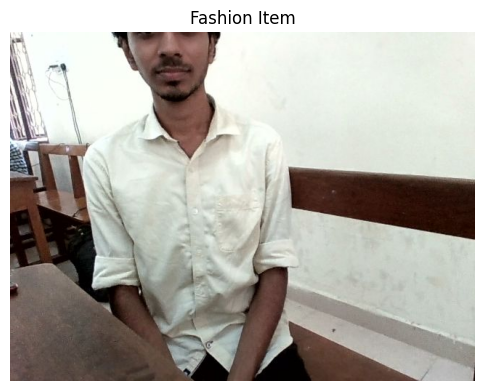

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Running VLM analysis on image...

VLM Analysis Results:
What is the subcategory of this fashion item? shirts
What type of article is this fashion item? garment
What is the base color of this fashion item? White
What season is this fashion item designed for? summer
What is the intended usage of this fashion item? Formal

Concise description: given image: formal white  shirts for 

What would you like to know about this fashion item?
Examples:
- How can I style this item?
- What accessories would go well with this?
- Is this appropriate for a business casual setting?
Your query: suggest me a pants for the given fashion item for men
Loaded configuration from /content/drive/MyDrive/fashion_files/generation_config.json

Generating recommendation...
Generation parameters: max_tokens=150, temp=0.7, top_k=40


Generating tokens: 100%|██████████| 150/150 [05:28<00:00,  2.19s/it]



--- Fashion Recommendation ---

Given your request for formal white shirts, I'm going to recommend something a bit more subtle than the typical black or dark navy.  A deep teal or emerald green would be fantastic.  

For the shirt, I'd suggest a slightly flared, A-line or empire waist cut.  This gives a more relaxed, yet still refined feel.  Given the formality of the occasion, a slightly longer A-line would be perfect.  A slightly shorter empire waist will flatter a taller frame.  

Since you're a fashion expert, I'm confident you'll help me pick a great color for the shirt, even if you don't have a specific color or style.  Let's imagine you

Press Enter to continue...

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choose an option (1-5): 5
Thank you for using the Fashion Recommendation System!


In [ ]:
 import os
import zipfile
import torch
import tiktoken
import json
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import drive

# Define paths
MODEL_PATH = "/content/Files"  # Base VLM model path
TRAINED_VLM_PATH = "/content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt"  # Fine-tuned VLM path
LLM_ZIP_PATH = '/content/drive/MyDrive/fashion_files/best_model.zip'  # LLM model zip path
LLM_UNZIP_DESTINATION = '/content/extracted_model/'  # Where to extract LLM model
USER_TEXT_PATH = '/content/drive/MyDrive/fashion_files/user.txt'  # User profile path
CONFIG_PATH = '/content/drive/MyDrive/fashion_files/generation_config.json'  # Generation config path
OUTPUT_DIR = "/content/drive/MyDrive/finetuned_paligemma"  # Output directory

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Global variables for model caching
vlm_model = None
processor = None
llm_model = None
tokenizer = None
user_profile = None

# Default generation parameters (will be overridden by config file if present)
DEFAULT_CONFIG = {
    "max_new_tokens": 150,
    "temperature": 0.7,
    "top_k": 40,
    "instruction": "",
    "input_text": "",
    "consider_wardrobe": "no",  # For personalization
    "consider_user_details": "no"  # For personalization
}

# Ensure directories exist
os.makedirs(LLM_UNZIP_DESTINATION, exist_ok=True)
os.makedirs(os.path.dirname(USER_TEXT_PATH), exist_ok=True)

# PART 1: VLM FUNCTIONS
# -------------------------------------

# Function to capture images from webcam in Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          await new Promise((resolve) => {
            capture.onclick = resolve;
          });

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def load_finetuned_vlm(base_model_path, trained_model_path, device):
    global vlm_model, processor

    # Check if model is already loaded
    if vlm_model is not None and processor is not None:
        print("VLM model already loaded, reusing...")
        return vlm_model, processor

    print(f"Loading base VLM model from {base_model_path}")

    try:
        # Import model architecture and processor
        # Note: These would need to be properly imported in a real implementation


        model, tokenizer = load_hf_model(base_model_path, device)

        # Check if fine-tuned weights exist
        if os.path.exists(trained_model_path):
            print(f"Loading fine-tuned VLM weights from {trained_model_path}")
            state_dict = torch.load(trained_model_path, map_location=device)
            model.load_state_dict(state_dict, strict=False)
            print("Successfully loaded fine-tuned VLM weights")
        else:
            print(f"Warning: Fine-tuned VLM model not found at {trained_model_path}. Using base model.")

        model.eval()

        # Initialize processor
        num_image_tokens = model.config.vision_config.num_image_tokens
        image_size = model.config.vision_config.image_size
        processor = PaliGemmaProcessor(tokenizer, num_image_tokens, image_size)

        # Cache for future use
        vlm_model = model
        return model, processor

    except ImportError as e:
        print(f"Error importing required modules: {e}")
        print("Please ensure you have the required packages installed.")
        return None, None
    except Exception as e:
        print(f"Error loading VLM model: {e}")
        return None, None

def move_inputs_to_device(model_inputs: dict, device: str):
    return {k: v.to(device) for k, v in model_inputs.items()}

def get_model_inputs(processor, prompt, image, device):
    """Process image (as numpy array or PIL Image) with the processor"""
    if isinstance(image, np.ndarray):
        # Convert OpenCV BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image_rgb)
    else:
        pil_image = image

    model_inputs = processor(text=[prompt], images=[pil_image])
    model_inputs = move_inputs_to_device(model_inputs, device)
    return model_inputs

def generate_vlm_prediction(model, processor, image, prompt, max_tokens=50):
    """Generate prediction for an image (can be PIL Image or numpy array)"""
    try:
        # Import KVCache if not already available

        model_inputs = get_model_inputs(processor, prompt, image, device)
        input_ids = model_inputs["input_ids"]
        attention_mask = model_inputs["attention_mask"]
        pixel_values = model_inputs["pixel_values"]
        kv_cache = KVCache()
        stop_token = processor.tokenizer.eos_token_id
        generated_tokens = []

        with torch.no_grad():
            for _ in range(max_tokens):
                # Always pass pixel_values for this architecture
                outputs = model(
                    input_ids=input_ids,
                    pixel_values=pixel_values,
                    attention_mask=attention_mask,
                    kv_cache=kv_cache,
                )
                kv_cache = outputs["kv_cache"]
                next_token_logits = outputs["logits"][:, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
                token_id = next_token.item()
                generated_tokens.append(token_id)
                if token_id == stop_token:
                    break
                input_ids = next_token
                attention_mask = torch.cat([attention_mask, torch.ones((1, 1), device=device)], dim=-1)

        generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
        return generated_text
    except Exception as e:
        print(f"Error in VLM prediction: {e}")
        return "Error analyzing image"

def process_image_with_vlm(image_path=None, use_webcam=False):
    """Process an image with the VLM and return formatted results"""
    global vlm_model, processor

    # Check if model is loaded
    if vlm_model is None or processor is None:
        vlm_model, processor = load_finetuned_vlm(MODEL_PATH, TRAINED_VLM_PATH, device)
        if vlm_model is None or processor is None:
            return None, None

    # Define the prompts for the VLM
    prompts = [
        "What is the subcategory of this fashion item?",
        "What type of article is this fashion item?",
        "What is the base color of this fashion item?",
        "What season is this fashion item designed for?",
        "What is the intended usage of this fashion item?"
    ]

    # Get image from webcam or file
    if use_webcam:
        print("Click 'Capture' to take a photo for fashion analysis")
        filename = take_photo()
        print(f"Photo saved as {filename}")
        img = Image.open(filename)
    else:
        # Use provided image path
        if not os.path.exists(image_path):
            print(f"Image not found at {image_path}")
            return None, None
        img = Image.open(image_path)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Fashion Item")
    plt.show()

    # Process the image with VLM
    print("\nRunning VLM analysis on image...")
    results = {}
    raw_img = img  # Keep a copy of the raw image for potential future use

    for prompt in prompts:
        prediction = generate_vlm_prediction(vlm_model, processor, img, prompt)
        # Extract a simpler key name
        raw_key = prompt.replace("What is the ", "").replace("?", "").strip()
        simple_key = raw_key.split(" of this fashion item")[0].strip()
        results[simple_key] = prediction

    # Use the simplified keys in the concise description
    concise_desc = f"given image: {results.get('intended usage', '').lower()} " \
                  f"{results.get('base color', '').lower()} " \
                  f"{results.get('type', '').lower()} " \
                  f"{results.get('subcategory', '').lower()} " \
                  f"for {results.get('season', '').lower()}"

    # Display detailed results
    print("\nVLM Analysis Results:")
    for prompt, result in zip(prompts, results.values()):
        print(f"{prompt} {result}")

    print(f"\nConcise description: {concise_desc}")

    # Return both the concise description and the detailed results dictionary
    return concise_desc, results


# PART 2: LLM FUNCTIONS
# -------------------------------------

# Class for parsing and handling user profile data
class UserProfileManager:
    def __init__(self, user_text_path):
        self.user_text_path = user_text_path
        self.user_data = {}
        self.user_wardrobe = []
        self.load_user_data()

    def load_user_data(self):
        """Load and parse user data from user.txt"""
        if not os.path.exists(self.user_text_path):
            print(f"User profile not found at {self.user_text_path}")
            return False

        try:
            with open(self.user_text_path, 'r') as f:
                content = f.read().strip()
                # Parse the user data
                self._parse_user_data(content)
                print(f"Loaded user profile from {self.user_text_path}")
                return True
        except Exception as e:
            print(f"Error loading user profile: {e}")
            return False

    def _parse_user_data(self, content):
        """Parse user data content into structured data"""
        lines = content.split('\n')
        for line in lines:
            # Skip empty lines and lines without a proper key:value format
            if not line.strip() or ':' not in line:
                continue

            parts = line.split(':', 1)
            key = parts[0].strip().lower()
            value = parts[1].strip()

            # Special handling for wardrobe items
            if key == 'wardrobe':
                self.user_wardrobe = [item.strip() for item in value.split(',')]
                self.user_data[key] = self.user_wardrobe
            else:
                self.user_data[key] = value

    def get_user_profile_summary(self):
        """Get a formatted summary of the user profile for the model"""
        if not self.user_data:
            return "No user profile data available."

        summary = []
        # Add basic user information
        for key, value in self.user_data.items():
            if key != 'wardrobe':  # Handle wardrobe separately
                summary.append(f"{key}: {value}")

        return "\n".join(summary)

    def get_wardrobe_summary(self):
        """Get a formatted summary of the user's wardrobe"""
        if not self.user_wardrobe:
            return "No wardrobe information available."

        return "Wardrobe items: " + ", ".join(self.user_wardrobe)

# Function to extract zip with progress tracking
def extract_with_progress(zip_path, extract_to):
    # Check if model is already extracted
    expected_model_path = os.path.join(extract_to, os.path.basename(zip_path).replace('.zip', '.pt'))
    if os.path.exists(expected_model_path):
        print(f"Model already extracted at {expected_model_path}, skipping extraction")
        return expected_model_path

    if not os.path.exists(zip_path):
        print(f"Error: Model zip file not found at {zip_path}")
        return None

    print(f"Extracting model from {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get file info
        file_info_list = zip_ref.infolist()

        # Set up tqdm progress bar
        with tqdm(total=len(file_info_list), desc="Extracting files") as pbar:
            for file_info in file_info_list:
                zip_ref.extract(file_info, extract_to)
                pbar.update(1)

    print(f"Extraction complete to {extract_to}")
    return expected_model_path

def format_input(instruction, input_text="", consider_wardrobe="no", consider_user_details="no", user_profile=None, image_features=None):
    """Format the instruction and input according to the training format, including personalization options and image features."""
    # Base instruction
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request. "
        f"Do not generate additional inputs or profile information."
        f"\n\n### Instruction:\n{instruction}"
    )

    # Add personalization details if requested
    if user_profile and consider_user_details.lower() == "yes":
        instruction_text += f"\n\nConsider the following user details for personalization:\n{user_profile.get_user_profile_summary()}"

    # Add wardrobe information if requested
    if user_profile and consider_wardrobe.lower() == "yes":
        instruction_text += f"\n\nConsider these items from the user's wardrobe for your suggestions:\n{user_profile.get_wardrobe_summary()}"

    # Add input text if provided
    if input_text:
        # Format with image features if available
        if image_features:
            # Create detailed description from image features
            details = []
            if "subcategory" in image_features:
                details.append(f"Subcategory: {image_features['subcategory']}")
            if "type of article" in image_features:
                details.append(f"Type: {image_features['type of article']}")
            if "base color" in image_features:
                details.append(f"Color: {image_features['base color']}")
            if "season" in image_features:
                details.append(f"Season: {image_features['season']}")
            if "intended usage" in image_features:
                details.append(f"Usage: {image_features['intended usage']}")

            feature_details = "\n".join(details)
            input_text = f"Image Analysis:\n{feature_details}\n\nUser Query: {input_text}"

    input_part = f"\n\n### Input:\n{input_text}" if input_text else ""

    return instruction_text + input_part + "\n\n### Response:"

def load_finetuned_llm(checkpoint_path, device):
    """Load the fine-tuned LLM from a checkpoint."""
    global llm_model

    # Check if model is already loaded
    if llm_model is not None:
        print("LLM model already loaded, reusing...")
        return llm_model

    if not os.path.exists(checkpoint_path):
        print(f"Error: LLM checkpoint not found at {checkpoint_path}")
        return None

    print(f"Loading LLM model from {checkpoint_path}")

    try:
        # Import your model definitions here
        # Initialize model with configuration
        model = GPTModel(GPT_CONFIG_774M)

        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])

        # Move model to device
        model.to(device)
        model.eval()

        print(f"LLM model loaded successfully! Validation loss: {checkpoint.get('val_loss', 'N/A')}")

        # Cache for future use
        llm_model = model
        return model
    except ImportError as e:
        print(f"Error importing required modules: {e}")
        print("Please ensure you have the required packages installed.")
        return None
    except Exception as e:
        print(f"Error loading LLM model: {e}")
        return None

def generate_llm_text(model, tokenizer, prompt, device, max_new_tokens=150, temperature=0.7, top_k=40):
    """Generate text based on a prompt using the fine-tuned LLM."""
    if model is None:
        print("Error: LLM model not loaded properly")
        return "Model not available. Please check the console for errors.", []

    # Tokenize the prompt
    encoded = torch.tensor(tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})).unsqueeze(0).to(device)
    context_size = model.pos_emb.weight.shape[0]

    # Generate response
    model.eval()

    print(f"Generation parameters: max_tokens={max_new_tokens}, temp={temperature}, top_k={top_k}")
    generated_tokens = []

    with torch.no_grad():
        for _ in tqdm(range(max_new_tokens), desc="Generating tokens"):
            # Get context for the current step
            idx_cond = encoded[:, -context_size:]

            # Forward pass
            logits = model(idx_cond)

            # Get logits for the last token
            logits = logits[:, -1, :]

            # Apply temperature and top-k filtering
            if temperature > 0:
                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = float('-inf')

                probs = torch.softmax(logits / temperature, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                # Greedy sampling
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

            # Append new token
            encoded = torch.cat((encoded, idx_next), dim=1)
            generated_tokens.append(idx_next.item())

            # Stop if EOS token is generated (50256 is <|endoftext|>)
            if idx_next.item() == 50256:
                break

            # Also stop if we see "### Input:" - this is a sign the model is hallucinating additional input
            current_text = tokenizer.decode(encoded.squeeze().tolist()[len(tokenizer.encode(prompt)):])
            if "### Input:" in current_text:
                break

    # Decode the generated text
    generated_text = tokenizer.decode(encoded.squeeze().tolist())

    # Return only the response part (after the prompt)
    response = generated_text[len(prompt):]

    # Remove any hallucinated input sections
    if "### Input:" in response:
        response = response.split("### Input:")[0].strip()

    # Remove any hallucinated response markers
    if "### Response:" in response:
        response = response.replace("### Response:", "").strip()

    return response, generated_tokens

def load_user_config():
    """Load user configuration from config file if it exists, otherwise use defaults."""
    config = DEFAULT_CONFIG.copy()

    # Check if config file exists
    if os.path.exists(CONFIG_PATH):
        try:
            with open(CONFIG_PATH, 'r') as f:
                user_config = json.load(f)
                config.update(user_config)
                print(f"Loaded configuration from {CONFIG_PATH}")
        except Exception as e:
            print(f"Error loading config file: {e}")
            print("Using default configuration")
    else:
        print(f"Config file not found at {CONFIG_PATH}. Using default configuration.")
        # Create a template config file for future use
        try:
            with open(CONFIG_PATH, 'w') as f:
                json.dump(DEFAULT_CONFIG, f, indent=4)
                print(f"Created template config file at {CONFIG_PATH}")
        except Exception as e:
            print(f"Failed to create template config file: {e}")

    return config

def update_config_interactive(config):
    """Allow user to interactively update configuration parameters."""
    print("\n===== Generation Configuration =====")
    print("Current settings:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    print("\nEnter new values (press Enter to keep current value):")

    # Update numerical parameters
    for param in ["max_new_tokens", "temperature", "top_k"]:
        new_value = input(f"{param} [{config[param]}]: ")
        if new_value.strip():
            try:
                if param == "max_new_tokens" or param == "top_k":
                    config[param] = int(new_value)
                else:
                    config[param] = float(new_value)
            except ValueError:
                print(f"Invalid value for {param}, keeping current value.")

    # Update personalization parameters
    for param in ["consider_wardrobe", "consider_user_details"]:
        new_value = input(f"{param} [{config[param]}] (yes/no): ")
        if new_value.strip().lower() in ['yes', 'no']:
            config[param] = new_value.lower()

    # Save updated config
    try:
        with open(CONFIG_PATH, 'w') as f:
            json.dump(config, f, indent=4)
            print(f"Configuration saved to {CONFIG_PATH}")
    except Exception as e:
        print(f"Failed to save configuration: {e}")

    return config

# PART 3: USER PROFILE MANAGEMENT
# -------------------------------------

def update_user_profile(user_profile):
    """Interactive function to update user profile data"""
    print("\n===== Update User Profile =====")

    if user_profile.user_data:
        print("Current profile:")
        for key, value in user_profile.user_data.items():
            if key != 'wardrobe':  # Display wardrobe separately
                print(f"  {key}: {value}")

        # Display wardrobe items separately
        if user_profile.user_wardrobe:
            print("Wardrobe items:")
            for i, item in enumerate(user_profile.user_wardrobe, 1):
                print(f"  {i}. {item}")
    else:
        print("No profile data found. Creating new profile.")

    print("\nOptions:")
    print("1. Edit basic profile information")
    print("2. Edit wardrobe items")
    print("3. Cancel")

    choice = input("Choose an option (1-3): ")

    if choice == '1':
        # Edit basic profile info
        print("\nEnter profile information (press Enter to keep current values, 'delete' to remove):")
        fields = ['name', 'age', 'gender', 'location', 'style', 'occupation', 'preferences', 'favorite_colors', 'size']

        updated_data = {}
        for field in fields:
            current = user_profile.user_data.get(field, '')
            new_value = input(f"{field} [{current}]: ")

            if new_value.lower() == 'delete':
                # Don't include this field
                pass
            elif new_value.strip():
                # Update with new value
                updated_data[field] = new_value
            elif field in user_profile.user_data:
                # Keep current value
                updated_data[field] = current

        # Preserve wardrobe data
        if 'wardrobe' in user_profile.user_data:
            updated_data['wardrobe'] = user_profile.user_data['wardrobe']

        # Update user data
        user_profile.user_data = updated_data

        # Save to file
        save_updated_profile(user_profile)

    elif choice == '2':
        # Edit wardrobe items
        print("\nOptions for wardrobe:")
        print("1. Add items")
        print("2. Remove items")
        print("3. Replace all items")
        print("4. Cancel")

        wardrobe_choice = input("Choose an option (1-4): ")

        if wardrobe_choice == '1':
            # Add items
            new_items = input("Enter items to add (comma separated): ")
            items_to_add = [item.strip() for item in new_items.split(',') if item.strip()]

            if 'wardrobe' not in user_profile.user_data:
                user_profile.user_data['wardrobe'] = []
                user_profile.user_wardrobe = []

            user_profile.user_wardrobe.extend(items_to_add)
            user_profile.user_data['wardrobe'] = user_profile.user_wardrobe

            save_updated_profile(user_profile)

        elif wardrobe_choice == '2':
            # Remove items
            if not user_profile.user_wardrobe:
                print("No wardrobe items to remove.")
                return

            print("Current items:")
            for i, item in enumerate(user_profile.user_wardrobe, 1):
                print(f"  {i}. {item}")

            to_remove = input("Enter numbers of items to remove (comma separated): ")
            try:
                indices = [int(idx.strip()) for idx in to_remove.split(',') if idx.strip()]
                # Sort in reverse to avoid index shifting during removal
                indices.sort(reverse=True)

                for idx in indices:
                    if 1 <= idx <= len(user_profile.user_wardrobe):
                        del user_profile.user_wardrobe[idx-1]

                user_profile.user_data['wardrobe'] = user_profile.user_wardrobe
                save_updated_profile(user_profile)

            except ValueError:
                print("Invalid input. Please enter numbers separated by commas.")

        elif wardrobe_choice == '3':
            # Replace all
            new_wardrobe = input("Enter new wardrobe items (comma separated): ")
            new_items = [item.strip() for item in new_wardrobe.split(',') if item.strip()]

            user_profile.user_wardrobe = new_items
            user_profile.user_data['wardrobe'] = new_items

            save_updated_profile(user_profile)

def save_updated_profile(user_profile):
    """Save updated profile to user.txt file"""
    try:
        # Format profile data for saving
        lines = []

        # Add basic profile fields first
        for key, value in user_profile.user_data.items():
            if key != 'wardrobe':  # Handle wardrobe separately
                lines.append(f"{key}: {value}")

        # Add wardrobe at the end
        if user_profile.user_wardrobe:
            lines.append(f"wardrobe: {', '.join(user_profile.user_wardrobe)}")

        # Write to file
        with open(user_profile.user_text_path, 'w') as f:
            f.write('\n'.join(lines))

        print(f"Profile updated and saved to {user_profile.user_text_path}")
        # Reload the profile to ensure everything is up to date
        user_profile.load_user_data()
        return True

    except Exception as e:
        print(f"Error saving profile: {e}")
        return False

# PART 4: INITIALIZATION AND SYSTEM STARTUP
# -------------------------------------

def initialize_system():
    """Initialize the system - load models and user profile"""
    global llm_model, tokenizer, user_profile

    print("\n===== Initializing Fashion Recommendation System =====")

    # Mount Google Drive if needed
    if not os.path.exists("/content/drive"):
        print("Mounting Google Drive...")
        drive.mount('/content/drive')

    # Extract and load LLM model
    llm_model_path = extract_with_progress(LLM_ZIP_PATH, LLM_UNZIP_DESTINATION)
    if llm_model_path:
        llm_model = load_finetuned_llm(llm_model_path, device)

    # Load tokenizer for LLM
    tokenizer = tiktoken.get_encoding("gpt2")

    # Load user profile
    user_profile = UserProfileManager(USER_TEXT_PATH)

    # Check if user profile needs to be created
    if not user_profile.user_data:
        print("No user profile found. Would you like to create one? (y/n)")
        if input().lower() == 'y':
            update_user_profile(user_profile)

    print("System initialization complete!")
    print(f"LLM model status: {'Loaded' if llm_model else 'Not loaded'}")
    print(f"User profile status: {'Loaded' if user_profile.user_data else 'Not loaded'}")

    return llm_model is not None

# PART 5: INTEGRATED SYSTEM
# -------------------------------------

def run_integrated_fashion_system():
    """Main function to run the integrated fashion recommendation system"""
    # Initialize system first
    if not initialize_system():
        print("Error initializing system. Please check the error messages above.")
        return

    # Main loop
    while True:
        print("\n===== Integrated Fashion Recommendation System =====")
        print("Options:")
        print("1. Use fashion image for recommendations")
        print("2. Ask fashion question (text only)")
        print("3. Update user profile")
        print("4. Configure generation parameters")
        print("5. Exit")

        choice = input("Choose an option (1-5): ")

        if choice == '1':
            # Image-based fashion recommendation
            print("\n--- Image-based Fashion Recommendation ---")
            print("Select image source:")
            print("1. Use webcam")
            print("2. Use image file")
            print("3. Back to main menu")

            img_choice = input("Choose image source (1-3): ")

            if img_choice == '1':
                # Use webcam
                image_desc, image_features = process_image_with_vlm(use_webcam=True)
            elif img_choice == '2':
                # Use image file
                image_path = input("Enter path to image file: ")
                image_desc, image_features = process_image_with_vlm(image_path=image_path)
            else:
                continue

            if not image_desc or not image_features:
                print("Failed to analyze image. Please try again.")
                continue

            # Ask for specific query about the fashion item
            print("\nWhat would you like to know about this fashion item?")
            print("Examples:")
            print("- How can I style this item?")
            print("- What accessories would go well with this?")
            print("- Is this appropriate for a business casual setting?")

            query = input("Your query: ")

            # Load user config
            config = load_user_config()

            # Format instruction for LLM
            instruction = "You are a fashion expert. Provide detailed and helpful advice about the fashion item shown in the image based on the user's query."
            input_text = f"{image_desc}. {query}"

            # Generate formatted input
            formatted_input = format_input(
                instruction,
                input_text,
                config['consider_wardrobe'],
                config['consider_user_details'],
                user_profile,
                image_features
            )

            # Generate response
            print("\nGenerating recommendation...")

            response, _ = generate_llm_text(
                llm_model,
                tokenizer,
                formatted_input,
                device,
                max_new_tokens=config['max_new_tokens'],
                temperature=config['temperature'],
                top_k=config['top_k']
            )

            print("\n--- Fashion Recommendation ---")
            print(response)

            input("\nPress Enter to continue...")

        elif choice == '2':
            # Text-only fashion question
            print("\n--- Fashion Question (Text Only) ---")
            print("Examples:")
            print("- What are the fashion trends for summer 2024?")
            print("- How should I build a capsule wardrobe?")
            print("- What colors work well with navy blue?")

            query = input("Your fashion question: ")

            # Load user config
            config = load_user_config()

            # Format instruction for LLM
            instruction = "You are a fashion expert. Provide detailed and helpful advice about fashion based on the user's query."

            # Generate formatted input
            formatted_input = format_input(
                instruction,
                query,
                config['consider_wardrobe'],
                config['consider_user_details'],
                user_profile
            )

            # Generate response
            print("\nGenerating response...")

            response, _ = generate_llm_text(
                llm_model,
                tokenizer,
                formatted_input,
                device,
                max_new_tokens=config['max_new_tokens'],
                temperature=config['temperature'],
                top_k=config['top_k']
            )

            print("\n--- Fashion Advice ---")
            print(response)

            input("\nPress Enter to continue...")

        elif choice == '3':
            # Update user profile
            update_user_profile(user_profile)
            input("\nPress Enter to continue...")

        elif choice == '4':
            # Configure generation parameters
            config = load_user_config()
            config = update_config_interactive(config)
            input("\nPress Enter to continue...")

        elif choice == '5':
            # Exit
            print("Thank you for using the Fashion Recommendation System!")
            break

        else:
            print("Invalid choice. Please try again.")

# PART 6: MAIN PROGRAM
# -------------------------------------

if __name__ == "__main__":
    run_integrated_fashion_system()

Using device: cpu

===== Initializing Fashion Recommendation System =====
Model already extracted at /content/extracted_model/best_model.pt, skipping extraction
Loading LLM model from /content/extracted_model/best_model.pt


<ipython-input-10-f08ea0e1d63b>:422: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


LLM model loaded successfully! Validation loss: 1.2289036760727565
Loaded user profile from /content/drive/MyDrive/fashion_files/user.txt
System initialization complete!
LLM model status: Loaded
User profile status: Loaded

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choose an option (1-5): 1

--- Image-based Fashion Recommendation ---
Select image source:
1. Use webcam
2. Use image file
3. Back to main menu
Choose image source (1-3): 1
Loading base VLM model from /content/Files
Loading fine-tuned VLM weights from /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt


<ipython-input-10-f08ea0e1d63b>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(trained_model_path, map_location=device)


Successfully loaded fine-tuned VLM weights
Click 'Capture' to take a photo for fashion analysis


<IPython.core.display.Javascript object>

Photo saved as photo.jpg


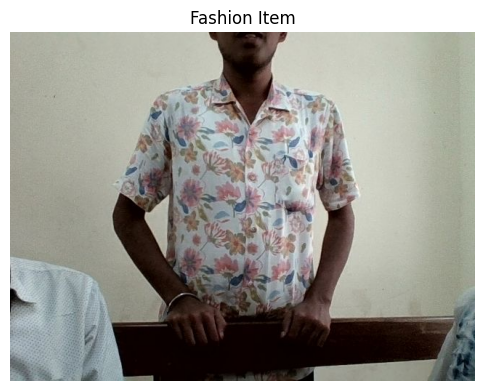

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Running VLM analysis on image...
Created key: 'subcategory' with value: 'Top'
Created key: 'type' with value: 'shirts'
Created key: 'color' with value: 'White'
Created key: 'season' with value: 'summer'
Created key: 'usage' with value: 'Casual'

VLM Analysis Results:
What is the subcategory of this fashion item? Top
What type of article is this fashion item? shirts
What is the base color of this fashion item? White
What season is this fashion item designed for? summer
What is the intended usage of this fashion item? Casual

Concise description: given image: casual white shirts top for summer

What would you like to know about this fashion item?
Examples:
- How can I style this item?
- What accessories would go well with this?
- Is this appropriate for a business casual setting?
Your query: which pants would go well for this fashion item for men?
Loaded configuration from /content/drive/MyDrive/fashion_files/generation_config.json

Generating recommendation...
Generation parameters: ma

Generating tokens: 100%|██████████| 150/150 [05:01<00:00,  2.01s/it]



--- Fashion Recommendation ---

Given your casual summer top preference and the white shirt top, I'd recommend starting with some lightweight white cotton trousers.  White is a neutral color, perfect for summer.  Since you like white shirts, we can incorporate the pattern subtly.  Instead of a bold pattern, consider a slightly more subtle white shirt with subtle white accents on the top half or on the chest.  This creates a balanced look.

For the top half,  choose a lightweight cotton shirt in a darker, neutral color like navy or charcoal grey.  This introduces the top and provides a neutral base.  Avoid a solid top to maintain a clean, streamlined aesthetic.  The darker shirt complements summer, while the lighter top balances the brighter top half.

Press Enter to continue...

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choo

In [ ]:
 import os
import zipfile
import torch
import tiktoken
import json
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import drive

# Define paths
MODEL_PATH = "/content/Files"  # Base VLM model path
TRAINED_VLM_PATH = "/content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt"  # Fine-tuned VLM path
LLM_ZIP_PATH = '/content/drive/MyDrive/fashion_files/best_model.zip'  # LLM model zip path
LLM_UNZIP_DESTINATION = '/content/extracted_model/'  # Where to extract LLM model
USER_TEXT_PATH = '/content/drive/MyDrive/fashion_files/user.txt'  # User profile path
CONFIG_PATH = '/content/drive/MyDrive/fashion_files/generation_config.json'  # Generation config path
OUTPUT_DIR = "/content/drive/MyDrive/finetuned_paligemma"  # Output directory

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Global variables for model caching
vlm_model = None
processor = None
llm_model = None
tokenizer = None
user_profile = None

# Default generation parameters (will be overridden by config file if present)
DEFAULT_CONFIG = {
    "max_new_tokens": 150,
    "temperature": 0.7,
    "top_k": 40,
    "instruction": "",
    "input_text": "",
    "consider_wardrobe": "no",  # For personalization
    "consider_user_details": "no"  # For personalization
}

# Ensure directories exist
os.makedirs(LLM_UNZIP_DESTINATION, exist_ok=True)
os.makedirs(os.path.dirname(USER_TEXT_PATH), exist_ok=True)

# PART 1: VLM FUNCTIONS
# -------------------------------------

# Function to capture images from webcam in Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          await new Promise((resolve) => {
            capture.onclick = resolve;
          });

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def load_finetuned_vlm(base_model_path, trained_model_path, device):
    global vlm_model, processor

    # Check if model is already loaded
    if vlm_model is not None and processor is not None:
        print("VLM model already loaded, reusing...")
        return vlm_model, processor

    print(f"Loading base VLM model from {base_model_path}")

    try:
        # Import model architecture and processor
        # Note: These would need to be properly imported in a real implementation


        model, tokenizer = load_hf_model(base_model_path, device)

        # Check if fine-tuned weights exist
        if os.path.exists(trained_model_path):
            print(f"Loading fine-tuned VLM weights from {trained_model_path}")
            state_dict = torch.load(trained_model_path, map_location=device)
            model.load_state_dict(state_dict, strict=False)
            print("Successfully loaded fine-tuned VLM weights")
        else:
            print(f"Warning: Fine-tuned VLM model not found at {trained_model_path}. Using base model.")

        model.eval()

        # Initialize processor
        num_image_tokens = model.config.vision_config.num_image_tokens
        image_size = model.config.vision_config.image_size
        processor = PaliGemmaProcessor(tokenizer, num_image_tokens, image_size)

        # Cache for future use
        vlm_model = model
        return model, processor

    except ImportError as e:
        print(f"Error importing required modules: {e}")
        print("Please ensure you have the required packages installed.")
        return None, None
    except Exception as e:
        print(f"Error loading VLM model: {e}")
        return None, None

def move_inputs_to_device(model_inputs: dict, device: str):
    return {k: v.to(device) for k, v in model_inputs.items()}

def get_model_inputs(processor, prompt, image, device):
    """Process image (as numpy array or PIL Image) with the processor"""
    if isinstance(image, np.ndarray):
        # Convert OpenCV BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image_rgb)
    else:
        pil_image = image

    model_inputs = processor(text=[prompt], images=[pil_image])
    model_inputs = move_inputs_to_device(model_inputs, device)
    return model_inputs

def generate_vlm_prediction(model, processor, image, prompt, max_tokens=50):
    """Generate prediction for an image (can be PIL Image or numpy array)"""
    try:
        # Import KVCache if not already available

        model_inputs = get_model_inputs(processor, prompt, image, device)
        input_ids = model_inputs["input_ids"]
        attention_mask = model_inputs["attention_mask"]
        pixel_values = model_inputs["pixel_values"]
        kv_cache = KVCache()
        stop_token = processor.tokenizer.eos_token_id
        generated_tokens = []

        with torch.no_grad():
            for _ in range(max_tokens):
                # Always pass pixel_values for this architecture
                outputs = model(
                    input_ids=input_ids,
                    pixel_values=pixel_values,
                    attention_mask=attention_mask,
                    kv_cache=kv_cache,
                )
                kv_cache = outputs["kv_cache"]
                next_token_logits = outputs["logits"][:, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
                token_id = next_token.item()
                generated_tokens.append(token_id)
                if token_id == stop_token:
                    break
                input_ids = next_token
                attention_mask = torch.cat([attention_mask, torch.ones((1, 1), device=device)], dim=-1)

        generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
        return generated_text
    except Exception as e:
        print(f"Error in VLM prediction: {e}")
        return "Error analyzing image"

def process_image_with_vlm(image_path=None, use_webcam=False):
    """Process an image with the VLM and return formatted results"""
    global vlm_model, processor

    # Check if model is loaded
    if vlm_model is None or processor is None:
        vlm_model, processor = load_finetuned_vlm(MODEL_PATH, TRAINED_VLM_PATH, device)
        if vlm_model is None or processor is None:
            return None, None

    # Define the prompts for the VLM
    # Create a mapping to ensure we know which key is for which prompt
    key_mapping = {
        "What is the subcategory of this fashion item?": "subcategory",
        "What type of article is this fashion item?": "type",
        "What is the base color of this fashion item?": "color",
        "What season is this fashion item designed for?": "season",
        "What is the intended usage of this fashion item?": "usage"
    }

    # Get image from webcam or file
    if use_webcam:
        print("Click 'Capture' to take a photo for fashion analysis")
        filename = take_photo()
        print(f"Photo saved as {filename}")
        img = Image.open(filename)
    else:
        # Use provided image path
        if not os.path.exists(image_path):
            print(f"Image not found at {image_path}")
            return None, None
        img = Image.open(image_path)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Fashion Item")
    plt.show()

    # Process the image with VLM
    print("\nRunning VLM analysis on image...")
    results = {}
    raw_img = img  # Keep a copy of the raw image for potential future use

    for prompt in prompts:
        prediction = generate_vlm_prediction(vlm_model, processor, img, prompt)
        # Use our predefined mapping instead of string manipulation
        key = key_mapping.get(prompt, prompt)  # Fallback to prompt if not in mapping
        results[key] = prediction
        print(f"Created key: '{key}' with value: '{prediction}'")  # Debug print

    # Use our predefined keys in the concise description
    concise_desc = f"given image: {results.get('usage', '').lower()} " \
                  f"{results.get('color', '').lower()} " \
                  f"{results.get('type', '').lower()} " \
                  f"{results.get('subcategory', '').lower()} " \
                  f"for {results.get('season', '').lower()}"

    # Display detailed results
    print("\nVLM Analysis Results:")
    for prompt, result in zip(prompts, results.values()):
        print(f"{prompt} {result}")

    print(f"\nConcise description: {concise_desc}")

    # Return both the concise description and the detailed results dictionary
    return concise_desc, results


# PART 2: LLM FUNCTIONS
# -------------------------------------

# Class for parsing and handling user profile data
class UserProfileManager:
    def __init__(self, user_text_path):
        self.user_text_path = user_text_path
        self.user_data = {}
        self.user_wardrobe = []
        self.load_user_data()

    def load_user_data(self):
        """Load and parse user data from user.txt"""
        if not os.path.exists(self.user_text_path):
            print(f"User profile not found at {self.user_text_path}")
            return False

        try:
            with open(self.user_text_path, 'r') as f:
                content = f.read().strip()
                # Parse the user data
                self._parse_user_data(content)
                print(f"Loaded user profile from {self.user_text_path}")
                return True
        except Exception as e:
            print(f"Error loading user profile: {e}")
            return False

    def _parse_user_data(self, content):
        """Parse user data content into structured data"""
        lines = content.split('\n')
        for line in lines:
            # Skip empty lines and lines without a proper key:value format
            if not line.strip() or ':' not in line:
                continue

            parts = line.split(':', 1)
            key = parts[0].strip().lower()
            value = parts[1].strip()

            # Special handling for wardrobe items
            if key == 'wardrobe':
                self.user_wardrobe = [item.strip() for item in value.split(',')]
                self.user_data[key] = self.user_wardrobe
            else:
                self.user_data[key] = value

    def get_user_profile_summary(self):
        """Get a formatted summary of the user profile for the model"""
        if not self.user_data:
            return "No user profile data available."

        summary = []
        # Add basic user information
        for key, value in self.user_data.items():
            if key != 'wardrobe':  # Handle wardrobe separately
                summary.append(f"{key}: {value}")

        return "\n".join(summary)

    def get_wardrobe_summary(self):
        """Get a formatted summary of the user's wardrobe"""
        if not self.user_wardrobe:
            return "No wardrobe information available."

        return "Wardrobe items: " + ", ".join(self.user_wardrobe)

# Function to extract zip with progress tracking
def extract_with_progress(zip_path, extract_to):
    # Check if model is already extracted
    expected_model_path = os.path.join(extract_to, os.path.basename(zip_path).replace('.zip', '.pt'))
    if os.path.exists(expected_model_path):
        print(f"Model already extracted at {expected_model_path}, skipping extraction")
        return expected_model_path

    if not os.path.exists(zip_path):
        print(f"Error: Model zip file not found at {zip_path}")
        return None

    print(f"Extracting model from {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get file info
        file_info_list = zip_ref.infolist()

        # Set up tqdm progress bar
        with tqdm(total=len(file_info_list), desc="Extracting files") as pbar:
            for file_info in file_info_list:
                zip_ref.extract(file_info, extract_to)
                pbar.update(1)

    print(f"Extraction complete to {extract_to}")
    return expected_model_path

def format_input(instruction, input_text="", consider_wardrobe="no", consider_user_details="no", user_profile=None, image_features=None):
    """Format the instruction and input according to the training format, including personalization options and image features."""
    # Base instruction
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request. "
        f"Do not generate additional inputs or profile information."
        f"\n\n### Instruction:\n{instruction}"
    )

    # Add personalization details if requested
    if user_profile and consider_user_details.lower() == "yes":
        instruction_text += f"\n\nConsider the following user details for personalization:\n{user_profile.get_user_profile_summary()}"

    # Add wardrobe information if requested
    if user_profile and consider_wardrobe.lower() == "yes":
        instruction_text += f"\n\nConsider these items from the user's wardrobe for your suggestions:\n{user_profile.get_wardrobe_summary()}"

    # Add input text if provided
    if input_text:
        # Format with image features if available
        if image_features:
            # Create detailed description from image features
            details = []
            if "subcategory" in image_features:
                details.append(f"Subcategory: {image_features['subcategory']}")
            if "type of article" in image_features:
                details.append(f"Type: {image_features['type of article']}")
            if "base color" in image_features:
                details.append(f"Color: {image_features['base color']}")
            if "season" in image_features:
                details.append(f"Season: {image_features['season']}")
            if "intended usage" in image_features:
                details.append(f"Usage: {image_features['intended usage']}")

            feature_details = "\n".join(details)
            input_text = f"Image Analysis:\n{feature_details}\n\nUser Query: {input_text}"

    input_part = f"\n\n### Input:\n{input_text}" if input_text else ""

    return instruction_text + input_part + "\n\n### Response:"

def load_finetuned_llm(checkpoint_path, device):
    """Load the fine-tuned LLM from a checkpoint."""
    global llm_model

    # Check if model is already loaded
    if llm_model is not None:
        print("LLM model already loaded, reusing...")
        return llm_model

    if not os.path.exists(checkpoint_path):
        print(f"Error: LLM checkpoint not found at {checkpoint_path}")
        return None

    print(f"Loading LLM model from {checkpoint_path}")

    try:
        # Import your model definitions here
        # Initialize model with configuration
        model = GPTModel(GPT_CONFIG_774M)

        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])

        # Move model to device
        model.to(device)
        model.eval()

        print(f"LLM model loaded successfully! Validation loss: {checkpoint.get('val_loss', 'N/A')}")

        # Cache for future use
        llm_model = model
        return model
    except ImportError as e:
        print(f"Error importing required modules: {e}")
        print("Please ensure you have the required packages installed.")
        return None
    except Exception as e:
        print(f"Error loading LLM model: {e}")
        return None

def generate_llm_text(model, tokenizer, prompt, device, max_new_tokens=150, temperature=0.7, top_k=40):
    """Generate text based on a prompt using the fine-tuned LLM."""
    if model is None:
        print("Error: LLM model not loaded properly")
        return "Model not available. Please check the console for errors.", []

    # Tokenize the prompt
    encoded = torch.tensor(tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})).unsqueeze(0).to(device)
    context_size = model.pos_emb.weight.shape[0]

    # Generate response
    model.eval()

    print(f"Generation parameters: max_tokens={max_new_tokens}, temp={temperature}, top_k={top_k}")
    generated_tokens = []

    with torch.no_grad():
        for _ in tqdm(range(max_new_tokens), desc="Generating tokens"):
            # Get context for the current step
            idx_cond = encoded[:, -context_size:]

            # Forward pass
            logits = model(idx_cond)

            # Get logits for the last token
            logits = logits[:, -1, :]

            # Apply temperature and top-k filtering
            if temperature > 0:
                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = float('-inf')

                probs = torch.softmax(logits / temperature, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                # Greedy sampling
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

            # Append new token
            encoded = torch.cat((encoded, idx_next), dim=1)
            generated_tokens.append(idx_next.item())

            # Stop if EOS token is generated (50256 is <|endoftext|>)
            if idx_next.item() == 50256:
                break

            # Also stop if we see "### Input:" - this is a sign the model is hallucinating additional input
            current_text = tokenizer.decode(encoded.squeeze().tolist()[len(tokenizer.encode(prompt)):])
            if "### Input:" in current_text:
                break

    # Decode the generated text
    generated_text = tokenizer.decode(encoded.squeeze().tolist())

    # Return only the response part (after the prompt)
    response = generated_text[len(prompt):]

    # Remove any hallucinated input sections
    if "### Input:" in response:
        response = response.split("### Input:")[0].strip()

    # Remove any hallucinated response markers
    if "### Response:" in response:
        response = response.replace("### Response:", "").strip()

    return response, generated_tokens

def load_user_config():
    """Load user configuration from config file if it exists, otherwise use defaults."""
    config = DEFAULT_CONFIG.copy()

    # Check if config file exists
    if os.path.exists(CONFIG_PATH):
        try:
            with open(CONFIG_PATH, 'r') as f:
                user_config = json.load(f)
                config.update(user_config)
                print(f"Loaded configuration from {CONFIG_PATH}")
        except Exception as e:
            print(f"Error loading config file: {e}")
            print("Using default configuration")
    else:
        print(f"Config file not found at {CONFIG_PATH}. Using default configuration.")
        # Create a template config file for future use
        try:
            with open(CONFIG_PATH, 'w') as f:
                json.dump(DEFAULT_CONFIG, f, indent=4)
                print(f"Created template config file at {CONFIG_PATH}")
        except Exception as e:
            print(f"Failed to create template config file: {e}")

    return config

def update_config_interactive(config):
    """Allow user to interactively update configuration parameters."""
    print("\n===== Generation Configuration =====")
    print("Current settings:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    print("\nEnter new values (press Enter to keep current value):")

    # Update numerical parameters
    for param in ["max_new_tokens", "temperature", "top_k"]:
        new_value = input(f"{param} [{config[param]}]: ")
        if new_value.strip():
            try:
                if param == "max_new_tokens" or param == "top_k":
                    config[param] = int(new_value)
                else:
                    config[param] = float(new_value)
            except ValueError:
                print(f"Invalid value for {param}, keeping current value.")

    # Update personalization parameters
    for param in ["consider_wardrobe", "consider_user_details"]:
        new_value = input(f"{param} [{config[param]}] (yes/no): ")
        if new_value.strip().lower() in ['yes', 'no']:
            config[param] = new_value.lower()

    # Save updated config
    try:
        with open(CONFIG_PATH, 'w') as f:
            json.dump(config, f, indent=4)
            print(f"Configuration saved to {CONFIG_PATH}")
    except Exception as e:
        print(f"Failed to save configuration: {e}")

    return config

# PART 3: USER PROFILE MANAGEMENT
# -------------------------------------

def update_user_profile(user_profile):
    """Interactive function to update user profile data"""
    print("\n===== Update User Profile =====")

    if user_profile.user_data:
        print("Current profile:")
        for key, value in user_profile.user_data.items():
            if key != 'wardrobe':  # Display wardrobe separately
                print(f"  {key}: {value}")

        # Display wardrobe items separately
        if user_profile.user_wardrobe:
            print("Wardrobe items:")
            for i, item in enumerate(user_profile.user_wardrobe, 1):
                print(f"  {i}. {item}")
    else:
        print("No profile data found. Creating new profile.")

    print("\nOptions:")
    print("1. Edit basic profile information")
    print("2. Edit wardrobe items")
    print("3. Cancel")

    choice = input("Choose an option (1-3): ")

    if choice == '1':
        # Edit basic profile info
        print("\nEnter profile information (press Enter to keep current values, 'delete' to remove):")
        fields = ['name', 'age', 'gender', 'location', 'style', 'occupation', 'preferences', 'favorite_colors', 'size']

        updated_data = {}
        for field in fields:
            current = user_profile.user_data.get(field, '')
            new_value = input(f"{field} [{current}]: ")

            if new_value.lower() == 'delete':
                # Don't include this field
                pass
            elif new_value.strip():
                # Update with new value
                updated_data[field] = new_value
            elif field in user_profile.user_data:
                # Keep current value
                updated_data[field] = current

        # Preserve wardrobe data
        if 'wardrobe' in user_profile.user_data:
            updated_data['wardrobe'] = user_profile.user_data['wardrobe']

        # Update user data
        user_profile.user_data = updated_data

        # Save to file
        save_updated_profile(user_profile)

    elif choice == '2':
        # Edit wardrobe items
        print("\nOptions for wardrobe:")
        print("1. Add items")
        print("2. Remove items")
        print("3. Replace all items")
        print("4. Cancel")

        wardrobe_choice = input("Choose an option (1-4): ")

        if wardrobe_choice == '1':
            # Add items
            new_items = input("Enter items to add (comma separated): ")
            items_to_add = [item.strip() for item in new_items.split(',') if item.strip()]

            if 'wardrobe' not in user_profile.user_data:
                user_profile.user_data['wardrobe'] = []
                user_profile.user_wardrobe = []

            user_profile.user_wardrobe.extend(items_to_add)
            user_profile.user_data['wardrobe'] = user_profile.user_wardrobe

            save_updated_profile(user_profile)

        elif wardrobe_choice == '2':
            # Remove items
            if not user_profile.user_wardrobe:
                print("No wardrobe items to remove.")
                return

            print("Current items:")
            for i, item in enumerate(user_profile.user_wardrobe, 1):
                print(f"  {i}. {item}")

            to_remove = input("Enter numbers of items to remove (comma separated): ")
            try:
                indices = [int(idx.strip()) for idx in to_remove.split(',') if idx.strip()]
                # Sort in reverse to avoid index shifting during removal
                indices.sort(reverse=True)

                for idx in indices:
                    if 1 <= idx <= len(user_profile.user_wardrobe):
                        del user_profile.user_wardrobe[idx-1]

                user_profile.user_data['wardrobe'] = user_profile.user_wardrobe
                save_updated_profile(user_profile)

            except ValueError:
                print("Invalid input. Please enter numbers separated by commas.")

        elif wardrobe_choice == '3':
            # Replace all
            new_wardrobe = input("Enter new wardrobe items (comma separated): ")
            new_items = [item.strip() for item in new_wardrobe.split(',') if item.strip()]

            user_profile.user_wardrobe = new_items
            user_profile.user_data['wardrobe'] = new_items

            save_updated_profile(user_profile)

def save_updated_profile(user_profile):
    """Save updated profile to user.txt file"""
    try:
        # Format profile data for saving
        lines = []

        # Add basic profile fields first
        for key, value in user_profile.user_data.items():
            if key != 'wardrobe':  # Handle wardrobe separately
                lines.append(f"{key}: {value}")

        # Add wardrobe at the end
        if user_profile.user_wardrobe:
            lines.append(f"wardrobe: {', '.join(user_profile.user_wardrobe)}")

        # Write to file
        with open(user_profile.user_text_path, 'w') as f:
            f.write('\n'.join(lines))

        print(f"Profile updated and saved to {user_profile.user_text_path}")
        # Reload the profile to ensure everything is up to date
        user_profile.load_user_data()
        return True

    except Exception as e:
        print(f"Error saving profile: {e}")
        return False

# PART 4: INITIALIZATION AND SYSTEM STARTUP
# -------------------------------------

def initialize_system():
    """Initialize the system - load models and user profile"""
    global llm_model, tokenizer, user_profile

    print("\n===== Initializing Fashion Recommendation System =====")

    # Mount Google Drive if needed
    if not os.path.exists("/content/drive"):
        print("Mounting Google Drive...")
        drive.mount('/content/drive')

    # Extract and load LLM model
    llm_model_path = extract_with_progress(LLM_ZIP_PATH, LLM_UNZIP_DESTINATION)
    if llm_model_path:
        llm_model = load_finetuned_llm(llm_model_path, device)

    # Load tokenizer for LLM
    tokenizer = tiktoken.get_encoding("gpt2")

    # Load user profile
    user_profile = UserProfileManager(USER_TEXT_PATH)

    # Check if user profile needs to be created
    if not user_profile.user_data:
        print("No user profile found. Would you like to create one? (y/n)")
        if input().lower() == 'y':
            update_user_profile(user_profile)

    print("System initialization complete!")
    print(f"LLM model status: {'Loaded' if llm_model else 'Not loaded'}")
    print(f"User profile status: {'Loaded' if user_profile.user_data else 'Not loaded'}")

    return llm_model is not None

# PART 5: INTEGRATED SYSTEM
# -------------------------------------

def run_integrated_fashion_system():
    """Main function to run the integrated fashion recommendation system"""
    # Initialize system first
    if not initialize_system():
        print("Error initializing system. Please check the error messages above.")
        return

    # Main loop
    while True:
        print("\n===== Integrated Fashion Recommendation System =====")
        print("Options:")
        print("1. Use fashion image for recommendations")
        print("2. Ask fashion question (text only)")
        print("3. Update user profile")
        print("4. Configure generation parameters")
        print("5. Exit")

        choice = input("Choose an option (1-5): ")

        if choice == '1':
            # Image-based fashion recommendation
            print("\n--- Image-based Fashion Recommendation ---")
            print("Select image source:")
            print("1. Use webcam")
            print("2. Use image file")
            print("3. Back to main menu")

            img_choice = input("Choose image source (1-3): ")

            if img_choice == '1':
                # Use webcam
                image_desc, image_features = process_image_with_vlm(use_webcam=True)
            elif img_choice == '2':
                # Use image file
                image_path = input("Enter path to image file: ")
                image_desc, image_features = process_image_with_vlm(image_path=image_path)
            else:
                continue

            if not image_desc or not image_features:
                print("Failed to analyze image. Please try again.")
                continue

            # Ask for specific query about the fashion item
            print("\nWhat would you like to know about this fashion item?")
            print("Examples:")
            print("- How can I style this item?")
            print("- What accessories would go well with this?")
            print("- Is this appropriate for a business casual setting?")

            query = input("Your query: ")

            # Load user config
            config = load_user_config()

            # Format instruction for LLM
            instruction = "You are a fashion expert. Provide detailed and helpful advice about the fashion item shown in the image based on the user's query."
            input_text = f"{image_desc}. {query}"

            # Generate formatted input
            formatted_input = format_input(
                instruction,
                input_text,
                config['consider_wardrobe'],
                config['consider_user_details'],
                user_profile,
                image_features
            )

            # Generate response
            print("\nGenerating recommendation...")

            response, _ = generate_llm_text(
                llm_model,
                tokenizer,
                formatted_input,
                device,
                max_new_tokens=config['max_new_tokens'],
                temperature=config['temperature'],
                top_k=config['top_k']
            )

            print("\n--- Fashion Recommendation ---")
            print(response)

            input("\nPress Enter to continue...")

        elif choice == '2':
            # Text-only fashion question
            print("\n--- Fashion Question (Text Only) ---")
            print("Examples:")
            print("- What are the fashion trends for summer 2024?")
            print("- How should I build a capsule wardrobe?")
            print("- What colors work well with navy blue?")

            query = input("Your fashion question: ")

            # Load user config
            config = load_user_config()

            # Format instruction for LLM
            instruction = "You are a fashion expert. Provide detailed and helpful advice about fashion based on the user's query."

            # Generate formatted input
            formatted_input = format_input(
                instruction,
                query,
                config['consider_wardrobe'],
                config['consider_user_details'],
                user_profile
            )

            # Generate response
            print("\nGenerating response...")

            response, _ = generate_llm_text(
                llm_model,
                tokenizer,
                formatted_input,
                device,
                max_new_tokens=config['max_new_tokens'],
                temperature=config['temperature'],
                top_k=config['top_k']
            )

            print("\n--- Fashion Advice ---")
            print(response)

            input("\nPress Enter to continue...")

        elif choice == '3':
            # Update user profile
            update_user_profile(user_profile)
            input("\nPress Enter to continue...")

        elif choice == '4':
            # Configure generation parameters
            config = load_user_config()
            config = update_config_interactive(config)
            input("\nPress Enter to continue...")

        elif choice == '5':
            # Exit
            print("Thank you for using the Fashion Recommendation System!")
            break

        else:
            print("Invalid choice. Please try again.")

# PART 6: MAIN PROGRAM
# -------------------------------------

if __name__ == "__main__":
    run_integrated_fashion_system()

Using device: cpu

===== Initializing Fashion Recommendation System =====
Model already extracted at /content/extracted_model/best_model.pt, skipping extraction
Loading LLM model from /content/extracted_model/best_model.pt


<ipython-input-7-1aa843f6e7bd>:422: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


LLM model loaded successfully! Validation loss: 1.2289036760727565
Loaded user profile from /content/drive/MyDrive/fashion_files/user.txt
System initialization complete!
LLM model status: Loaded
User profile status: Loaded

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choose an option (1-5): 1

--- Image-based Fashion Recommendation ---
Select image source:
1. Use webcam
2. Use image file
3. Back to main menu
Choose image source (1-3): 1
Loading base VLM model from /content/Files
Loading fine-tuned VLM weights from /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt


<ipython-input-7-1aa843f6e7bd>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(trained_model_path, map_location=device)


Successfully loaded fine-tuned VLM weights
Click 'Capture' to take a photo for fashion analysis


<IPython.core.display.Javascript object>

Photo saved as photo.jpg


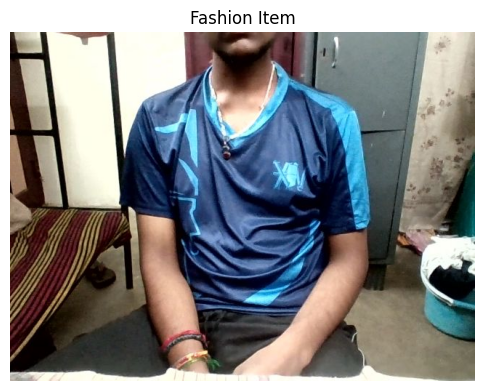

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Running VLM analysis on image...
Created key: 'subcategory' with value: 'Top'
Created key: 'type' with value: 'shirt'
Created key: 'color' with value: 'Blue'
Created key: 'season' with value: 'summer'
Created key: 'usage' with value: 'sports'

VLM Analysis Results:
What is the subcategory of this fashion item? Top
What type of article is this fashion item? shirt
What is the base color of this fashion item? Blue
What season is this fashion item designed for? summer
What is the intended usage of this fashion item? sports

Concise description: given image: sports blue shirt top for summer

What would you like to know about this fashion item?
Examples:
- How can I style this item?
- What accessories would go well with this?
- Is this appropriate for a business casual setting?
Your query: is this a famous brand and is it skin friendly
Loaded configuration from /content/drive/MyDrive/fashion_files/generation_config.json

Generating recommendation...
Generation parameters: max_tokens=150, te

Generating tokens: 100%|██████████| 150/150 [04:44<00:00,  1.90s/it]



--- Fashion Recommendation ---

Hey there!  A sports blue top with a subtle, summery print is a fantastic choice. The subtle blue complements your complexion nicely.  Considering your preferences and the context, a top in this particular season would be fantastic.  It's comfortable enough for lounging around the house and stylish enough for a casual day out.

Given your athletic build and the context, we can definitely work around your height and build. Skip the blazer as it's not recommended for summer. Instead, consider a lightweight linen shirt in a breathable fabric like linen or a cotton blend. Linen breathes well, keeping you cool and comfortable in warmer weather.  A slightly lighter blue top will complement the blue top.

Access

Press Enter to continue...

===== Integrated Fashion Recommendation System =====
Options:
1. Use fashion image for recommendations
2. Ask fashion question (text only)
3. Update user profile
4. Configure generation parameters
5. Exit
Choose an option (

In [ ]:
 import os
import zipfile
import torch
import tiktoken
import json
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import drive

# Define paths
MODEL_PATH = "/content/Files"  # Base VLM model path
TRAINED_VLM_PATH = "/content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt"  # Fine-tuned VLM path
LLM_ZIP_PATH = '/content/drive/MyDrive/fashion_files/best_model.zip'  # LLM model zip path
LLM_UNZIP_DESTINATION = '/content/extracted_model/'  # Where to extract LLM model
USER_TEXT_PATH = '/content/drive/MyDrive/fashion_files/user.txt'  # User profile path
CONFIG_PATH = '/content/drive/MyDrive/fashion_files/generation_config.json'  # Generation config path
OUTPUT_DIR = "/content/drive/MyDrive/finetuned_paligemma"  # Output directory

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Global variables for model caching
vlm_model = None
processor = None
llm_model = None
tokenizer = None
user_profile = None

# Default generation parameters (will be overridden by config file if present)
DEFAULT_CONFIG = {
    "max_new_tokens": 150,
    "temperature": 0.7,
    "top_k": 40,
    "instruction": "",
    "input_text": "",
    "consider_wardrobe": "no",  # For personalization
    "consider_user_details": "no"  # For personalization
}

# Ensure directories exist
os.makedirs(LLM_UNZIP_DESTINATION, exist_ok=True)
os.makedirs(os.path.dirname(USER_TEXT_PATH), exist_ok=True)

# PART 1: VLM FUNCTIONS
# -------------------------------------

# Function to capture images from webcam in Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          await new Promise((resolve) => {
            capture.onclick = resolve;
          });

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def load_finetuned_vlm(base_model_path, trained_model_path, device):
    global vlm_model, processor

    # Check if model is already loaded
    if vlm_model is not None and processor is not None:
        print("VLM model already loaded, reusing...")
        return vlm_model, processor

    print(f"Loading base VLM model from {base_model_path}")

    try:
        # Import model architecture and processor
        # Note: These would need to be properly imported in a real implementation


        model, tokenizer = load_hf_model(base_model_path, device)

        # Check if fine-tuned weights exist
        if os.path.exists(trained_model_path):
            print(f"Loading fine-tuned VLM weights from {trained_model_path}")
            state_dict = torch.load(trained_model_path, map_location=device)
            model.load_state_dict(state_dict, strict=False)
            print("Successfully loaded fine-tuned VLM weights")
        else:
            print(f"Warning: Fine-tuned VLM model not found at {trained_model_path}. Using base model.")

        model.eval()

        # Initialize processor
        num_image_tokens = model.config.vision_config.num_image_tokens
        image_size = model.config.vision_config.image_size
        processor = PaliGemmaProcessor(tokenizer, num_image_tokens, image_size)

        # Cache for future use
        vlm_model = model
        return model, processor

    except ImportError as e:
        print(f"Error importing required modules: {e}")
        print("Please ensure you have the required packages installed.")
        return None, None
    except Exception as e:
        print(f"Error loading VLM model: {e}")
        return None, None

def move_inputs_to_device(model_inputs: dict, device: str):
    return {k: v.to(device) for k, v in model_inputs.items()}

def get_model_inputs(processor, prompt, image, device):
    """Process image (as numpy array or PIL Image) with the processor"""
    if isinstance(image, np.ndarray):
        # Convert OpenCV BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image_rgb)
    else:
        pil_image = image

    model_inputs = processor(text=[prompt], images=[pil_image])
    model_inputs = move_inputs_to_device(model_inputs, device)
    return model_inputs

def generate_vlm_prediction(model, processor, image, prompt, max_tokens=50):
    """Generate prediction for an image (can be PIL Image or numpy array)"""
    try:
        # Import KVCache if not already available

        model_inputs = get_model_inputs(processor, prompt, image, device)
        input_ids = model_inputs["input_ids"]
        attention_mask = model_inputs["attention_mask"]
        pixel_values = model_inputs["pixel_values"]
        kv_cache = KVCache()
        stop_token = processor.tokenizer.eos_token_id
        generated_tokens = []

        with torch.no_grad():
            for _ in range(max_tokens):
                # Always pass pixel_values for this architecture
                outputs = model(
                    input_ids=input_ids,
                    pixel_values=pixel_values,
                    attention_mask=attention_mask,
                    kv_cache=kv_cache,
                )
                kv_cache = outputs["kv_cache"]
                next_token_logits = outputs["logits"][:, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
                token_id = next_token.item()
                generated_tokens.append(token_id)
                if token_id == stop_token:
                    break
                input_ids = next_token
                attention_mask = torch.cat([attention_mask, torch.ones((1, 1), device=device)], dim=-1)

        generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
        return generated_text
    except Exception as e:
        print(f"Error in VLM prediction: {e}")
        return "Error analyzing image"

def process_image_with_vlm(image_path=None, use_webcam=False):
    """Process an image with the VLM and return formatted results"""
    global vlm_model, processor

    # Check if model is loaded
    if vlm_model is None or processor is None:
        vlm_model, processor = load_finetuned_vlm(MODEL_PATH, TRAINED_VLM_PATH, device)
        if vlm_model is None or processor is None:
            return None, None

    # Define the prompts for the VLM
    # Create a mapping to ensure we know which key is for which prompt
    key_mapping = {
        "What is the subcategory of this fashion item?": "subcategory",
        "What type of article is this fashion item?": "type",
        "What is the base color of this fashion item?": "color",
        "What season is this fashion item designed for?": "season",
        "What is the intended usage of this fashion item?": "usage"
    }

    # Get image from webcam or file
    if use_webcam:
        print("Click 'Capture' to take a photo for fashion analysis")
        filename = take_photo()
        print(f"Photo saved as {filename}")
        img = Image.open(filename)
    else:
        # Use provided image path
        if not os.path.exists(image_path):
            print(f"Image not found at {image_path}")
            return None, None
        img = Image.open(image_path)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Fashion Item")
    plt.show()

    # Process the image with VLM
    print("\nRunning VLM analysis on image...")
    results = {}
    raw_img = img  # Keep a copy of the raw image for potential future use

    for prompt in prompts:
        prediction = generate_vlm_prediction(vlm_model, processor, img, prompt)
        # Use our predefined mapping instead of string manipulation
        key = key_mapping.get(prompt, prompt)  # Fallback to prompt if not in mapping
        results[key] = prediction
        print(f"Created key: '{key}' with value: '{prediction}'")  # Debug print

    # Use our predefined keys in the concise description
    concise_desc = f"given image: {results.get('usage', '').lower()} " \
                  f"{results.get('color', '').lower()} " \
                  f"{results.get('type', '').lower()} " \
                  f"{results.get('subcategory', '').lower()} " \
                  f"for {results.get('season', '').lower()}"

    # Display detailed results
    print("\nVLM Analysis Results:")
    for prompt, result in zip(prompts, results.values()):
        print(f"{prompt} {result}")

    print(f"\nConcise description: {concise_desc}")

    # Return both the concise description and the detailed results dictionary
    return concise_desc, results


# PART 2: LLM FUNCTIONS
# -------------------------------------

# Class for parsing and handling user profile data
class UserProfileManager:
    def __init__(self, user_text_path):
        self.user_text_path = user_text_path
        self.user_data = {}
        self.user_wardrobe = []
        self.load_user_data()

    def load_user_data(self):
        """Load and parse user data from user.txt"""
        if not os.path.exists(self.user_text_path):
            print(f"User profile not found at {self.user_text_path}")
            return False

        try:
            with open(self.user_text_path, 'r') as f:
                content = f.read().strip()
                # Parse the user data
                self._parse_user_data(content)
                print(f"Loaded user profile from {self.user_text_path}")
                return True
        except Exception as e:
            print(f"Error loading user profile: {e}")
            return False

    def _parse_user_data(self, content):
        """Parse user data content into structured data"""
        lines = content.split('\n')
        for line in lines:
            # Skip empty lines and lines without a proper key:value format
            if not line.strip() or ':' not in line:
                continue

            parts = line.split(':', 1)
            key = parts[0].strip().lower()
            value = parts[1].strip()

            # Special handling for wardrobe items
            if key == 'wardrobe':
                self.user_wardrobe = [item.strip() for item in value.split(',')]
                self.user_data[key] = self.user_wardrobe
            else:
                self.user_data[key] = value

    def get_user_profile_summary(self):
        """Get a formatted summary of the user profile for the model"""
        if not self.user_data:
            return "No user profile data available."

        summary = []
        # Add basic user information
        for key, value in self.user_data.items():
            if key != 'wardrobe':  # Handle wardrobe separately
                summary.append(f"{key}: {value}")

        return "\n".join(summary)

    def get_wardrobe_summary(self):
        """Get a formatted summary of the user's wardrobe"""
        if not self.user_wardrobe:
            return "No wardrobe information available."

        return "Wardrobe items: " + ", ".join(self.user_wardrobe)

# Function to extract zip with progress tracking
def extract_with_progress(zip_path, extract_to):
    # Check if model is already extracted
    expected_model_path = os.path.join(extract_to, os.path.basename(zip_path).replace('.zip', '.pt'))
    if os.path.exists(expected_model_path):
        print(f"Model already extracted at {expected_model_path}, skipping extraction")
        return expected_model_path

    if not os.path.exists(zip_path):
        print(f"Error: Model zip file not found at {zip_path}")
        return None

    print(f"Extracting model from {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get file info
        file_info_list = zip_ref.infolist()

        # Set up tqdm progress bar
        with tqdm(total=len(file_info_list), desc="Extracting files") as pbar:
            for file_info in file_info_list:
                zip_ref.extract(file_info, extract_to)
                pbar.update(1)

    print(f"Extraction complete to {extract_to}")
    return expected_model_path

def format_input(instruction, input_text="", consider_wardrobe="no", consider_user_details="no", user_profile=None, image_features=None):
    """Format the instruction and input according to the training format, including personalization options and image features."""
    # Base instruction
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request. "
        f"Do not generate additional inputs or profile information."
        f"\n\n### Instruction:\n{instruction}"
    )

    # Add personalization details if requested
    if user_profile and consider_user_details.lower() == "yes":
        instruction_text += f"\n\nConsider the following user details for personalization:\n{user_profile.get_user_profile_summary()}"

    # Add wardrobe information if requested
    if user_profile and consider_wardrobe.lower() == "yes":
        instruction_text += f"\n\nConsider these items from the user's wardrobe for your suggestions:\n{user_profile.get_wardrobe_summary()}"

    # Add input text if provided
    if input_text:
        # Format with image features if available
        if image_features:
            # Create detailed description from image features
            details = []
            if "subcategory" in image_features:
                details.append(f"Subcategory: {image_features['subcategory']}")
            if "type of article" in image_features:
                details.append(f"Type: {image_features['type of article']}")
            if "base color" in image_features:
                details.append(f"Color: {image_features['base color']}")
            if "season" in image_features:
                details.append(f"Season: {image_features['season']}")
            if "intended usage" in image_features:
                details.append(f"Usage: {image_features['intended usage']}")

            feature_details = "\n".join(details)
            input_text = f"Image Analysis:\n{feature_details}\n\nUser Query: {input_text}"

    input_part = f"\n\n### Input:\n{input_text}" if input_text else ""

    return instruction_text + input_part + "\n\n### Response:"

def load_finetuned_llm(checkpoint_path, device):
    """Load the fine-tuned LLM from a checkpoint."""
    global llm_model

    # Check if model is already loaded
    if llm_model is not None:
        print("LLM model already loaded, reusing...")
        return llm_model

    if not os.path.exists(checkpoint_path):
        print(f"Error: LLM checkpoint not found at {checkpoint_path}")
        return None

    print(f"Loading LLM model from {checkpoint_path}")

    try:
        # Import your model definitions here
        # Initialize model with configuration
        model = GPTModel(GPT_CONFIG_774M)

        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])

        # Move model to device
        model.to(device)
        model.eval()

        print(f"LLM model loaded successfully! Validation loss: {checkpoint.get('val_loss', 'N/A')}")

        # Cache for future use
        llm_model = model
        return model
    except ImportError as e:
        print(f"Error importing required modules: {e}")
        print("Please ensure you have the required packages installed.")
        return None
    except Exception as e:
        print(f"Error loading LLM model: {e}")
        return None

def generate_llm_text(model, tokenizer, prompt, device, max_new_tokens=150, temperature=0.7, top_k=40):
    """Generate text based on a prompt using the fine-tuned LLM."""
    if model is None:
        print("Error: LLM model not loaded properly")
        return "Model not available. Please check the console for errors.", []

    # Tokenize the prompt
    encoded = torch.tensor(tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})).unsqueeze(0).to(device)
    context_size = model.pos_emb.weight.shape[0]

    # Generate response
    model.eval()

    print(f"Generation parameters: max_tokens={max_new_tokens}, temp={temperature}, top_k={top_k}")
    generated_tokens = []

    with torch.no_grad():
        for _ in tqdm(range(max_new_tokens), desc="Generating tokens"):
            # Get context for the current step
            idx_cond = encoded[:, -context_size:]

            # Forward pass
            logits = model(idx_cond)

            # Get logits for the last token
            logits = logits[:, -1, :]

            # Apply temperature and top-k filtering
            if temperature > 0:
                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = float('-inf')

                probs = torch.softmax(logits / temperature, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                # Greedy sampling
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

            # Append new token
            encoded = torch.cat((encoded, idx_next), dim=1)
            generated_tokens.append(idx_next.item())

            # Stop if EOS token is generated (50256 is <|endoftext|>)
            if idx_next.item() == 50256:
                break

            # Also stop if we see "### Input:" - this is a sign the model is hallucinating additional input
            current_text = tokenizer.decode(encoded.squeeze().tolist()[len(tokenizer.encode(prompt)):])
            if "### Input:" in current_text:
                break

    # Decode the generated text
    generated_text = tokenizer.decode(encoded.squeeze().tolist())

    # Return only the response part (after the prompt)
    response = generated_text[len(prompt):]

    # Remove any hallucinated input sections
    if "### Input:" in response:
        response = response.split("### Input:")[0].strip()

    # Remove any hallucinated response markers
    if "### Response:" in response:
        response = response.replace("### Response:", "").strip()

    return response, generated_tokens

def load_user_config():
    """Load user configuration from config file if it exists, otherwise use defaults."""
    config = DEFAULT_CONFIG.copy()

    # Check if config file exists
    if os.path.exists(CONFIG_PATH):
        try:
            with open(CONFIG_PATH, 'r') as f:
                user_config = json.load(f)
                config.update(user_config)
                print(f"Loaded configuration from {CONFIG_PATH}")
        except Exception as e:
            print(f"Error loading config file: {e}")
            print("Using default configuration")
    else:
        print(f"Config file not found at {CONFIG_PATH}. Using default configuration.")
        # Create a template config file for future use
        try:
            with open(CONFIG_PATH, 'w') as f:
                json.dump(DEFAULT_CONFIG, f, indent=4)
                print(f"Created template config file at {CONFIG_PATH}")
        except Exception as e:
            print(f"Failed to create template config file: {e}")

    return config

def update_config_interactive(config):
    """Allow user to interactively update configuration parameters."""
    print("\n===== Generation Configuration =====")
    print("Current settings:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    print("\nEnter new values (press Enter to keep current value):")

    # Update numerical parameters
    for param in ["max_new_tokens", "temperature", "top_k"]:
        new_value = input(f"{param} [{config[param]}]: ")
        if new_value.strip():
            try:
                if param == "max_new_tokens" or param == "top_k":
                    config[param] = int(new_value)
                else:
                    config[param] = float(new_value)
            except ValueError:
                print(f"Invalid value for {param}, keeping current value.")

    # Update personalization parameters
    for param in ["consider_wardrobe", "consider_user_details"]:
        new_value = input(f"{param} [{config[param]}] (yes/no): ")
        if new_value.strip().lower() in ['yes', 'no']:
            config[param] = new_value.lower()

    # Save updated config
    try:
        with open(CONFIG_PATH, 'w') as f:
            json.dump(config, f, indent=4)
            print(f"Configuration saved to {CONFIG_PATH}")
    except Exception as e:
        print(f"Failed to save configuration: {e}")

    return config

# PART 3: USER PROFILE MANAGEMENT
# -------------------------------------

def update_user_profile(user_profile):
    """Interactive function to update user profile data"""
    print("\n===== Update User Profile =====")

    if user_profile.user_data:
        print("Current profile:")
        for key, value in user_profile.user_data.items():
            if key != 'wardrobe':  # Display wardrobe separately
                print(f"  {key}: {value}")

        # Display wardrobe items separately
        if user_profile.user_wardrobe:
            print("Wardrobe items:")
            for i, item in enumerate(user_profile.user_wardrobe, 1):
                print(f"  {i}. {item}")
    else:
        print("No profile data found. Creating new profile.")

    print("\nOptions:")
    print("1. Edit basic profile information")
    print("2. Edit wardrobe items")
    print("3. Cancel")

    choice = input("Choose an option (1-3): ")

    if choice == '1':
        # Edit basic profile info
        print("\nEnter profile information (press Enter to keep current values, 'delete' to remove):")
        fields = ['name', 'age', 'gender', 'location', 'style', 'occupation', 'preferences', 'favorite_colors', 'size']

        updated_data = {}
        for field in fields:
            current = user_profile.user_data.get(field, '')
            new_value = input(f"{field} [{current}]: ")

            if new_value.lower() == 'delete':
                # Don't include this field
                pass
            elif new_value.strip():
                # Update with new value
                updated_data[field] = new_value
            elif field in user_profile.user_data:
                # Keep current value
                updated_data[field] = current

        # Preserve wardrobe data
        if 'wardrobe' in user_profile.user_data:
            updated_data['wardrobe'] = user_profile.user_data['wardrobe']

        # Update user data
        user_profile.user_data = updated_data

        # Save to file
        save_updated_profile(user_profile)

    elif choice == '2':
        # Edit wardrobe items
        print("\nOptions for wardrobe:")
        print("1. Add items")
        print("2. Remove items")
        print("3. Replace all items")
        print("4. Cancel")

        wardrobe_choice = input("Choose an option (1-4): ")

        if wardrobe_choice == '1':
            # Add items
            new_items = input("Enter items to add (comma separated): ")
            items_to_add = [item.strip() for item in new_items.split(',') if item.strip()]

            if 'wardrobe' not in user_profile.user_data:
                user_profile.user_data['wardrobe'] = []
                user_profile.user_wardrobe = []

            user_profile.user_wardrobe.extend(items_to_add)
            user_profile.user_data['wardrobe'] = user_profile.user_wardrobe

            save_updated_profile(user_profile)

        elif wardrobe_choice == '2':
            # Remove items
            if not user_profile.user_wardrobe:
                print("No wardrobe items to remove.")
                return

            print("Current items:")
            for i, item in enumerate(user_profile.user_wardrobe, 1):
                print(f"  {i}. {item}")

            to_remove = input("Enter numbers of items to remove (comma separated): ")
            try:
                indices = [int(idx.strip()) for idx in to_remove.split(',') if idx.strip()]
                # Sort in reverse to avoid index shifting during removal
                indices.sort(reverse=True)

                for idx in indices:
                    if 1 <= idx <= len(user_profile.user_wardrobe):
                        del user_profile.user_wardrobe[idx-1]

                user_profile.user_data['wardrobe'] = user_profile.user_wardrobe
                save_updated_profile(user_profile)

            except ValueError:
                print("Invalid input. Please enter numbers separated by commas.")

        elif wardrobe_choice == '3':
            # Replace all
            new_wardrobe = input("Enter new wardrobe items (comma separated): ")
            new_items = [item.strip() for item in new_wardrobe.split(',') if item.strip()]

            user_profile.user_wardrobe = new_items
            user_profile.user_data['wardrobe'] = new_items

            save_updated_profile(user_profile)

def save_updated_profile(user_profile):
    """Save updated profile to user.txt file"""
    try:
        # Format profile data for saving
        lines = []

        # Add basic profile fields first
        for key, value in user_profile.user_data.items():
            if key != 'wardrobe':  # Handle wardrobe separately
                lines.append(f"{key}: {value}")

        # Add wardrobe at the end
        if user_profile.user_wardrobe:
            lines.append(f"wardrobe: {', '.join(user_profile.user_wardrobe)}")

        # Write to file
        with open(user_profile.user_text_path, 'w') as f:
            f.write('\n'.join(lines))

        print(f"Profile updated and saved to {user_profile.user_text_path}")
        # Reload the profile to ensure everything is up to date
        user_profile.load_user_data()
        return True

    except Exception as e:
        print(f"Error saving profile: {e}")
        return False

# PART 4: INITIALIZATION AND SYSTEM STARTUP
# -------------------------------------

def initialize_system():
    """Initialize the system - load models and user profile"""
    global llm_model, tokenizer, user_profile

    print("\n===== Initializing Fashion Recommendation System =====")

    # Mount Google Drive if needed
    if not os.path.exists("/content/drive"):
        print("Mounting Google Drive...")
        drive.mount('/content/drive')

    # Extract and load LLM model
    llm_model_path = extract_with_progress(LLM_ZIP_PATH, LLM_UNZIP_DESTINATION)
    if llm_model_path:
        llm_model = load_finetuned_llm(llm_model_path, device)

    # Load tokenizer for LLM
    tokenizer = tiktoken.get_encoding("gpt2")

    # Load user profile
    user_profile = UserProfileManager(USER_TEXT_PATH)

    # Check if user profile needs to be created
    if not user_profile.user_data:
        print("No user profile found. Would you like to create one? (y/n)")
        if input().lower() == 'y':
            update_user_profile(user_profile)

    print("System initialization complete!")
    print(f"LLM model status: {'Loaded' if llm_model else 'Not loaded'}")
    print(f"User profile status: {'Loaded' if user_profile.user_data else 'Not loaded'}")

    return llm_model is not None

# PART 5: INTEGRATED SYSTEM
# -------------------------------------

def run_integrated_fashion_system():
    """Main function to run the integrated fashion recommendation system"""
    # Initialize system first
    if not initialize_system():
        print("Error initializing system. Please check the error messages above.")
        return

    # Main loop
    while True:
        print("\n===== Integrated Fashion Recommendation System =====")
        print("Options:")
        print("1. Use fashion image for recommendations")
        print("2. Ask fashion question (text only)")
        print("3. Update user profile")
        print("4. Configure generation parameters")
        print("5. Exit")

        choice = input("Choose an option (1-5): ")

        if choice == '1':
            # Image-based fashion recommendation
            print("\n--- Image-based Fashion Recommendation ---")
            print("Select image source:")
            print("1. Use webcam")
            print("2. Use image file")
            print("3. Back to main menu")

            img_choice = input("Choose image source (1-3): ")

            if img_choice == '1':
                # Use webcam
                image_desc, image_features = process_image_with_vlm(use_webcam=True)
            elif img_choice == '2':
                # Use image file
                image_path = input("Enter path to image file: ")
                image_desc, image_features = process_image_with_vlm(image_path=image_path)
            else:
                continue

            if not image_desc or not image_features:
                print("Failed to analyze image. Please try again.")
                continue

            # Ask for specific query about the fashion item
            print("\nWhat would you like to know about this fashion item?")
            print("Examples:")
            print("- How can I style this item?")
            print("- What accessories would go well with this?")
            print("- Is this appropriate for a business casual setting?")

            query = input("Your query: ")

            # Load user config
            config = load_user_config()

            # Format instruction for LLM
            instruction = "You are a fashion expert. Provide detailed and helpful advice about the fashion item shown in the image based on the user's query."
            input_text = f"{image_desc}. {query}"

            # Generate formatted input
            formatted_input = format_input(
                instruction,
                input_text,
                config['consider_wardrobe'],
                config['consider_user_details'],
                user_profile,
                image_features
            )

            # Generate response
            print("\nGenerating recommendation...")

            response, _ = generate_llm_text(
                llm_model,
                tokenizer,
                formatted_input,
                device,
                max_new_tokens=config['max_new_tokens'],
                temperature=config['temperature'],
                top_k=config['top_k']
            )

            print("\n--- Fashion Recommendation ---")
            print(response)

            input("\nPress Enter to continue...")

        elif choice == '2':
            # Text-only fashion question
            print("\n--- Fashion Question (Text Only) ---")
            print("Examples:")
            print("- What are the fashion trends for summer 2024?")
            print("- How should I build a capsule wardrobe?")
            print("- What colors work well with navy blue?")

            query = input("Your fashion question: ")

            # Load user config
            config = load_user_config()

            # Format instruction for LLM
            instruction = "You are a fashion expert. Provide detailed and helpful advice about fashion based on the user's query."

            # Generate formatted input
            formatted_input = format_input(
                instruction,
                query,
                config['consider_wardrobe'],
                config['consider_user_details'],
                user_profile
            )

            # Generate response
            print("\nGenerating response...")

            response, _ = generate_llm_text(
                llm_model,
                tokenizer,
                formatted_input,
                device,
                max_new_tokens=config['max_new_tokens'],
                temperature=config['temperature'],
                top_k=config['top_k']
            )

            print("\n--- Fashion Advice ---")
            print(response)

            input("\nPress Enter to continue...")

        elif choice == '3':
            # Update user profile
            update_user_profile(user_profile)
            input("\nPress Enter to continue...")

        elif choice == '4':
            # Configure generation parameters
            config = load_user_config()
            config = update_config_interactive(config)
            input("\nPress Enter to continue...")

        elif choice == '5':
            # Exit
            print("Thank you for using the Fashion Recommendation System!")
            break

        else:
            print("Invalid choice. Please try again.")

# PART 6: MAIN PROGRAM
# -------------------------------------

if __name__ == "__main__":
    run_integrated_fashion_system()